In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 3")
    device_num = 3
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.nii.gz')))

num_folds = 15

num_classes = 4

net_dims = 2
net_in_channels = 4

num_workers_tr = 1
batch_size_tr = 16
num_workers_vl = 1
batch_size_vl = 4

num_slices = 32
size_x = 320
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-StdDevExtended-NRS"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Device number assumed to be 3
Num images / labels = 62 62


In [3]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.nii.gz
../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.interpolated-overlay.nii.gz


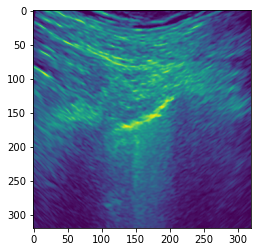

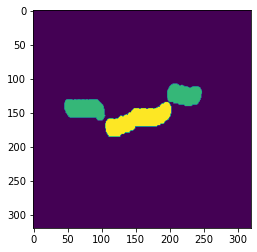

In [4]:
imgnum = 40 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[0,0,1],
            roi_end=[320,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[0,0,1],
            roi_end=[320,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]


torch.Size([4, 4, 320, 320])
torch.Size([4, 320, 320])
image shape: torch.Size([4, 320, 320]), label shape: torch.Size([1, 320, 320])


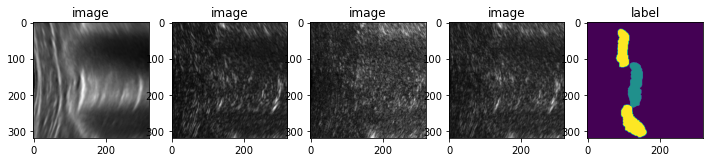

tensor(0.) tensor(2.)


In [7]:
imgnum = 0
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 5, 1)
plt.title("image")
plt.imshow(image[0, :, :], cmap="gray")
plt.subplot(1, 5, 2)
plt.title("image")
plt.imshow(image[1, :, :], cmap="gray")
plt.subplot(1, 5, 3)
plt.title("image")
plt.imshow(image[2, :, :], cmap="gray")
plt.subplot(1, 5, 4)
plt.title("image")
plt.imshow(image[3, :, :], cmap="gray")
plt.subplot(1, 5, 5)
plt.title("label")
plt.imshow(label[0, :, :])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))

max_epochs = 500
net_channels=(32, 64, 128)
net_strides=(2, 2)

In [9]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2])/2
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'.best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'.last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [10]:
for i in range(0,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/500
1/0, train_loss: 0.8884
2/0, train_loss: 0.8844
3/0, train_loss: 0.8811
4/0, train_loss: 0.8816
0 epoch 1 average loss: 0.8839
----------
0: epoch 2/500
1/0, train_loss: 0.8718
2/0, train_loss: 0.8716
3/0, train_loss: 0.8709
4/0, train_loss: 0.8689
0 epoch 2 average loss: 0.8708
current epoch: 2 current mean dice: 0.0510
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 3/500
1/0, train_loss: 0.8663
2/0, train_loss: 0.8668
3/0, train_loss: 0.8643
4/0, train_loss: 0.8588
0 epoch 3 average loss: 0.8640
----------
0: epoch 4/500
1/0, train_loss: 0.8600
2/0, train_loss: 0.8633
3/0, train_loss: 0.8615
4/0, train_loss: 0.8630
0 epoch 4 average loss: 0.8620
current epoch: 4 current mean dice: 0.0432
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 5/500
1/0, train_loss: 0.8593
2/0, train_loss: 0.8580
3/0, train_loss: 0.8592
4/0, train_loss: 0.8541
0 epoch 5 average loss: 0.8577
----------
0: epoch 6/500
1/0, train_loss: 0.8573
2/0, train_loss: 0.8524
3

1/0, train_loss: 0.8148
2/0, train_loss: 0.8150
3/0, train_loss: 0.7966
4/0, train_loss: 0.8032
0 epoch 43 average loss: 0.8074
----------
0: epoch 44/500
1/0, train_loss: 0.8138
2/0, train_loss: 0.8076
3/0, train_loss: 0.8051
4/0, train_loss: 0.7871
0 epoch 44 average loss: 0.8034
current epoch: 44 current mean dice: 0.1947
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 45/500
1/0, train_loss: 0.8026
2/0, train_loss: 0.8068
3/0, train_loss: 0.8114
4/0, train_loss: 0.8098
0 epoch 45 average loss: 0.8077
----------
0: epoch 46/500
1/0, train_loss: 0.7985
2/0, train_loss: 0.8062
3/0, train_loss: 0.8061
4/0, train_loss: 0.8161
0 epoch 46 average loss: 0.8067
current epoch: 46 current mean dice: 0.1777
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 47/500
1/0, train_loss: 0.8060
2/0, train_loss: 0.8021
3/0, train_loss: 0.8055
4/0, train_loss: 0.8048
0 epoch 47 average loss: 0.8046
----------
0: epoch 48/500
1/0, train_loss: 0.8058
2/0, train_loss: 0.8111
3/0, train_loss

1/0, train_loss: 0.7743
2/0, train_loss: 0.7699
3/0, train_loss: 0.7748
4/0, train_loss: 0.7843
0 epoch 85 average loss: 0.7758
----------
0: epoch 86/500
1/0, train_loss: 0.7697
2/0, train_loss: 0.7852
3/0, train_loss: 0.7732
4/0, train_loss: 0.7542
0 epoch 86 average loss: 0.7706
current epoch: 86 current mean dice: 0.1791
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 87/500
1/0, train_loss: 0.7743
2/0, train_loss: 0.7686
3/0, train_loss: 0.7668
4/0, train_loss: 0.7670
0 epoch 87 average loss: 0.7692
----------
0: epoch 88/500
1/0, train_loss: 0.7684
2/0, train_loss: 0.7820
3/0, train_loss: 0.7623
4/0, train_loss: 0.7658
0 epoch 88 average loss: 0.7696
current epoch: 88 current mean dice: 0.2243
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 89/500
1/0, train_loss: 0.7617
2/0, train_loss: 0.7703
3/0, train_loss: 0.7729
4/0, train_loss: 0.7861
0 epoch 89 average loss: 0.7727
----------
0: epoch 90/500
1/0, train_loss: 0.7724
2/0, train_loss: 0.7722
3/0, train_loss

3/0, train_loss: 0.7280
4/0, train_loss: 0.7733
0 epoch 126 average loss: 0.7451
current epoch: 126 current mean dice: 0.2015
best mean dice: 0.2413 at epoch: 116
----------
0: epoch 127/500
1/0, train_loss: 0.7341
2/0, train_loss: 0.7299
3/0, train_loss: 0.7464
4/0, train_loss: 0.7492
0 epoch 127 average loss: 0.7399
----------
0: epoch 128/500
1/0, train_loss: 0.7441
2/0, train_loss: 0.7473
3/0, train_loss: 0.7317
4/0, train_loss: 0.7205
0 epoch 128 average loss: 0.7359
current epoch: 128 current mean dice: 0.2026
best mean dice: 0.2413 at epoch: 116
----------
0: epoch 129/500
1/0, train_loss: 0.7236
2/0, train_loss: 0.7308
3/0, train_loss: 0.7511
4/0, train_loss: 0.7550
0 epoch 129 average loss: 0.7401
----------
0: epoch 130/500
1/0, train_loss: 0.7422
2/0, train_loss: 0.7375
3/0, train_loss: 0.7334
4/0, train_loss: 0.7417
0 epoch 130 average loss: 0.7387
current epoch: 130 current mean dice: 0.2150
best mean dice: 0.2413 at epoch: 116
----------
0: epoch 131/500
1/0, train_loss: 

1/0, train_loss: 0.6948
2/0, train_loss: 0.7100
3/0, train_loss: 0.6996
4/0, train_loss: 0.6872
0 epoch 167 average loss: 0.6979
----------
0: epoch 168/500
1/0, train_loss: 0.6980
2/0, train_loss: 0.6863
3/0, train_loss: 0.7163
4/0, train_loss: 0.6946
0 epoch 168 average loss: 0.6988
current epoch: 168 current mean dice: 0.2635
best mean dice: 0.2894 at epoch: 166
----------
0: epoch 169/500
1/0, train_loss: 0.7015
2/0, train_loss: 0.7027
3/0, train_loss: 0.6822
4/0, train_loss: 0.6970
0 epoch 169 average loss: 0.6959
----------
0: epoch 170/500
1/0, train_loss: 0.7013
2/0, train_loss: 0.6876
3/0, train_loss: 0.7023
4/0, train_loss: 0.7060
0 epoch 170 average loss: 0.6993
current epoch: 170 current mean dice: 0.2414
best mean dice: 0.2894 at epoch: 166
----------
0: epoch 171/500
1/0, train_loss: 0.6904
2/0, train_loss: 0.7030
3/0, train_loss: 0.6837
4/0, train_loss: 0.7050
0 epoch 171 average loss: 0.6955
----------
0: epoch 172/500
1/0, train_loss: 0.6991
2/0, train_loss: 0.7130
3/0

0 epoch 208 average loss: 0.6577
current epoch: 208 current mean dice: 0.3063
best mean dice: 0.3307 at epoch: 206
----------
0: epoch 209/500
1/0, train_loss: 0.6276
2/0, train_loss: 0.6659
3/0, train_loss: 0.6744
4/0, train_loss: 0.6770
0 epoch 209 average loss: 0.6612
----------
0: epoch 210/500
1/0, train_loss: 0.6605
2/0, train_loss: 0.6513
3/0, train_loss: 0.6625
4/0, train_loss: 0.6732
0 epoch 210 average loss: 0.6619
current epoch: 210 current mean dice: 0.2721
best mean dice: 0.3307 at epoch: 206
----------
0: epoch 211/500
1/0, train_loss: 0.6662
2/0, train_loss: 0.6565
3/0, train_loss: 0.6597
4/0, train_loss: 0.6463
0 epoch 211 average loss: 0.6571
----------
0: epoch 212/500
1/0, train_loss: 0.6509
2/0, train_loss: 0.6645
3/0, train_loss: 0.6662
4/0, train_loss: 0.6095
0 epoch 212 average loss: 0.6478
current epoch: 212 current mean dice: 0.2797
best mean dice: 0.3307 at epoch: 206
----------
0: epoch 213/500
1/0, train_loss: 0.6387
2/0, train_loss: 0.6572
3/0, train_loss: 

3/0, train_loss: 0.6261
4/0, train_loss: 0.5932
0 epoch 249 average loss: 0.6111
----------
0: epoch 250/500
1/0, train_loss: 0.6024
2/0, train_loss: 0.6141
3/0, train_loss: 0.6219
4/0, train_loss: 0.6292
0 epoch 250 average loss: 0.6169
saved new best metric model
current epoch: 250 current mean dice: 0.4307
best mean dice: 0.4307 at epoch: 250
----------
0: epoch 251/500
1/0, train_loss: 0.6222
2/0, train_loss: 0.6108
3/0, train_loss: 0.6231
4/0, train_loss: 0.5885
0 epoch 251 average loss: 0.6111
----------
0: epoch 252/500
1/0, train_loss: 0.6144
2/0, train_loss: 0.6191
3/0, train_loss: 0.6192
4/0, train_loss: 0.5947
0 epoch 252 average loss: 0.6119
current epoch: 252 current mean dice: 0.4143
best mean dice: 0.4307 at epoch: 250
----------
0: epoch 253/500
1/0, train_loss: 0.6181
2/0, train_loss: 0.6134
3/0, train_loss: 0.6061
4/0, train_loss: 0.6205
0 epoch 253 average loss: 0.6145
----------
0: epoch 254/500
1/0, train_loss: 0.6063
2/0, train_loss: 0.6065
3/0, train_loss: 0.6068

2/0, train_loss: 0.5872
3/0, train_loss: 0.5840
4/0, train_loss: 0.6144
0 epoch 290 average loss: 0.5866
current epoch: 290 current mean dice: 0.4110
best mean dice: 0.5124 at epoch: 274
----------
0: epoch 291/500
1/0, train_loss: 0.5550
2/0, train_loss: 0.6033
3/0, train_loss: 0.5777
4/0, train_loss: 0.6103
0 epoch 291 average loss: 0.5866
----------
0: epoch 292/500
1/0, train_loss: 0.5734
2/0, train_loss: 0.5797
3/0, train_loss: 0.5631
4/0, train_loss: 0.6323
0 epoch 292 average loss: 0.5871
current epoch: 292 current mean dice: 0.4816
best mean dice: 0.5124 at epoch: 274
----------
0: epoch 293/500
1/0, train_loss: 0.5688
2/0, train_loss: 0.5842
3/0, train_loss: 0.5742
4/0, train_loss: 0.6036
0 epoch 293 average loss: 0.5827
----------
0: epoch 294/500
1/0, train_loss: 0.5843
2/0, train_loss: 0.5756
3/0, train_loss: 0.5797
4/0, train_loss: 0.5686
0 epoch 294 average loss: 0.5770
current epoch: 294 current mean dice: 0.4399
best mean dice: 0.5124 at epoch: 274
----------
0: epoch 2

2/0, train_loss: 0.5619
3/0, train_loss: 0.5520
4/0, train_loss: 0.5311
0 epoch 331 average loss: 0.5512
----------
0: epoch 332/500
1/0, train_loss: 0.5595
2/0, train_loss: 0.5630
3/0, train_loss: 0.5437
4/0, train_loss: 0.5560
0 epoch 332 average loss: 0.5556
current epoch: 332 current mean dice: 0.4888
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 333/500
1/0, train_loss: 0.5440
2/0, train_loss: 0.5378
3/0, train_loss: 0.5674
4/0, train_loss: 0.5578
0 epoch 333 average loss: 0.5518
----------
0: epoch 334/500
1/0, train_loss: 0.5489
2/0, train_loss: 0.5629
3/0, train_loss: 0.5639
4/0, train_loss: 0.5499
0 epoch 334 average loss: 0.5564
current epoch: 334 current mean dice: 0.4870
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 335/500
1/0, train_loss: 0.5587
2/0, train_loss: 0.5499
3/0, train_loss: 0.5489
4/0, train_loss: 0.5703
0 epoch 335 average loss: 0.5569
----------
0: epoch 336/500
1/0, train_loss: 0.5563
2/0, train_loss: 0.5571
3/0, train_loss: 0.5300
4/0

1/0, train_loss: 0.5152
2/0, train_loss: 0.5337
3/0, train_loss: 0.5379
4/0, train_loss: 0.5392
0 epoch 373 average loss: 0.5315
----------
0: epoch 374/500
1/0, train_loss: 0.5314
2/0, train_loss: 0.5161
3/0, train_loss: 0.5427
4/0, train_loss: 0.5328
0 epoch 374 average loss: 0.5308
current epoch: 374 current mean dice: 0.5068
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 375/500
1/0, train_loss: 0.5185
2/0, train_loss: 0.5328
3/0, train_loss: 0.5574
4/0, train_loss: 0.5403
0 epoch 375 average loss: 0.5372
----------
0: epoch 376/500
1/0, train_loss: 0.5262
2/0, train_loss: 0.5398
3/0, train_loss: 0.5271
4/0, train_loss: 0.5088
0 epoch 376 average loss: 0.5255
current epoch: 376 current mean dice: 0.5010
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 377/500
1/0, train_loss: 0.5340
2/0, train_loss: 0.5304
3/0, train_loss: 0.5326
4/0, train_loss: 0.5155
0 epoch 377 average loss: 0.5281
----------
0: epoch 378/500
1/0, train_loss: 0.5218
2/0, train_loss: 0.5357
3/0

current epoch: 414 current mean dice: 0.4688
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 415/500
1/0, train_loss: 0.5245
2/0, train_loss: 0.5056
3/0, train_loss: 0.5042
4/0, train_loss: 0.5142
0 epoch 415 average loss: 0.5121
----------
0: epoch 416/500
1/0, train_loss: 0.5192
2/0, train_loss: 0.5133
3/0, train_loss: 0.4910
4/0, train_loss: 0.5150
0 epoch 416 average loss: 0.5096
current epoch: 416 current mean dice: 0.5219
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 417/500
1/0, train_loss: 0.5211
2/0, train_loss: 0.4982
3/0, train_loss: 0.5204
4/0, train_loss: 0.4923
0 epoch 417 average loss: 0.5080
----------
0: epoch 418/500
1/0, train_loss: 0.5090
2/0, train_loss: 0.4915
3/0, train_loss: 0.5277
4/0, train_loss: 0.5010
0 epoch 418 average loss: 0.5073
current epoch: 418 current mean dice: 0.4940
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 419/500
1/0, train_loss: 0.4771
2/0, train_loss: 0.5059
3/0, train_loss: 0.5385
4/0, train_loss: 0.5277
0 

2/0, train_loss: 0.4868
3/0, train_loss: 0.5043
4/0, train_loss: 0.4937
0 epoch 456 average loss: 0.4922
current epoch: 456 current mean dice: 0.5120
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 457/500
1/0, train_loss: 0.5089
2/0, train_loss: 0.4856
3/0, train_loss: 0.5210
4/0, train_loss: 0.4632
0 epoch 457 average loss: 0.4947
----------
0: epoch 458/500
1/0, train_loss: 0.4908
2/0, train_loss: 0.4991
3/0, train_loss: 0.5099
4/0, train_loss: 0.4663
0 epoch 458 average loss: 0.4915
current epoch: 458 current mean dice: 0.5015
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 459/500
1/0, train_loss: 0.4998
2/0, train_loss: 0.5017
3/0, train_loss: 0.5001
4/0, train_loss: 0.5200
0 epoch 459 average loss: 0.5054
----------
0: epoch 460/500
1/0, train_loss: 0.4846
2/0, train_loss: 0.4936
3/0, train_loss: 0.4999
4/0, train_loss: 0.5119
0 epoch 460 average loss: 0.4975
current epoch: 460 current mean dice: 0.4909
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 4

0 epoch 497 average loss: 0.4920
----------
0: epoch 498/500
1/0, train_loss: 0.4794
2/0, train_loss: 0.5021
3/0, train_loss: 0.4777
4/0, train_loss: 0.4852
0 epoch 498 average loss: 0.4861
current epoch: 498 current mean dice: 0.5130
best mean dice: 0.5281 at epoch: 322
----------
0: epoch 499/500
1/0, train_loss: 0.5063
2/0, train_loss: 0.4841
3/0, train_loss: 0.4819
4/0, train_loss: 0.4728
0 epoch 499 average loss: 0.4863
----------
0: epoch 500/500
1/0, train_loss: 0.4884
2/0, train_loss: 0.4902
3/0, train_loss: 0.4788
4/0, train_loss: 0.5878
0 epoch 500 average loss: 0.5113
current epoch: 500 current mean dice: 0.4906
best mean dice: 0.5281 at epoch: 322
----------
1: epoch 1/500
1/0, train_loss: 0.8840
2/0, train_loss: 0.8762
3/0, train_loss: 0.8753
4/0, train_loss: 0.8761
1 epoch 1 average loss: 0.8779
----------
1: epoch 2/500
1/0, train_loss: 0.8707
2/0, train_loss: 0.8668
3/0, train_loss: 0.8680
4/0, train_loss: 0.8673
1 epoch 2 average loss: 0.8682
current epoch: 2 current m

1 epoch 39 average loss: 0.8056
----------
1: epoch 40/500
1/0, train_loss: 0.8019
2/0, train_loss: 0.8060
3/0, train_loss: 0.8035
4/0, train_loss: 0.7923
1 epoch 40 average loss: 0.8009
current epoch: 40 current mean dice: 0.1742
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 41/500
1/0, train_loss: 0.7871
2/0, train_loss: 0.8012
3/0, train_loss: 0.8178
4/0, train_loss: 0.7868
1 epoch 41 average loss: 0.7982
----------
1: epoch 42/500
1/0, train_loss: 0.8003
2/0, train_loss: 0.8045
3/0, train_loss: 0.8022
4/0, train_loss: 0.7881
1 epoch 42 average loss: 0.7988
current epoch: 42 current mean dice: 0.2181
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 43/500
1/0, train_loss: 0.7939
2/0, train_loss: 0.8039
3/0, train_loss: 0.7936
4/0, train_loss: 0.7972
1 epoch 43 average loss: 0.7971
----------
1: epoch 44/500
1/0, train_loss: 0.8025
2/0, train_loss: 0.7930
3/0, train_loss: 0.7995
4/0, train_loss: 0.7976
1 epoch 44 average loss: 0.7982
current epoch: 44 current mean 

1 epoch 81 average loss: 0.7689
----------
1: epoch 82/500
1/0, train_loss: 0.7907
2/0, train_loss: 0.7475
3/0, train_loss: 0.7612
4/0, train_loss: 0.7783
1 epoch 82 average loss: 0.7694
current epoch: 82 current mean dice: 0.2165
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 83/500
1/0, train_loss: 0.7692
2/0, train_loss: 0.7477
3/0, train_loss: 0.7641
4/0, train_loss: 0.7785
1 epoch 83 average loss: 0.7649
----------
1: epoch 84/500
1/0, train_loss: 0.7596
2/0, train_loss: 0.7622
3/0, train_loss: 0.7589
4/0, train_loss: 0.7510
1 epoch 84 average loss: 0.7579
current epoch: 84 current mean dice: 0.2442
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 85/500
1/0, train_loss: 0.7722
2/0, train_loss: 0.7670
3/0, train_loss: 0.7575
4/0, train_loss: 0.7145
1 epoch 85 average loss: 0.7528
----------
1: epoch 86/500
1/0, train_loss: 0.7547
2/0, train_loss: 0.7768
3/0, train_loss: 0.7601
4/0, train_loss: 0.7458
1 epoch 86 average loss: 0.7594
current epoch: 86 current mean 

1/0, train_loss: 0.7516
2/0, train_loss: 0.7240
3/0, train_loss: 0.7263
4/0, train_loss: 0.6886
1 epoch 123 average loss: 0.7226
----------
1: epoch 124/500
1/0, train_loss: 0.7313
2/0, train_loss: 0.7217
3/0, train_loss: 0.7373
4/0, train_loss: 0.7238
1 epoch 124 average loss: 0.7285
current epoch: 124 current mean dice: 0.2544
best mean dice: 0.3026 at epoch: 118
----------
1: epoch 125/500
1/0, train_loss: 0.7235
2/0, train_loss: 0.7578
3/0, train_loss: 0.7194
4/0, train_loss: 0.6692
1 epoch 125 average loss: 0.7175
----------
1: epoch 126/500
1/0, train_loss: 0.7352
2/0, train_loss: 0.7249
3/0, train_loss: 0.7432
4/0, train_loss: 0.6507
1 epoch 126 average loss: 0.7135
current epoch: 126 current mean dice: 0.2672
best mean dice: 0.3026 at epoch: 118
----------
1: epoch 127/500
1/0, train_loss: 0.7286
2/0, train_loss: 0.7362
3/0, train_loss: 0.7164
4/0, train_loss: 0.7053
1 epoch 127 average loss: 0.7216
----------
1: epoch 128/500
1/0, train_loss: 0.7125
2/0, train_loss: 0.7335
3/0

1 epoch 164 average loss: 0.7105
current epoch: 164 current mean dice: 0.2588
best mean dice: 0.3097 at epoch: 152
----------
1: epoch 165/500
1/0, train_loss: 0.7260
2/0, train_loss: 0.7024
3/0, train_loss: 0.6884
4/0, train_loss: 0.6678
1 epoch 165 average loss: 0.6962
----------
1: epoch 166/500
1/0, train_loss: 0.6901
2/0, train_loss: 0.7200
3/0, train_loss: 0.6965
4/0, train_loss: 0.6969
1 epoch 166 average loss: 0.7009
current epoch: 166 current mean dice: 0.2438
best mean dice: 0.3097 at epoch: 152
----------
1: epoch 167/500
1/0, train_loss: 0.6789
2/0, train_loss: 0.7135
3/0, train_loss: 0.6930
4/0, train_loss: 0.6953
1 epoch 167 average loss: 0.6952
----------
1: epoch 168/500
1/0, train_loss: 0.6855
2/0, train_loss: 0.6984
3/0, train_loss: 0.7026
4/0, train_loss: 0.6652
1 epoch 168 average loss: 0.6879
current epoch: 168 current mean dice: 0.2245
best mean dice: 0.3097 at epoch: 152
----------
1: epoch 169/500
1/0, train_loss: 0.6966
2/0, train_loss: 0.7073
3/0, train_loss: 

3/0, train_loss: 0.6539
4/0, train_loss: 0.6764
1 epoch 205 average loss: 0.6715
----------
1: epoch 206/500
1/0, train_loss: 0.6767
2/0, train_loss: 0.6657
3/0, train_loss: 0.6702
4/0, train_loss: 0.6927
1 epoch 206 average loss: 0.6763
current epoch: 206 current mean dice: 0.3182
best mean dice: 0.3339 at epoch: 202
----------
1: epoch 207/500
1/0, train_loss: 0.6862
2/0, train_loss: 0.6775
3/0, train_loss: 0.6605
4/0, train_loss: 0.7014
1 epoch 207 average loss: 0.6814
----------
1: epoch 208/500
1/0, train_loss: 0.6713
2/0, train_loss: 0.6947
3/0, train_loss: 0.6625
4/0, train_loss: 0.6015
1 epoch 208 average loss: 0.6575
current epoch: 208 current mean dice: 0.3026
best mean dice: 0.3339 at epoch: 202
----------
1: epoch 209/500
1/0, train_loss: 0.6674
2/0, train_loss: 0.6936
3/0, train_loss: 0.6472
4/0, train_loss: 0.6889
1 epoch 209 average loss: 0.6743
----------
1: epoch 210/500
1/0, train_loss: 0.6718
2/0, train_loss: 0.7053
3/0, train_loss: 0.6637
4/0, train_loss: 0.5892
1 e

1/0, train_loss: 0.6412
2/0, train_loss: 0.6651
3/0, train_loss: 0.6740
4/0, train_loss: 0.6207
1 epoch 247 average loss: 0.6502
----------
1: epoch 248/500
1/0, train_loss: 0.6532
2/0, train_loss: 0.6715
3/0, train_loss: 0.6815
4/0, train_loss: 0.5911
1 epoch 248 average loss: 0.6493
current epoch: 248 current mean dice: 0.2903
best mean dice: 0.3339 at epoch: 202
----------
1: epoch 249/500
1/0, train_loss: 0.6587
2/0, train_loss: 0.6431
3/0, train_loss: 0.6638
4/0, train_loss: 0.6250
1 epoch 249 average loss: 0.6477
----------
1: epoch 250/500
1/0, train_loss: 0.6838
2/0, train_loss: 0.6680
3/0, train_loss: 0.6430
4/0, train_loss: 0.6336
1 epoch 250 average loss: 0.6571
current epoch: 250 current mean dice: 0.2585
best mean dice: 0.3339 at epoch: 202
----------
1: epoch 251/500
1/0, train_loss: 0.6132
2/0, train_loss: 0.6829
3/0, train_loss: 0.6807
4/0, train_loss: 0.6556
1 epoch 251 average loss: 0.6581
----------
1: epoch 252/500
1/0, train_loss: 0.6490
2/0, train_loss: 0.7062
3/0

1 epoch 288 average loss: 0.6560
current epoch: 288 current mean dice: 0.2303
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 289/500
1/0, train_loss: 0.6279
2/0, train_loss: 0.6599
3/0, train_loss: 0.6366
4/0, train_loss: 0.6882
1 epoch 289 average loss: 0.6532
----------
1: epoch 290/500
1/0, train_loss: 0.6552
2/0, train_loss: 0.6184
3/0, train_loss: 0.6463
4/0, train_loss: 0.6525
1 epoch 290 average loss: 0.6431
current epoch: 290 current mean dice: 0.2425
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 291/500
1/0, train_loss: 0.6414
2/0, train_loss: 0.6566
3/0, train_loss: 0.6140
4/0, train_loss: 0.6285
1 epoch 291 average loss: 0.6351
----------
1: epoch 292/500
1/0, train_loss: 0.6387
2/0, train_loss: 0.6110
3/0, train_loss: 0.6706
4/0, train_loss: 0.6437
1 epoch 292 average loss: 0.6410
current epoch: 292 current mean dice: 0.2311
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 293/500
1/0, train_loss: 0.6064
2/0, train_loss: 0.6515
3/0, train_loss: 

1/0, train_loss: 0.6448
2/0, train_loss: 0.6132
3/0, train_loss: 0.6550
4/0, train_loss: 0.6062
1 epoch 330 average loss: 0.6298
current epoch: 330 current mean dice: 0.3134
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 331/500
1/0, train_loss: 0.6392
2/0, train_loss: 0.6396
3/0, train_loss: 0.6339
4/0, train_loss: 0.6060
1 epoch 331 average loss: 0.6297
----------
1: epoch 332/500
1/0, train_loss: 0.5949
2/0, train_loss: 0.6225
3/0, train_loss: 0.6785
4/0, train_loss: 0.6619
1 epoch 332 average loss: 0.6395
current epoch: 332 current mean dice: 0.2707
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 333/500
1/0, train_loss: 0.6396
2/0, train_loss: 0.6138
3/0, train_loss: 0.6403
4/0, train_loss: 0.6374
1 epoch 333 average loss: 0.6328
----------
1: epoch 334/500
1/0, train_loss: 0.6739
2/0, train_loss: 0.5981
3/0, train_loss: 0.6370
4/0, train_loss: 0.6099
1 epoch 334 average loss: 0.6297
current epoch: 334 current mean dice: 0.2331
best mean dice: 0.3357 at epoch: 2

3/0, train_loss: 0.6434
4/0, train_loss: 0.6346
1 epoch 371 average loss: 0.6311
----------
1: epoch 372/500
1/0, train_loss: 0.6757
2/0, train_loss: 0.5965
3/0, train_loss: 0.6151
4/0, train_loss: 0.5866
1 epoch 372 average loss: 0.6185
current epoch: 372 current mean dice: 0.2725
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 373/500
1/0, train_loss: 0.6564
2/0, train_loss: 0.6471
3/0, train_loss: 0.6128
4/0, train_loss: 0.5621
1 epoch 373 average loss: 0.6196
----------
1: epoch 374/500
1/0, train_loss: 0.6244
2/0, train_loss: 0.6470
3/0, train_loss: 0.6020
4/0, train_loss: 0.6343
1 epoch 374 average loss: 0.6269
current epoch: 374 current mean dice: 0.2407
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 375/500
1/0, train_loss: 0.6271
2/0, train_loss: 0.6348
3/0, train_loss: 0.6151
4/0, train_loss: 0.5599
1 epoch 375 average loss: 0.6092
----------
1: epoch 376/500
1/0, train_loss: 0.6154
2/0, train_loss: 0.6051
3/0, train_loss: 0.6314
4/0, train_loss: 0.6806
1 e

1/0, train_loss: 0.5507
2/0, train_loss: 0.6599
3/0, train_loss: 0.6678
4/0, train_loss: 0.6131
1 epoch 413 average loss: 0.6229
----------
1: epoch 414/500
1/0, train_loss: 0.6206
2/0, train_loss: 0.6330
3/0, train_loss: 0.6167
4/0, train_loss: 0.6388
1 epoch 414 average loss: 0.6273
current epoch: 414 current mean dice: 0.2832
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 415/500
1/0, train_loss: 0.6494
2/0, train_loss: 0.6622
3/0, train_loss: 0.5664
4/0, train_loss: 0.5860
1 epoch 415 average loss: 0.6160
----------
1: epoch 416/500
1/0, train_loss: 0.6162
2/0, train_loss: 0.6329
3/0, train_loss: 0.6581
4/0, train_loss: 0.5563
1 epoch 416 average loss: 0.6159
current epoch: 416 current mean dice: 0.2539
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 417/500
1/0, train_loss: 0.6274
2/0, train_loss: 0.6365
3/0, train_loss: 0.6024
4/0, train_loss: 0.6228
1 epoch 417 average loss: 0.6223
----------
1: epoch 418/500
1/0, train_loss: 0.6046
2/0, train_loss: 0.6364
3/0

current epoch: 454 current mean dice: 0.2851
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 455/500
1/0, train_loss: 0.6146
2/0, train_loss: 0.5886
3/0, train_loss: 0.5916
4/0, train_loss: 0.7050
1 epoch 455 average loss: 0.6250
----------
1: epoch 456/500
1/0, train_loss: 0.6303
2/0, train_loss: 0.5778
3/0, train_loss: 0.6468
4/0, train_loss: 0.5679
1 epoch 456 average loss: 0.6057
current epoch: 456 current mean dice: 0.2719
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 457/500
1/0, train_loss: 0.6110
2/0, train_loss: 0.5930
3/0, train_loss: 0.6432
4/0, train_loss: 0.5649
1 epoch 457 average loss: 0.6030
----------
1: epoch 458/500
1/0, train_loss: 0.5969
2/0, train_loss: 0.6290
3/0, train_loss: 0.6313
4/0, train_loss: 0.6310
1 epoch 458 average loss: 0.6221
current epoch: 458 current mean dice: 0.2585
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 459/500
1/0, train_loss: 0.6213
2/0, train_loss: 0.6282
3/0, train_loss: 0.6065
4/0, train_loss: 0.6131
1 

2/0, train_loss: 0.6138
3/0, train_loss: 0.5790
4/0, train_loss: 0.6807
1 epoch 496 average loss: 0.6213
current epoch: 496 current mean dice: 0.3183
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 497/500
1/0, train_loss: 0.6054
2/0, train_loss: 0.6328
3/0, train_loss: 0.6177
4/0, train_loss: 0.5545
1 epoch 497 average loss: 0.6026
----------
1: epoch 498/500
1/0, train_loss: 0.5683
2/0, train_loss: 0.6009
3/0, train_loss: 0.6266
4/0, train_loss: 0.6876
1 epoch 498 average loss: 0.6209
current epoch: 498 current mean dice: 0.2140
best mean dice: 0.3357 at epoch: 284
----------
1: epoch 499/500
1/0, train_loss: 0.6294
2/0, train_loss: 0.6151
3/0, train_loss: 0.5904
4/0, train_loss: 0.6162
1 epoch 499 average loss: 0.6128
----------
1: epoch 500/500
1/0, train_loss: 0.5909
2/0, train_loss: 0.6306
3/0, train_loss: 0.6361
4/0, train_loss: 0.5680
1 epoch 500 average loss: 0.6064
current epoch: 500 current mean dice: 0.1918
best mean dice: 0.3357 at epoch: 284
----------
2: epoch 1

2/0, train_loss: 0.8083
3/0, train_loss: 0.8014
4/0, train_loss: 0.7901
2 epoch 38 average loss: 0.7981
current epoch: 38 current mean dice: 0.0706
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 39/500
1/0, train_loss: 0.7949
2/0, train_loss: 0.8077
3/0, train_loss: 0.7975
4/0, train_loss: 0.7871
2 epoch 39 average loss: 0.7968
----------
2: epoch 40/500
1/0, train_loss: 0.7972
2/0, train_loss: 0.7975
3/0, train_loss: 0.8048
4/0, train_loss: 0.8079
2 epoch 40 average loss: 0.8019
current epoch: 40 current mean dice: 0.0783
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 41/500
1/0, train_loss: 0.7920
2/0, train_loss: 0.7931
3/0, train_loss: 0.7988
4/0, train_loss: 0.8118
2 epoch 41 average loss: 0.7989
----------
2: epoch 42/500
1/0, train_loss: 0.7946
2/0, train_loss: 0.8013
3/0, train_loss: 0.7831
4/0, train_loss: 0.8126
2 epoch 42 average loss: 0.7979
current epoch: 42 current mean dice: 0.0735
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 43/500
1/0, t

2/0, train_loss: 0.7582
3/0, train_loss: 0.7454
4/0, train_loss: 0.7594
2 epoch 80 average loss: 0.7568
current epoch: 80 current mean dice: 0.1242
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 81/500
1/0, train_loss: 0.7635
2/0, train_loss: 0.7585
3/0, train_loss: 0.7480
4/0, train_loss: 0.7651
2 epoch 81 average loss: 0.7588
----------
2: epoch 82/500
1/0, train_loss: 0.7443
2/0, train_loss: 0.7570
3/0, train_loss: 0.7621
4/0, train_loss: 0.7450
2 epoch 82 average loss: 0.7521
current epoch: 82 current mean dice: 0.1249
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 83/500
1/0, train_loss: 0.7489
2/0, train_loss: 0.7574
3/0, train_loss: 0.7617
4/0, train_loss: 0.7444
2 epoch 83 average loss: 0.7531
----------
2: epoch 84/500
1/0, train_loss: 0.7581
2/0, train_loss: 0.7497
3/0, train_loss: 0.7543
4/0, train_loss: 0.7700
2 epoch 84 average loss: 0.7580
current epoch: 84 current mean dice: 0.1102
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 85/500
1/0, t

2/0, train_loss: 0.7331
3/0, train_loss: 0.7139
4/0, train_loss: 0.7003
2 epoch 121 average loss: 0.7179
----------
2: epoch 122/500
1/0, train_loss: 0.7019
2/0, train_loss: 0.7220
3/0, train_loss: 0.7347
4/0, train_loss: 0.7226
2 epoch 122 average loss: 0.7203
saved new best metric model
current epoch: 122 current mean dice: 0.1587
best mean dice: 0.1587 at epoch: 122
----------
2: epoch 123/500
1/0, train_loss: 0.7236
2/0, train_loss: 0.7253
3/0, train_loss: 0.7157
4/0, train_loss: 0.6938
2 epoch 123 average loss: 0.7146
----------
2: epoch 124/500
1/0, train_loss: 0.7247
2/0, train_loss: 0.7246
3/0, train_loss: 0.7096
4/0, train_loss: 0.7089
2 epoch 124 average loss: 0.7169
current epoch: 124 current mean dice: 0.1552
best mean dice: 0.1587 at epoch: 122
----------
2: epoch 125/500
1/0, train_loss: 0.7248
2/0, train_loss: 0.7141
3/0, train_loss: 0.7230
4/0, train_loss: 0.7336
2 epoch 125 average loss: 0.7239
----------
2: epoch 126/500
1/0, train_loss: 0.7340
2/0, train_loss: 0.7105

1/0, train_loss: 0.6996
2/0, train_loss: 0.6721
3/0, train_loss: 0.6884
4/0, train_loss: 0.6843
2 epoch 162 average loss: 0.6861
current epoch: 162 current mean dice: 0.1645
best mean dice: 0.1859 at epoch: 160
----------
2: epoch 163/500
1/0, train_loss: 0.6898
2/0, train_loss: 0.6874
3/0, train_loss: 0.6895
4/0, train_loss: 0.6512
2 epoch 163 average loss: 0.6795
----------
2: epoch 164/500
1/0, train_loss: 0.6866
2/0, train_loss: 0.6905
3/0, train_loss: 0.6721
4/0, train_loss: 0.6849
2 epoch 164 average loss: 0.6835
current epoch: 164 current mean dice: 0.1394
best mean dice: 0.1859 at epoch: 160
----------
2: epoch 165/500
1/0, train_loss: 0.6822
2/0, train_loss: 0.7178
3/0, train_loss: 0.6559
4/0, train_loss: 0.6657
2 epoch 165 average loss: 0.6804
----------
2: epoch 166/500
1/0, train_loss: 0.6933
2/0, train_loss: 0.6729
3/0, train_loss: 0.6818
4/0, train_loss: 0.6872
2 epoch 166 average loss: 0.6838
current epoch: 166 current mean dice: 0.1533
best mean dice: 0.1859 at epoch: 1

2/0, train_loss: 0.6529
3/0, train_loss: 0.6470
4/0, train_loss: 0.6120
2 epoch 203 average loss: 0.6428
----------
2: epoch 204/500
1/0, train_loss: 0.6288
2/0, train_loss: 0.6308
3/0, train_loss: 0.6578
4/0, train_loss: 0.6639
2 epoch 204 average loss: 0.6453
current epoch: 204 current mean dice: 0.1790
best mean dice: 0.1911 at epoch: 202
----------
2: epoch 205/500
1/0, train_loss: 0.6500
2/0, train_loss: 0.6528
3/0, train_loss: 0.6409
4/0, train_loss: 0.5956
2 epoch 205 average loss: 0.6348
----------
2: epoch 206/500
1/0, train_loss: 0.6461
2/0, train_loss: 0.6384
3/0, train_loss: 0.6481
4/0, train_loss: 0.6228
2 epoch 206 average loss: 0.6389
current epoch: 206 current mean dice: 0.1519
best mean dice: 0.1911 at epoch: 202
----------
2: epoch 207/500
1/0, train_loss: 0.6624
2/0, train_loss: 0.6301
3/0, train_loss: 0.6208
4/0, train_loss: 0.6553
2 epoch 207 average loss: 0.6422
----------
2: epoch 208/500
1/0, train_loss: 0.6497
2/0, train_loss: 0.6269
3/0, train_loss: 0.6395
4/0

current epoch: 244 current mean dice: 0.1559
best mean dice: 0.1923 at epoch: 228
----------
2: epoch 245/500
1/0, train_loss: 0.6007
2/0, train_loss: 0.5881
3/0, train_loss: 0.6142
4/0, train_loss: 0.6209
2 epoch 245 average loss: 0.6060
----------
2: epoch 246/500
1/0, train_loss: 0.6122
2/0, train_loss: 0.5905
3/0, train_loss: 0.5915
4/0, train_loss: 0.6180
2 epoch 246 average loss: 0.6031
current epoch: 246 current mean dice: 0.1411
best mean dice: 0.1923 at epoch: 228
----------
2: epoch 247/500
1/0, train_loss: 0.5917
2/0, train_loss: 0.6273
3/0, train_loss: 0.5821
4/0, train_loss: 0.6089
2 epoch 247 average loss: 0.6025
----------
2: epoch 248/500
1/0, train_loss: 0.5728
2/0, train_loss: 0.6060
3/0, train_loss: 0.6308
4/0, train_loss: 0.5698
2 epoch 248 average loss: 0.5948
current epoch: 248 current mean dice: 0.1734
best mean dice: 0.1923 at epoch: 228
----------
2: epoch 249/500
1/0, train_loss: 0.5905
2/0, train_loss: 0.6081
3/0, train_loss: 0.6192
4/0, train_loss: 0.5842
2 

1/0, train_loss: 0.5688
2/0, train_loss: 0.5582
3/0, train_loss: 0.5773
4/0, train_loss: 0.5705
2 epoch 286 average loss: 0.5687
current epoch: 286 current mean dice: 0.1307
best mean dice: 0.1956 at epoch: 274
----------
2: epoch 287/500
1/0, train_loss: 0.5487
2/0, train_loss: 0.5703
3/0, train_loss: 0.5678
4/0, train_loss: 0.5558
2 epoch 287 average loss: 0.5606
----------
2: epoch 288/500
1/0, train_loss: 0.5622
2/0, train_loss: 0.5798
3/0, train_loss: 0.5493
4/0, train_loss: 0.5659
2 epoch 288 average loss: 0.5643
current epoch: 288 current mean dice: 0.1499
best mean dice: 0.1956 at epoch: 274
----------
2: epoch 289/500
1/0, train_loss: 0.5611
2/0, train_loss: 0.5752
3/0, train_loss: 0.5428
4/0, train_loss: 0.6003
2 epoch 289 average loss: 0.5699
----------
2: epoch 290/500
1/0, train_loss: 0.5500
2/0, train_loss: 0.5809
3/0, train_loss: 0.5678
4/0, train_loss: 0.5454
2 epoch 290 average loss: 0.5610
current epoch: 290 current mean dice: 0.1505
best mean dice: 0.1956 at epoch: 2

1/0, train_loss: 0.5600
2/0, train_loss: 0.5072
3/0, train_loss: 0.5190
4/0, train_loss: 0.5552
2 epoch 327 average loss: 0.5354
----------
2: epoch 328/500
1/0, train_loss: 0.5538
2/0, train_loss: 0.4962
3/0, train_loss: 0.5261
4/0, train_loss: 0.5916
2 epoch 328 average loss: 0.5419
current epoch: 328 current mean dice: 0.2022
best mean dice: 0.2340 at epoch: 322
----------
2: epoch 329/500
1/0, train_loss: 0.5418
2/0, train_loss: 0.5307
3/0, train_loss: 0.5468
4/0, train_loss: 0.5704
2 epoch 329 average loss: 0.5474
----------
2: epoch 330/500
1/0, train_loss: 0.5201
2/0, train_loss: 0.5269
3/0, train_loss: 0.5387
4/0, train_loss: 0.5409
2 epoch 330 average loss: 0.5316
current epoch: 330 current mean dice: 0.2194
best mean dice: 0.2340 at epoch: 322
----------
2: epoch 331/500
1/0, train_loss: 0.5173
2/0, train_loss: 0.5297
3/0, train_loss: 0.5310
4/0, train_loss: 0.5685
2 epoch 331 average loss: 0.5366
----------
2: epoch 332/500
1/0, train_loss: 0.5510
2/0, train_loss: 0.5144
3/0

2 epoch 368 average loss: 0.5050
current epoch: 368 current mean dice: 0.2115
best mean dice: 0.2954 at epoch: 348
----------
2: epoch 369/500
1/0, train_loss: 0.4995
2/0, train_loss: 0.4991
3/0, train_loss: 0.5027
4/0, train_loss: 0.5333
2 epoch 369 average loss: 0.5087
----------
2: epoch 370/500
1/0, train_loss: 0.4981
2/0, train_loss: 0.5040
3/0, train_loss: 0.5067
4/0, train_loss: 0.4753
2 epoch 370 average loss: 0.4960
current epoch: 370 current mean dice: 0.2155
best mean dice: 0.2954 at epoch: 348
----------
2: epoch 371/500
1/0, train_loss: 0.5094
2/0, train_loss: 0.4877
3/0, train_loss: 0.4959
4/0, train_loss: 0.4779
2 epoch 371 average loss: 0.4927
----------
2: epoch 372/500
1/0, train_loss: 0.4807
2/0, train_loss: 0.5116
3/0, train_loss: 0.4850
4/0, train_loss: 0.5005
2 epoch 372 average loss: 0.4944
current epoch: 372 current mean dice: 0.2032
best mean dice: 0.2954 at epoch: 348
----------
2: epoch 373/500
1/0, train_loss: 0.5204
2/0, train_loss: 0.4815
3/0, train_loss: 

1/0, train_loss: 0.4865
2/0, train_loss: 0.4542
3/0, train_loss: 0.4839
4/0, train_loss: 0.5056
2 epoch 410 average loss: 0.4825
current epoch: 410 current mean dice: 0.2493
best mean dice: 0.2954 at epoch: 348
----------
2: epoch 411/500
1/0, train_loss: 0.4927
2/0, train_loss: 0.4559
3/0, train_loss: 0.4852
4/0, train_loss: 0.5009
2 epoch 411 average loss: 0.4837
----------
2: epoch 412/500
1/0, train_loss: 0.4641
2/0, train_loss: 0.4923
3/0, train_loss: 0.5020
4/0, train_loss: 0.4689
2 epoch 412 average loss: 0.4818
current epoch: 412 current mean dice: 0.2562
best mean dice: 0.2954 at epoch: 348
----------
2: epoch 413/500
1/0, train_loss: 0.4825
2/0, train_loss: 0.4692
3/0, train_loss: 0.4953
4/0, train_loss: 0.5182
2 epoch 413 average loss: 0.4913
----------
2: epoch 414/500
1/0, train_loss: 0.4712
2/0, train_loss: 0.4893
3/0, train_loss: 0.5070
4/0, train_loss: 0.4736
2 epoch 414 average loss: 0.4853
current epoch: 414 current mean dice: 0.2374
best mean dice: 0.2954 at epoch: 3

3/0, train_loss: 0.4616
4/0, train_loss: 0.4665
2 epoch 451 average loss: 0.4624
----------
2: epoch 452/500
1/0, train_loss: 0.4861
2/0, train_loss: 0.4514
3/0, train_loss: 0.4563
4/0, train_loss: 0.4816
2 epoch 452 average loss: 0.4688
current epoch: 452 current mean dice: 0.2186
best mean dice: 0.2954 at epoch: 348
----------
2: epoch 453/500
1/0, train_loss: 0.4737
2/0, train_loss: 0.4769
3/0, train_loss: 0.4504
4/0, train_loss: 0.4780
2 epoch 453 average loss: 0.4697
----------
2: epoch 454/500
1/0, train_loss: 0.4767
2/0, train_loss: 0.4505
3/0, train_loss: 0.4601
4/0, train_loss: 0.4523
2 epoch 454 average loss: 0.4599
current epoch: 454 current mean dice: 0.2298
best mean dice: 0.2954 at epoch: 348
----------
2: epoch 455/500
1/0, train_loss: 0.4668
2/0, train_loss: 0.4641
3/0, train_loss: 0.4643
4/0, train_loss: 0.5300
2 epoch 455 average loss: 0.4813
----------
2: epoch 456/500
1/0, train_loss: 0.4707
2/0, train_loss: 0.4588
3/0, train_loss: 0.4842
4/0, train_loss: 0.4751
2 e

1/0, train_loss: 0.4563
2/0, train_loss: 0.4612
3/0, train_loss: 0.4694
4/0, train_loss: 0.4634
2 epoch 493 average loss: 0.4626
----------
2: epoch 494/500
1/0, train_loss: 0.4840
2/0, train_loss: 0.4667
3/0, train_loss: 0.4506
4/0, train_loss: 0.4528
2 epoch 494 average loss: 0.4635
current epoch: 494 current mean dice: 0.1743
best mean dice: 0.2954 at epoch: 348
----------
2: epoch 495/500
1/0, train_loss: 0.4709
2/0, train_loss: 0.4463
3/0, train_loss: 0.4971
4/0, train_loss: 0.4654
2 epoch 495 average loss: 0.4699
----------
2: epoch 496/500
1/0, train_loss: 0.4703
2/0, train_loss: 0.4571
3/0, train_loss: 0.4467
4/0, train_loss: 0.4905
2 epoch 496 average loss: 0.4662
current epoch: 496 current mean dice: 0.1645
best mean dice: 0.2954 at epoch: 348
----------
2: epoch 497/500
1/0, train_loss: 0.4695
2/0, train_loss: 0.4546
3/0, train_loss: 0.4577
4/0, train_loss: 0.4525
2 epoch 497 average loss: 0.4586
----------
2: epoch 498/500
1/0, train_loss: 0.4491
2/0, train_loss: 0.4936
3/0

1/0, train_loss: 0.8002
2/0, train_loss: 0.8080
3/0, train_loss: 0.7978
4/0, train_loss: 0.8090
3 epoch 35 average loss: 0.8038
----------
3: epoch 36/500
1/0, train_loss: 0.8076
2/0, train_loss: 0.7966
3/0, train_loss: 0.8011
4/0, train_loss: 0.8004
3 epoch 36 average loss: 0.8014
current epoch: 36 current mean dice: 0.1667
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 37/500
1/0, train_loss: 0.7952
2/0, train_loss: 0.8129
3/0, train_loss: 0.8000
4/0, train_loss: 0.7954
3 epoch 37 average loss: 0.8009
----------
3: epoch 38/500
1/0, train_loss: 0.7972
2/0, train_loss: 0.8002
3/0, train_loss: 0.7997
4/0, train_loss: 0.7989
3 epoch 38 average loss: 0.7990
current epoch: 38 current mean dice: 0.1368
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 39/500
1/0, train_loss: 0.7999
2/0, train_loss: 0.7950
3/0, train_loss: 0.7965
4/0, train_loss: 0.7997
3 epoch 39 average loss: 0.7978
----------
3: epoch 40/500
1/0, train_loss: 0.7976
2/0, train_loss: 0.7988
3/0, train_loss

1/0, train_loss: 0.7734
2/0, train_loss: 0.7631
3/0, train_loss: 0.7694
4/0, train_loss: 0.7815
3 epoch 77 average loss: 0.7719
----------
3: epoch 78/500
1/0, train_loss: 0.7675
2/0, train_loss: 0.7690
3/0, train_loss: 0.7709
4/0, train_loss: 0.7615
3 epoch 78 average loss: 0.7672
current epoch: 78 current mean dice: 0.1929
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 79/500
1/0, train_loss: 0.7758
2/0, train_loss: 0.7651
3/0, train_loss: 0.7651
4/0, train_loss: 0.7714
3 epoch 79 average loss: 0.7694
----------
3: epoch 80/500
1/0, train_loss: 0.7637
2/0, train_loss: 0.7772
3/0, train_loss: 0.7704
4/0, train_loss: 0.7607
3 epoch 80 average loss: 0.7680
current epoch: 80 current mean dice: 0.1915
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 81/500
1/0, train_loss: 0.7680
2/0, train_loss: 0.7609
3/0, train_loss: 0.7770
4/0, train_loss: 0.7480
3 epoch 81 average loss: 0.7635
----------
3: epoch 82/500
1/0, train_loss: 0.7709
2/0, train_loss: 0.7729
3/0, train_loss

3/0, train_loss: 0.7404
4/0, train_loss: 0.7540
3 epoch 118 average loss: 0.7421
current epoch: 118 current mean dice: 0.2937
best mean dice: 0.3071 at epoch: 114
----------
3: epoch 119/500
1/0, train_loss: 0.7409
2/0, train_loss: 0.7239
3/0, train_loss: 0.7362
4/0, train_loss: 0.7529
3 epoch 119 average loss: 0.7385
----------
3: epoch 120/500
1/0, train_loss: 0.7276
2/0, train_loss: 0.7334
3/0, train_loss: 0.7404
4/0, train_loss: 0.7320
3 epoch 120 average loss: 0.7334
saved new best metric model
current epoch: 120 current mean dice: 0.3116
best mean dice: 0.3116 at epoch: 120
----------
3: epoch 121/500
1/0, train_loss: 0.7481
2/0, train_loss: 0.7399
3/0, train_loss: 0.7349
4/0, train_loss: 0.7087
3 epoch 121 average loss: 0.7329
----------
3: epoch 122/500
1/0, train_loss: 0.7365
2/0, train_loss: 0.7244
3/0, train_loss: 0.7455
4/0, train_loss: 0.7386
3 epoch 122 average loss: 0.7362
current epoch: 122 current mean dice: 0.2632
best mean dice: 0.3116 at epoch: 120
----------
3: epo

3/0, train_loss: 0.7031
4/0, train_loss: 0.6778
3 epoch 159 average loss: 0.6936
----------
3: epoch 160/500
1/0, train_loss: 0.6975
2/0, train_loss: 0.7174
3/0, train_loss: 0.6813
4/0, train_loss: 0.6783
3 epoch 160 average loss: 0.6936
current epoch: 160 current mean dice: 0.2735
best mean dice: 0.3507 at epoch: 146
----------
3: epoch 161/500
1/0, train_loss: 0.6933
2/0, train_loss: 0.7138
3/0, train_loss: 0.6904
4/0, train_loss: 0.6791
3 epoch 161 average loss: 0.6942
----------
3: epoch 162/500
1/0, train_loss: 0.7137
2/0, train_loss: 0.6774
3/0, train_loss: 0.6974
4/0, train_loss: 0.6909
3 epoch 162 average loss: 0.6948
current epoch: 162 current mean dice: 0.2612
best mean dice: 0.3507 at epoch: 146
----------
3: epoch 163/500
1/0, train_loss: 0.7091
2/0, train_loss: 0.6759
3/0, train_loss: 0.7011
4/0, train_loss: 0.6875
3 epoch 163 average loss: 0.6934
----------
3: epoch 164/500
1/0, train_loss: 0.6790
2/0, train_loss: 0.7030
3/0, train_loss: 0.6871
4/0, train_loss: 0.7159
3 e

1/0, train_loss: 0.6643
2/0, train_loss: 0.6556
3/0, train_loss: 0.6553
4/0, train_loss: 0.6472
3 epoch 201 average loss: 0.6556
----------
3: epoch 202/500
1/0, train_loss: 0.6655
2/0, train_loss: 0.6505
3/0, train_loss: 0.6532
4/0, train_loss: 0.6866
3 epoch 202 average loss: 0.6639
current epoch: 202 current mean dice: 0.3239
best mean dice: 0.3507 at epoch: 146
----------
3: epoch 203/500
1/0, train_loss: 0.6793
2/0, train_loss: 0.6422
3/0, train_loss: 0.6540
4/0, train_loss: 0.6568
3 epoch 203 average loss: 0.6581
----------
3: epoch 204/500
1/0, train_loss: 0.6350
2/0, train_loss: 0.6765
3/0, train_loss: 0.6575
4/0, train_loss: 0.6732
3 epoch 204 average loss: 0.6606
current epoch: 204 current mean dice: 0.3142
best mean dice: 0.3507 at epoch: 146
----------
3: epoch 205/500
1/0, train_loss: 0.6449
2/0, train_loss: 0.6598
3/0, train_loss: 0.6509
4/0, train_loss: 0.6690
3 epoch 205 average loss: 0.6561
----------
3: epoch 206/500
1/0, train_loss: 0.6759
2/0, train_loss: 0.6653
3/0

current epoch: 242 current mean dice: 0.3501
best mean dice: 0.3507 at epoch: 146
----------
3: epoch 243/500
1/0, train_loss: 0.6387
2/0, train_loss: 0.6183
3/0, train_loss: 0.6257
4/0, train_loss: 0.6056
3 epoch 243 average loss: 0.6221
----------
3: epoch 244/500
1/0, train_loss: 0.6206
2/0, train_loss: 0.6308
3/0, train_loss: 0.6201
4/0, train_loss: 0.6656
3 epoch 244 average loss: 0.6343
current epoch: 244 current mean dice: 0.3431
best mean dice: 0.3507 at epoch: 146
----------
3: epoch 245/500
1/0, train_loss: 0.6422
2/0, train_loss: 0.6241
3/0, train_loss: 0.6192
4/0, train_loss: 0.6088
3 epoch 245 average loss: 0.6236
----------
3: epoch 246/500
1/0, train_loss: 0.6203
2/0, train_loss: 0.6237
3/0, train_loss: 0.6417
4/0, train_loss: 0.5861
3 epoch 246 average loss: 0.6180
current epoch: 246 current mean dice: 0.3183
best mean dice: 0.3507 at epoch: 146
----------
3: epoch 247/500
1/0, train_loss: 0.6329
2/0, train_loss: 0.6215
3/0, train_loss: 0.6205
4/0, train_loss: 0.6167
3 

1/0, train_loss: 0.5965
2/0, train_loss: 0.5949
3/0, train_loss: 0.6034
4/0, train_loss: 0.6092
3 epoch 284 average loss: 0.6010
current epoch: 284 current mean dice: 0.3204
best mean dice: 0.3568 at epoch: 260
----------
3: epoch 285/500
1/0, train_loss: 0.5901
2/0, train_loss: 0.6104
3/0, train_loss: 0.6036
4/0, train_loss: 0.5946
3 epoch 285 average loss: 0.5997
----------
3: epoch 286/500
1/0, train_loss: 0.5931
2/0, train_loss: 0.6033
3/0, train_loss: 0.6125
4/0, train_loss: 0.5783
3 epoch 286 average loss: 0.5968
current epoch: 286 current mean dice: 0.3426
best mean dice: 0.3568 at epoch: 260
----------
3: epoch 287/500
1/0, train_loss: 0.6058
2/0, train_loss: 0.5832
3/0, train_loss: 0.6035
4/0, train_loss: 0.6114
3 epoch 287 average loss: 0.6010
----------
3: epoch 288/500
1/0, train_loss: 0.6007
2/0, train_loss: 0.5938
3/0, train_loss: 0.5940
4/0, train_loss: 0.5956
3 epoch 288 average loss: 0.5960
current epoch: 288 current mean dice: 0.3115
best mean dice: 0.3568 at epoch: 2

3/0, train_loss: 0.5804
4/0, train_loss: 0.5362
3 epoch 325 average loss: 0.5686
----------
3: epoch 326/500
1/0, train_loss: 0.5690
2/0, train_loss: 0.5760
3/0, train_loss: 0.5869
4/0, train_loss: 0.5763
3 epoch 326 average loss: 0.5771
current epoch: 326 current mean dice: 0.2541
best mean dice: 0.3568 at epoch: 260
----------
3: epoch 327/500
1/0, train_loss: 0.5514
2/0, train_loss: 0.5909
3/0, train_loss: 0.5806
4/0, train_loss: 0.5970
3 epoch 327 average loss: 0.5800
----------
3: epoch 328/500
1/0, train_loss: 0.5802
2/0, train_loss: 0.5615
3/0, train_loss: 0.5705
4/0, train_loss: 0.5898
3 epoch 328 average loss: 0.5755
current epoch: 328 current mean dice: 0.2921
best mean dice: 0.3568 at epoch: 260
----------
3: epoch 329/500
1/0, train_loss: 0.5830
2/0, train_loss: 0.5807
3/0, train_loss: 0.5720
4/0, train_loss: 0.5444
3 epoch 329 average loss: 0.5700
----------
3: epoch 330/500
1/0, train_loss: 0.5839
2/0, train_loss: 0.5615
3/0, train_loss: 0.5730
4/0, train_loss: 0.5991
3 e

1/0, train_loss: 0.5530
2/0, train_loss: 0.5521
3/0, train_loss: 0.5513
4/0, train_loss: 0.5420
3 epoch 367 average loss: 0.5496
----------
3: epoch 368/500
1/0, train_loss: 0.5628
2/0, train_loss: 0.5385
3/0, train_loss: 0.5649
4/0, train_loss: 0.5256
3 epoch 368 average loss: 0.5480
current epoch: 368 current mean dice: 0.3318
best mean dice: 0.3660 at epoch: 358
----------
3: epoch 369/500
1/0, train_loss: 0.5497
2/0, train_loss: 0.5627
3/0, train_loss: 0.5354
4/0, train_loss: 0.5730
3 epoch 369 average loss: 0.5552
----------
3: epoch 370/500
1/0, train_loss: 0.5408
2/0, train_loss: 0.5397
3/0, train_loss: 0.5648
4/0, train_loss: 0.6031
3 epoch 370 average loss: 0.5621
current epoch: 370 current mean dice: 0.3237
best mean dice: 0.3660 at epoch: 358
----------
3: epoch 371/500
1/0, train_loss: 0.5686
2/0, train_loss: 0.5296
3/0, train_loss: 0.5603
4/0, train_loss: 0.5315
3 epoch 371 average loss: 0.5475
----------
3: epoch 372/500
1/0, train_loss: 0.5551
2/0, train_loss: 0.5515
3/0

current epoch: 408 current mean dice: 0.3123
best mean dice: 0.3660 at epoch: 358
----------
3: epoch 409/500
1/0, train_loss: 0.5501
2/0, train_loss: 0.5297
3/0, train_loss: 0.5302
4/0, train_loss: 0.5410
3 epoch 409 average loss: 0.5378
----------
3: epoch 410/500
1/0, train_loss: 0.5229
2/0, train_loss: 0.5399
3/0, train_loss: 0.5302
4/0, train_loss: 0.5389
3 epoch 410 average loss: 0.5330
current epoch: 410 current mean dice: 0.3475
best mean dice: 0.3660 at epoch: 358
----------
3: epoch 411/500
1/0, train_loss: 0.5343
2/0, train_loss: 0.5459
3/0, train_loss: 0.5149
4/0, train_loss: 0.5397
3 epoch 411 average loss: 0.5337
----------
3: epoch 412/500
1/0, train_loss: 0.5181
2/0, train_loss: 0.5315
3/0, train_loss: 0.5275
4/0, train_loss: 0.5086
3 epoch 412 average loss: 0.5214
current epoch: 412 current mean dice: 0.3597
best mean dice: 0.3660 at epoch: 358
----------
3: epoch 413/500
1/0, train_loss: 0.5140
2/0, train_loss: 0.5106
3/0, train_loss: 0.5471
4/0, train_loss: 0.5578
3 

1/0, train_loss: 0.5102
2/0, train_loss: 0.5160
3/0, train_loss: 0.5044
4/0, train_loss: 0.4929
3 epoch 450 average loss: 0.5059
current epoch: 450 current mean dice: 0.3592
best mean dice: 0.3781 at epoch: 440
----------
3: epoch 451/500
1/0, train_loss: 0.5135
2/0, train_loss: 0.5131
3/0, train_loss: 0.4866
4/0, train_loss: 0.5187
3 epoch 451 average loss: 0.5080
----------
3: epoch 452/500
1/0, train_loss: 0.5239
2/0, train_loss: 0.4941
3/0, train_loss: 0.5147
4/0, train_loss: 0.5387
3 epoch 452 average loss: 0.5178
current epoch: 452 current mean dice: 0.3678
best mean dice: 0.3781 at epoch: 440
----------
3: epoch 453/500
1/0, train_loss: 0.5281
2/0, train_loss: 0.4856
3/0, train_loss: 0.4911
4/0, train_loss: 0.5647
3 epoch 453 average loss: 0.5174
----------
3: epoch 454/500
1/0, train_loss: 0.5039
2/0, train_loss: 0.5090
3/0, train_loss: 0.5232
4/0, train_loss: 0.5170
3 epoch 454 average loss: 0.5133
current epoch: 454 current mean dice: 0.3718
best mean dice: 0.3781 at epoch: 4

2/0, train_loss: 0.4860
3/0, train_loss: 0.4906
4/0, train_loss: 0.4950
3 epoch 491 average loss: 0.4940
----------
3: epoch 492/500
1/0, train_loss: 0.5101
2/0, train_loss: 0.4877
3/0, train_loss: 0.4937
4/0, train_loss: 0.4913
3 epoch 492 average loss: 0.4957
current epoch: 492 current mean dice: 0.3292
best mean dice: 0.3881 at epoch: 482
----------
3: epoch 493/500
1/0, train_loss: 0.5114
2/0, train_loss: 0.4912
3/0, train_loss: 0.4936
4/0, train_loss: 0.5118
3 epoch 493 average loss: 0.5020
----------
3: epoch 494/500
1/0, train_loss: 0.4951
2/0, train_loss: 0.4797
3/0, train_loss: 0.4810
4/0, train_loss: 0.5182
3 epoch 494 average loss: 0.4935
current epoch: 494 current mean dice: 0.3268
best mean dice: 0.3881 at epoch: 482
----------
3: epoch 495/500
1/0, train_loss: 0.4869
2/0, train_loss: 0.4916
3/0, train_loss: 0.5035
4/0, train_loss: 0.5283
3 epoch 495 average loss: 0.5026
----------
3: epoch 496/500
1/0, train_loss: 0.4710
2/0, train_loss: 0.5074
3/0, train_loss: 0.4912
4/0

2/0, train_loss: 0.7927
3/0, train_loss: 0.7939
4/0, train_loss: 0.7992
4 epoch 33 average loss: 0.7964
----------
4: epoch 34/500
1/0, train_loss: 0.7853
2/0, train_loss: 0.8078
3/0, train_loss: 0.7922
4/0, train_loss: 0.7908
4 epoch 34 average loss: 0.7940
current epoch: 34 current mean dice: 0.2181
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 35/500
1/0, train_loss: 0.7990
2/0, train_loss: 0.7926
3/0, train_loss: 0.7891
4/0, train_loss: 0.8050
4 epoch 35 average loss: 0.7964
----------
4: epoch 36/500
1/0, train_loss: 0.7947
2/0, train_loss: 0.7828
3/0, train_loss: 0.7927
4/0, train_loss: 0.8142
4 epoch 36 average loss: 0.7961
current epoch: 36 current mean dice: 0.2184
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 37/500
1/0, train_loss: 0.7842
2/0, train_loss: 0.7985
3/0, train_loss: 0.7916
4/0, train_loss: 0.8043
4 epoch 37 average loss: 0.7947
----------
4: epoch 38/500
1/0, train_loss: 0.7932
2/0, train_loss: 0.7854
3/0, train_loss: 0.7891
4/0, train_loss

2/0, train_loss: 0.7691
3/0, train_loss: 0.7595
4/0, train_loss: 0.7546
4 epoch 75 average loss: 0.7616
----------
4: epoch 76/500
1/0, train_loss: 0.7534
2/0, train_loss: 0.7762
3/0, train_loss: 0.7538
4/0, train_loss: 0.7487
4 epoch 76 average loss: 0.7581
current epoch: 76 current mean dice: 0.3893
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 77/500
1/0, train_loss: 0.7618
2/0, train_loss: 0.7676
3/0, train_loss: 0.7644
4/0, train_loss: 0.7613
4 epoch 77 average loss: 0.7638
----------
4: epoch 78/500
1/0, train_loss: 0.7612
2/0, train_loss: 0.7621
3/0, train_loss: 0.7524
4/0, train_loss: 0.7886
4 epoch 78 average loss: 0.7660
current epoch: 78 current mean dice: 0.3730
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 79/500
1/0, train_loss: 0.7615
2/0, train_loss: 0.7450
3/0, train_loss: 0.7661
4/0, train_loss: 0.7651
4 epoch 79 average loss: 0.7594
----------
4: epoch 80/500
1/0, train_loss: 0.7636
2/0, train_loss: 0.7415
3/0, train_loss: 0.7580
4/0, train_loss

4 epoch 116 average loss: 0.7268
current epoch: 116 current mean dice: 0.4042
best mean dice: 0.4127 at epoch: 114
----------
4: epoch 117/500
1/0, train_loss: 0.7286
2/0, train_loss: 0.7371
3/0, train_loss: 0.7203
4/0, train_loss: 0.7387
4 epoch 117 average loss: 0.7312
----------
4: epoch 118/500
1/0, train_loss: 0.7480
2/0, train_loss: 0.7102
3/0, train_loss: 0.7219
4/0, train_loss: 0.7008
4 epoch 118 average loss: 0.7202
current epoch: 118 current mean dice: 0.3947
best mean dice: 0.4127 at epoch: 114
----------
4: epoch 119/500
1/0, train_loss: 0.7221
2/0, train_loss: 0.7374
3/0, train_loss: 0.7243
4/0, train_loss: 0.7227
4 epoch 119 average loss: 0.7266
----------
4: epoch 120/500
1/0, train_loss: 0.7279
2/0, train_loss: 0.7340
3/0, train_loss: 0.7057
4/0, train_loss: 0.7488
4 epoch 120 average loss: 0.7291
current epoch: 120 current mean dice: 0.3952
best mean dice: 0.4127 at epoch: 114
----------
4: epoch 121/500
1/0, train_loss: 0.7120
2/0, train_loss: 0.7219
3/0, train_loss: 

4 epoch 157 average loss: 0.6921
----------
4: epoch 158/500
1/0, train_loss: 0.6834
2/0, train_loss: 0.7072
3/0, train_loss: 0.6967
4/0, train_loss: 0.6914
4 epoch 158 average loss: 0.6947
current epoch: 158 current mean dice: 0.4057
best mean dice: 0.4220 at epoch: 148
----------
4: epoch 159/500
1/0, train_loss: 0.7028
2/0, train_loss: 0.6822
3/0, train_loss: 0.6905
4/0, train_loss: 0.7084
4 epoch 159 average loss: 0.6960
----------
4: epoch 160/500
1/0, train_loss: 0.6776
2/0, train_loss: 0.6976
3/0, train_loss: 0.7008
4/0, train_loss: 0.6719
4 epoch 160 average loss: 0.6870
current epoch: 160 current mean dice: 0.4051
best mean dice: 0.4220 at epoch: 148
----------
4: epoch 161/500
1/0, train_loss: 0.6914
2/0, train_loss: 0.6803
3/0, train_loss: 0.6799
4/0, train_loss: 0.7224
4 epoch 161 average loss: 0.6935
----------
4: epoch 162/500
1/0, train_loss: 0.6835
2/0, train_loss: 0.7008
3/0, train_loss: 0.6790
4/0, train_loss: 0.6956
4 epoch 162 average loss: 0.6897
current epoch: 162

1/0, train_loss: 0.6489
2/0, train_loss: 0.6640
3/0, train_loss: 0.6725
4/0, train_loss: 0.6742
4 epoch 199 average loss: 0.6649
----------
4: epoch 200/500
1/0, train_loss: 0.6571
2/0, train_loss: 0.6740
3/0, train_loss: 0.6599
4/0, train_loss: 0.6712
4 epoch 200 average loss: 0.6655
current epoch: 200 current mean dice: 0.4059
best mean dice: 0.4344 at epoch: 168
----------
4: epoch 201/500
1/0, train_loss: 0.6589
2/0, train_loss: 0.6452
3/0, train_loss: 0.6642
4/0, train_loss: 0.6726
4 epoch 201 average loss: 0.6602
----------
4: epoch 202/500
1/0, train_loss: 0.6556
2/0, train_loss: 0.6608
3/0, train_loss: 0.6494
4/0, train_loss: 0.6586
4 epoch 202 average loss: 0.6561
current epoch: 202 current mean dice: 0.3788
best mean dice: 0.4344 at epoch: 168
----------
4: epoch 203/500
1/0, train_loss: 0.6538
2/0, train_loss: 0.6533
3/0, train_loss: 0.6589
4/0, train_loss: 0.6781
4 epoch 203 average loss: 0.6610
----------
4: epoch 204/500
1/0, train_loss: 0.6546
2/0, train_loss: 0.6486
3/0

4 epoch 240 average loss: 0.6325
current epoch: 240 current mean dice: 0.4256
best mean dice: 0.4456 at epoch: 238
----------
4: epoch 241/500
1/0, train_loss: 0.6219
2/0, train_loss: 0.6248
3/0, train_loss: 0.6612
4/0, train_loss: 0.5881
4 epoch 241 average loss: 0.6240
----------
4: epoch 242/500
1/0, train_loss: 0.6106
2/0, train_loss: 0.6252
3/0, train_loss: 0.6512
4/0, train_loss: 0.6597
4 epoch 242 average loss: 0.6367
current epoch: 242 current mean dice: 0.4033
best mean dice: 0.4456 at epoch: 238
----------
4: epoch 243/500
1/0, train_loss: 0.6178
2/0, train_loss: 0.6385
3/0, train_loss: 0.6289
4/0, train_loss: 0.6387
4 epoch 243 average loss: 0.6310
----------
4: epoch 244/500
1/0, train_loss: 0.6330
2/0, train_loss: 0.6251
3/0, train_loss: 0.6331
4/0, train_loss: 0.6362
4 epoch 244 average loss: 0.6318
current epoch: 244 current mean dice: 0.4155
best mean dice: 0.4456 at epoch: 238
----------
4: epoch 245/500
1/0, train_loss: 0.6400
2/0, train_loss: 0.6285
3/0, train_loss: 

1/0, train_loss: 0.5926
2/0, train_loss: 0.6013
3/0, train_loss: 0.6176
4/0, train_loss: 0.6163
4 epoch 282 average loss: 0.6069
current epoch: 282 current mean dice: 0.4230
best mean dice: 0.4477 at epoch: 252
----------
4: epoch 283/500
1/0, train_loss: 0.6098
2/0, train_loss: 0.5990
3/0, train_loss: 0.5988
4/0, train_loss: 0.6016
4 epoch 283 average loss: 0.6023
----------
4: epoch 284/500
1/0, train_loss: 0.6035
2/0, train_loss: 0.6035
3/0, train_loss: 0.5848
4/0, train_loss: 0.6332
4 epoch 284 average loss: 0.6062
current epoch: 284 current mean dice: 0.3941
best mean dice: 0.4477 at epoch: 252
----------
4: epoch 285/500
1/0, train_loss: 0.5981
2/0, train_loss: 0.5970
3/0, train_loss: 0.6145
4/0, train_loss: 0.6266
4 epoch 285 average loss: 0.6091
----------
4: epoch 286/500
1/0, train_loss: 0.6083
2/0, train_loss: 0.6163
3/0, train_loss: 0.5851
4/0, train_loss: 0.5989
4 epoch 286 average loss: 0.6022
current epoch: 286 current mean dice: 0.3917
best mean dice: 0.4477 at epoch: 2

3/0, train_loss: 0.5943
4/0, train_loss: 0.5855
4 epoch 323 average loss: 0.5855
----------
4: epoch 324/500
1/0, train_loss: 0.5895
2/0, train_loss: 0.5765
3/0, train_loss: 0.5668
4/0, train_loss: 0.5818
4 epoch 324 average loss: 0.5787
current epoch: 324 current mean dice: 0.3782
best mean dice: 0.4477 at epoch: 252
----------
4: epoch 325/500
1/0, train_loss: 0.5764
2/0, train_loss: 0.5739
3/0, train_loss: 0.5934
4/0, train_loss: 0.5474
4 epoch 325 average loss: 0.5728
----------
4: epoch 326/500
1/0, train_loss: 0.5679
2/0, train_loss: 0.6022
3/0, train_loss: 0.5727
4/0, train_loss: 0.5910
4 epoch 326 average loss: 0.5834
current epoch: 326 current mean dice: 0.4010
best mean dice: 0.4477 at epoch: 252
----------
4: epoch 327/500
1/0, train_loss: 0.5988
2/0, train_loss: 0.5662
3/0, train_loss: 0.5588
4/0, train_loss: 0.5950
4 epoch 327 average loss: 0.5797
----------
4: epoch 328/500
1/0, train_loss: 0.5572
2/0, train_loss: 0.5845
3/0, train_loss: 0.5829
4/0, train_loss: 0.6082
4 e

1/0, train_loss: 0.5535
2/0, train_loss: 0.5661
3/0, train_loss: 0.5479
4/0, train_loss: 0.5849
4 epoch 365 average loss: 0.5631
----------
4: epoch 366/500
1/0, train_loss: 0.5602
2/0, train_loss: 0.5441
3/0, train_loss: 0.5659
4/0, train_loss: 0.5912
4 epoch 366 average loss: 0.5653
current epoch: 366 current mean dice: 0.3859
best mean dice: 0.4498 at epoch: 356
----------
4: epoch 367/500
1/0, train_loss: 0.5570
2/0, train_loss: 0.5626
3/0, train_loss: 0.5574
4/0, train_loss: 0.5729
4 epoch 367 average loss: 0.5625
----------
4: epoch 368/500
1/0, train_loss: 0.5485
2/0, train_loss: 0.5790
3/0, train_loss: 0.5505
4/0, train_loss: 0.5687
4 epoch 368 average loss: 0.5617
current epoch: 368 current mean dice: 0.4428
best mean dice: 0.4498 at epoch: 356
----------
4: epoch 369/500
1/0, train_loss: 0.5671
2/0, train_loss: 0.5678
3/0, train_loss: 0.5467
4/0, train_loss: 0.5155
4 epoch 369 average loss: 0.5493
----------
4: epoch 370/500
1/0, train_loss: 0.5446
2/0, train_loss: 0.5584
3/0

4 epoch 406 average loss: 0.5393
current epoch: 406 current mean dice: 0.4039
best mean dice: 0.4662 at epoch: 392
----------
4: epoch 407/500
1/0, train_loss: 0.5298
2/0, train_loss: 0.5346
3/0, train_loss: 0.5479
4/0, train_loss: 0.5281
4 epoch 407 average loss: 0.5351
----------
4: epoch 408/500
1/0, train_loss: 0.5361
2/0, train_loss: 0.5473
3/0, train_loss: 0.5246
4/0, train_loss: 0.5100
4 epoch 408 average loss: 0.5295
current epoch: 408 current mean dice: 0.4208
best mean dice: 0.4662 at epoch: 392
----------
4: epoch 409/500
1/0, train_loss: 0.5350
2/0, train_loss: 0.5379
3/0, train_loss: 0.5361
4/0, train_loss: 0.5444
4 epoch 409 average loss: 0.5384
----------
4: epoch 410/500
1/0, train_loss: 0.5351
2/0, train_loss: 0.5295
3/0, train_loss: 0.5455
4/0, train_loss: 0.5411
4 epoch 410 average loss: 0.5378
current epoch: 410 current mean dice: 0.4406
best mean dice: 0.4662 at epoch: 392
----------
4: epoch 411/500
1/0, train_loss: 0.5103
2/0, train_loss: 0.5411
3/0, train_loss: 

1/0, train_loss: 0.5053
2/0, train_loss: 0.5064
3/0, train_loss: 0.5315
4/0, train_loss: 0.5106
4 epoch 448 average loss: 0.5134
current epoch: 448 current mean dice: 0.4295
best mean dice: 0.4662 at epoch: 392
----------
4: epoch 449/500
1/0, train_loss: 0.4974
2/0, train_loss: 0.5133
3/0, train_loss: 0.5074
4/0, train_loss: 0.5687
4 epoch 449 average loss: 0.5217
----------
4: epoch 450/500
1/0, train_loss: 0.5134
2/0, train_loss: 0.5201
3/0, train_loss: 0.5479
4/0, train_loss: 0.5050
4 epoch 450 average loss: 0.5216
current epoch: 450 current mean dice: 0.4412
best mean dice: 0.4662 at epoch: 392
----------
4: epoch 451/500
1/0, train_loss: 0.5286
2/0, train_loss: 0.5291
3/0, train_loss: 0.5025
4/0, train_loss: 0.5330
4 epoch 451 average loss: 0.5233
----------
4: epoch 452/500
1/0, train_loss: 0.5153
2/0, train_loss: 0.5225
3/0, train_loss: 0.4943
4/0, train_loss: 0.5022
4 epoch 452 average loss: 0.5086
current epoch: 452 current mean dice: 0.4106
best mean dice: 0.4662 at epoch: 3

3/0, train_loss: 0.4917
4/0, train_loss: 0.4934
4 epoch 489 average loss: 0.4989
----------
4: epoch 490/500
1/0, train_loss: 0.5059
2/0, train_loss: 0.4924
3/0, train_loss: 0.5048
4/0, train_loss: 0.5131
4 epoch 490 average loss: 0.5041
current epoch: 490 current mean dice: 0.4563
best mean dice: 0.4662 at epoch: 392
----------
4: epoch 491/500
1/0, train_loss: 0.4916
2/0, train_loss: 0.4977
3/0, train_loss: 0.5009
4/0, train_loss: 0.4993
4 epoch 491 average loss: 0.4974
----------
4: epoch 492/500
1/0, train_loss: 0.4984
2/0, train_loss: 0.4901
3/0, train_loss: 0.4814
4/0, train_loss: 0.4970
4 epoch 492 average loss: 0.4917
current epoch: 492 current mean dice: 0.4057
best mean dice: 0.4662 at epoch: 392
----------
4: epoch 493/500
1/0, train_loss: 0.4923
2/0, train_loss: 0.4781
3/0, train_loss: 0.5300
4/0, train_loss: 0.4951
4 epoch 493 average loss: 0.4989
----------
4: epoch 494/500
1/0, train_loss: 0.4688
2/0, train_loss: 0.5103
3/0, train_loss: 0.5188
4/0, train_loss: 0.4953
4 e

1/0, train_loss: 0.7959
2/0, train_loss: 0.7810
3/0, train_loss: 0.7966
4/0, train_loss: 0.8070
5 epoch 31 average loss: 0.7951
----------
5: epoch 32/500
1/0, train_loss: 0.7985
2/0, train_loss: 0.7979
3/0, train_loss: 0.7760
4/0, train_loss: 0.7938
5 epoch 32 average loss: 0.7916
current epoch: 32 current mean dice: 0.2636
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 33/500
1/0, train_loss: 0.7949
2/0, train_loss: 0.7891
3/0, train_loss: 0.7829
4/0, train_loss: 0.7751
5 epoch 33 average loss: 0.7855
----------
5: epoch 34/500
1/0, train_loss: 0.7698
2/0, train_loss: 0.7876
3/0, train_loss: 0.7981
4/0, train_loss: 0.7945
5 epoch 34 average loss: 0.7875
current epoch: 34 current mean dice: 0.2659
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 35/500
1/0, train_loss: 0.7959
2/0, train_loss: 0.7842
3/0, train_loss: 0.7856
4/0, train_loss: 0.7752
5 epoch 35 average loss: 0.7852
----------
5: epoch 36/500
1/0, train_loss: 0.7742
2/0, train_loss: 0.7976
3/0, train_loss

1/0, train_loss: 0.7417
2/0, train_loss: 0.7672
3/0, train_loss: 0.7574
4/0, train_loss: 0.7571
5 epoch 73 average loss: 0.7558
----------
5: epoch 74/500
1/0, train_loss: 0.7592
2/0, train_loss: 0.7351
3/0, train_loss: 0.7594
4/0, train_loss: 0.7781
5 epoch 74 average loss: 0.7580
current epoch: 74 current mean dice: 0.2942
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 75/500
1/0, train_loss: 0.7602
2/0, train_loss: 0.7414
3/0, train_loss: 0.7448
4/0, train_loss: 0.7742
5 epoch 75 average loss: 0.7552
----------
5: epoch 76/500
1/0, train_loss: 0.7564
2/0, train_loss: 0.7567
3/0, train_loss: 0.7567
4/0, train_loss: 0.7224
5 epoch 76 average loss: 0.7480
current epoch: 76 current mean dice: 0.2843
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 77/500
1/0, train_loss: 0.7418
2/0, train_loss: 0.7584
3/0, train_loss: 0.7410
4/0, train_loss: 0.7680
5 epoch 77 average loss: 0.7523
----------
5: epoch 78/500
1/0, train_loss: 0.7387
2/0, train_loss: 0.7758
3/0, train_loss

current epoch: 114 current mean dice: 0.2839
best mean dice: 0.2887 at epoch: 108
----------
5: epoch 115/500
1/0, train_loss: 0.7446
2/0, train_loss: 0.7144
3/0, train_loss: 0.7179
4/0, train_loss: 0.7164
5 epoch 115 average loss: 0.7233
----------
5: epoch 116/500
1/0, train_loss: 0.7171
2/0, train_loss: 0.7352
3/0, train_loss: 0.7161
4/0, train_loss: 0.7233
5 epoch 116 average loss: 0.7229
saved new best metric model
current epoch: 116 current mean dice: 0.2977
best mean dice: 0.2977 at epoch: 116
----------
5: epoch 117/500
1/0, train_loss: 0.7240
2/0, train_loss: 0.7175
3/0, train_loss: 0.7100
4/0, train_loss: 0.7328
5 epoch 117 average loss: 0.7211
----------
5: epoch 118/500
1/0, train_loss: 0.7139
2/0, train_loss: 0.7268
3/0, train_loss: 0.7153
4/0, train_loss: 0.7248
5 epoch 118 average loss: 0.7202
current epoch: 118 current mean dice: 0.2837
best mean dice: 0.2977 at epoch: 116
----------
5: epoch 119/500
1/0, train_loss: 0.7128
2/0, train_loss: 0.7261
3/0, train_loss: 0.711

5 epoch 155 average loss: 0.6820
----------
5: epoch 156/500
1/0, train_loss: 0.6757
2/0, train_loss: 0.6806
3/0, train_loss: 0.6813
4/0, train_loss: 0.7450
5 epoch 156 average loss: 0.6957
saved new best metric model
current epoch: 156 current mean dice: 0.3200
best mean dice: 0.3200 at epoch: 156
----------
5: epoch 157/500
1/0, train_loss: 0.6701
2/0, train_loss: 0.6841
3/0, train_loss: 0.6904
4/0, train_loss: 0.6883
5 epoch 157 average loss: 0.6832
----------
5: epoch 158/500
1/0, train_loss: 0.6832
2/0, train_loss: 0.6850
3/0, train_loss: 0.6880
4/0, train_loss: 0.6798
5 epoch 158 average loss: 0.6840
current epoch: 158 current mean dice: 0.3042
best mean dice: 0.3200 at epoch: 156
----------
5: epoch 159/500
1/0, train_loss: 0.6833
2/0, train_loss: 0.6903
3/0, train_loss: 0.6722
4/0, train_loss: 0.6578
5 epoch 159 average loss: 0.6759
----------
5: epoch 160/500
1/0, train_loss: 0.6805
2/0, train_loss: 0.6742
3/0, train_loss: 0.6970
4/0, train_loss: 0.6530
5 epoch 160 average los

3/0, train_loss: 0.6378
4/0, train_loss: 0.6658
5 epoch 196 average loss: 0.6440
current epoch: 196 current mean dice: 0.3507
best mean dice: 0.3602 at epoch: 192
----------
5: epoch 197/500
1/0, train_loss: 0.6403
2/0, train_loss: 0.6319
3/0, train_loss: 0.6385
4/0, train_loss: 0.6337
5 epoch 197 average loss: 0.6361
----------
5: epoch 198/500
1/0, train_loss: 0.6372
2/0, train_loss: 0.6281
3/0, train_loss: 0.6370
4/0, train_loss: 0.6192
5 epoch 198 average loss: 0.6304
saved new best metric model
current epoch: 198 current mean dice: 0.3720
best mean dice: 0.3720 at epoch: 198
----------
5: epoch 199/500
1/0, train_loss: 0.6322
2/0, train_loss: 0.6183
3/0, train_loss: 0.6508
4/0, train_loss: 0.6289
5 epoch 199 average loss: 0.6326
----------
5: epoch 200/500
1/0, train_loss: 0.6419
2/0, train_loss: 0.6402
3/0, train_loss: 0.6018
4/0, train_loss: 0.6699
5 epoch 200 average loss: 0.6384
saved new best metric model
current epoch: 200 current mean dice: 0.3810
best mean dice: 0.3810 at 

1/0, train_loss: 0.5669
2/0, train_loss: 0.5985
3/0, train_loss: 0.5764
4/0, train_loss: 0.6040
5 epoch 237 average loss: 0.5864
----------
5: epoch 238/500
1/0, train_loss: 0.5846
2/0, train_loss: 0.5844
3/0, train_loss: 0.5944
4/0, train_loss: 0.5787
5 epoch 238 average loss: 0.5855
current epoch: 238 current mean dice: 0.4317
best mean dice: 0.4400 at epoch: 236
----------
5: epoch 239/500
1/0, train_loss: 0.5706
2/0, train_loss: 0.5814
3/0, train_loss: 0.5796
4/0, train_loss: 0.6025
5 epoch 239 average loss: 0.5835
----------
5: epoch 240/500
1/0, train_loss: 0.5755
2/0, train_loss: 0.5838
3/0, train_loss: 0.5928
4/0, train_loss: 0.6089
5 epoch 240 average loss: 0.5902
current epoch: 240 current mean dice: 0.3899
best mean dice: 0.4400 at epoch: 236
----------
5: epoch 241/500
1/0, train_loss: 0.5590
2/0, train_loss: 0.5772
3/0, train_loss: 0.5858
4/0, train_loss: 0.6150
5 epoch 241 average loss: 0.5842
----------
5: epoch 242/500
1/0, train_loss: 0.5930
2/0, train_loss: 0.5782
3/0

5 epoch 278 average loss: 0.5480
saved new best metric model
current epoch: 278 current mean dice: 0.4495
best mean dice: 0.4495 at epoch: 278
----------
5: epoch 279/500
1/0, train_loss: 0.5333
2/0, train_loss: 0.5489
3/0, train_loss: 0.5504
4/0, train_loss: 0.5462
5 epoch 279 average loss: 0.5447
----------
5: epoch 280/500
1/0, train_loss: 0.5303
2/0, train_loss: 0.5468
3/0, train_loss: 0.5617
4/0, train_loss: 0.5596
5 epoch 280 average loss: 0.5496
current epoch: 280 current mean dice: 0.4390
best mean dice: 0.4495 at epoch: 278
----------
5: epoch 281/500
1/0, train_loss: 0.5502
2/0, train_loss: 0.5317
3/0, train_loss: 0.5754
4/0, train_loss: 0.5418
5 epoch 281 average loss: 0.5498
----------
5: epoch 282/500
1/0, train_loss: 0.5355
2/0, train_loss: 0.5140
3/0, train_loss: 0.5715
4/0, train_loss: 0.5668
5 epoch 282 average loss: 0.5470
current epoch: 282 current mean dice: 0.4112
best mean dice: 0.4495 at epoch: 278
----------
5: epoch 283/500
1/0, train_loss: 0.5436
2/0, train_lo

5 epoch 319 average loss: 0.5239
----------
5: epoch 320/500
1/0, train_loss: 0.5080
2/0, train_loss: 0.5241
3/0, train_loss: 0.5203
4/0, train_loss: 0.5078
5 epoch 320 average loss: 0.5150
current epoch: 320 current mean dice: 0.4399
best mean dice: 0.4618 at epoch: 286
----------
5: epoch 321/500
1/0, train_loss: 0.4979
2/0, train_loss: 0.5321
3/0, train_loss: 0.5319
4/0, train_loss: 0.5111
5 epoch 321 average loss: 0.5183
----------
5: epoch 322/500
1/0, train_loss: 0.5300
2/0, train_loss: 0.5132
3/0, train_loss: 0.5167
4/0, train_loss: 0.4955
5 epoch 322 average loss: 0.5138
current epoch: 322 current mean dice: 0.4247
best mean dice: 0.4618 at epoch: 286
----------
5: epoch 323/500
1/0, train_loss: 0.5145
2/0, train_loss: 0.5082
3/0, train_loss: 0.5174
4/0, train_loss: 0.4947
5 epoch 323 average loss: 0.5087
----------
5: epoch 324/500
1/0, train_loss: 0.5444
2/0, train_loss: 0.4783
3/0, train_loss: 0.5221
4/0, train_loss: 0.5497
5 epoch 324 average loss: 0.5236
current epoch: 324

1/0, train_loss: 0.5176
2/0, train_loss: 0.4763
3/0, train_loss: 0.4917
4/0, train_loss: 0.5270
5 epoch 361 average loss: 0.5032
----------
5: epoch 362/500
1/0, train_loss: 0.5252
2/0, train_loss: 0.4922
3/0, train_loss: 0.4935
4/0, train_loss: 0.4836
5 epoch 362 average loss: 0.4986
current epoch: 362 current mean dice: 0.4617
best mean dice: 0.4774 at epoch: 358
----------
5: epoch 363/500
1/0, train_loss: 0.4767
2/0, train_loss: 0.5068
3/0, train_loss: 0.5004
4/0, train_loss: 0.5279
5 epoch 363 average loss: 0.5030
----------
5: epoch 364/500
1/0, train_loss: 0.5022
2/0, train_loss: 0.4938
3/0, train_loss: 0.4916
4/0, train_loss: 0.4929
5 epoch 364 average loss: 0.4951
current epoch: 364 current mean dice: 0.4434
best mean dice: 0.4774 at epoch: 358
----------
5: epoch 365/500
1/0, train_loss: 0.5103
2/0, train_loss: 0.5056
3/0, train_loss: 0.5138
4/0, train_loss: 0.4584
5 epoch 365 average loss: 0.4970
----------
5: epoch 366/500
1/0, train_loss: 0.4835
2/0, train_loss: 0.5132
3/0

5 epoch 402 average loss: 0.4860
current epoch: 402 current mean dice: 0.4417
best mean dice: 0.4956 at epoch: 376
----------
5: epoch 403/500
1/0, train_loss: 0.4674
2/0, train_loss: 0.5241
3/0, train_loss: 0.4779
4/0, train_loss: 0.5058
5 epoch 403 average loss: 0.4938
----------
5: epoch 404/500
1/0, train_loss: 0.4679
2/0, train_loss: 0.4781
3/0, train_loss: 0.4861
4/0, train_loss: 0.4827
5 epoch 404 average loss: 0.4787
current epoch: 404 current mean dice: 0.4018
best mean dice: 0.4956 at epoch: 376
----------
5: epoch 405/500
1/0, train_loss: 0.4758
2/0, train_loss: 0.4814
3/0, train_loss: 0.4703
4/0, train_loss: 0.4822
5 epoch 405 average loss: 0.4774
----------
5: epoch 406/500
1/0, train_loss: 0.4544
2/0, train_loss: 0.4874
3/0, train_loss: 0.4899
4/0, train_loss: 0.4804
5 epoch 406 average loss: 0.4780
current epoch: 406 current mean dice: 0.4276
best mean dice: 0.4956 at epoch: 376
----------
5: epoch 407/500
1/0, train_loss: 0.4691
2/0, train_loss: 0.4636
3/0, train_loss: 

1/0, train_loss: 0.4598
2/0, train_loss: 0.4777
3/0, train_loss: 0.4911
4/0, train_loss: 0.4663
5 epoch 444 average loss: 0.4737
current epoch: 444 current mean dice: 0.4677
best mean dice: 0.4956 at epoch: 376
----------
5: epoch 445/500
1/0, train_loss: 0.4545
2/0, train_loss: 0.4747
3/0, train_loss: 0.4680
4/0, train_loss: 0.4810
5 epoch 445 average loss: 0.4696
----------
5: epoch 446/500
1/0, train_loss: 0.4647
2/0, train_loss: 0.4571
3/0, train_loss: 0.4884
4/0, train_loss: 0.4581
5 epoch 446 average loss: 0.4671
current epoch: 446 current mean dice: 0.4517
best mean dice: 0.4956 at epoch: 376
----------
5: epoch 447/500
1/0, train_loss: 0.4768
2/0, train_loss: 0.4499
3/0, train_loss: 0.4730
4/0, train_loss: 0.4534
5 epoch 447 average loss: 0.4633
----------
5: epoch 448/500
1/0, train_loss: 0.4616
2/0, train_loss: 0.4685
3/0, train_loss: 0.4754
4/0, train_loss: 0.4541
5 epoch 448 average loss: 0.4649
current epoch: 448 current mean dice: 0.4438
best mean dice: 0.4956 at epoch: 3

3/0, train_loss: 0.4388
4/0, train_loss: 0.4747
5 epoch 485 average loss: 0.4625
----------
5: epoch 486/500
1/0, train_loss: 0.4428
2/0, train_loss: 0.4771
3/0, train_loss: 0.4743
4/0, train_loss: 0.4291
5 epoch 486 average loss: 0.4558
current epoch: 486 current mean dice: 0.4624
best mean dice: 0.4956 at epoch: 376
----------
5: epoch 487/500
1/0, train_loss: 0.4789
2/0, train_loss: 0.4486
3/0, train_loss: 0.4390
4/0, train_loss: 0.4556
5 epoch 487 average loss: 0.4555
----------
5: epoch 488/500
1/0, train_loss: 0.4631
2/0, train_loss: 0.4779
3/0, train_loss: 0.4407
4/0, train_loss: 0.4609
5 epoch 488 average loss: 0.4606
current epoch: 488 current mean dice: 0.4413
best mean dice: 0.4956 at epoch: 376
----------
5: epoch 489/500
1/0, train_loss: 0.4609
2/0, train_loss: 0.4609
3/0, train_loss: 0.4727
4/0, train_loss: 0.4211
5 epoch 489 average loss: 0.4539
----------
5: epoch 490/500
1/0, train_loss: 0.4627
2/0, train_loss: 0.4446
3/0, train_loss: 0.4704
4/0, train_loss: 0.4627
5 e

2/0, train_loss: 0.7797
3/0, train_loss: 0.7999
4/0, train_loss: 0.7901
6 epoch 27 average loss: 0.7881
----------
6: epoch 28/500
1/0, train_loss: 0.7784
2/0, train_loss: 0.7842
3/0, train_loss: 0.7839
4/0, train_loss: 0.7820
6 epoch 28 average loss: 0.7821
current epoch: 28 current mean dice: 0.1141
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 29/500
1/0, train_loss: 0.7798
2/0, train_loss: 0.7747
3/0, train_loss: 0.7862
4/0, train_loss: 0.8091
6 epoch 29 average loss: 0.7874
----------
6: epoch 30/500
1/0, train_loss: 0.7860
2/0, train_loss: 0.7890
3/0, train_loss: 0.7876
4/0, train_loss: 0.7449
6 epoch 30 average loss: 0.7769
current epoch: 30 current mean dice: 0.1371
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 31/500
1/0, train_loss: 0.7803
2/0, train_loss: 0.7668
3/0, train_loss: 0.7887
4/0, train_loss: 0.7696
6 epoch 31 average loss: 0.7763
----------
6: epoch 32/500
1/0, train_loss: 0.7795
2/0, train_loss: 0.7709
3/0, train_loss: 0.7847
4/0, train_loss

2/0, train_loss: 0.7202
3/0, train_loss: 0.7586
4/0, train_loss: 0.7275
6 epoch 69 average loss: 0.7429
----------
6: epoch 70/500
1/0, train_loss: 0.7400
2/0, train_loss: 0.7561
3/0, train_loss: 0.7345
4/0, train_loss: 0.7429
6 epoch 70 average loss: 0.7434
current epoch: 70 current mean dice: 0.2645
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 71/500
1/0, train_loss: 0.7288
2/0, train_loss: 0.7388
3/0, train_loss: 0.7403
4/0, train_loss: 0.7681
6 epoch 71 average loss: 0.7440
----------
6: epoch 72/500
1/0, train_loss: 0.7399
2/0, train_loss: 0.7505
3/0, train_loss: 0.7413
4/0, train_loss: 0.7129
6 epoch 72 average loss: 0.7361
current epoch: 72 current mean dice: 0.2461
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 73/500
1/0, train_loss: 0.7492
2/0, train_loss: 0.7272
3/0, train_loss: 0.7450
4/0, train_loss: 0.7415
6 epoch 73 average loss: 0.7407
----------
6: epoch 74/500
1/0, train_loss: 0.7249
2/0, train_loss: 0.7292
3/0, train_loss: 0.7653
4/0, train_loss

current epoch: 110 current mean dice: 0.2342
best mean dice: 0.2401 at epoch: 108
----------
6: epoch 111/500
1/0, train_loss: 0.7010
2/0, train_loss: 0.7179
3/0, train_loss: 0.7157
4/0, train_loss: 0.7087
6 epoch 111 average loss: 0.7108
----------
6: epoch 112/500
1/0, train_loss: 0.7203
2/0, train_loss: 0.7075
3/0, train_loss: 0.7178
4/0, train_loss: 0.6856
6 epoch 112 average loss: 0.7078
current epoch: 112 current mean dice: 0.2141
best mean dice: 0.2401 at epoch: 108
----------
6: epoch 113/500
1/0, train_loss: 0.7078
2/0, train_loss: 0.7086
3/0, train_loss: 0.7088
4/0, train_loss: 0.7351
6 epoch 113 average loss: 0.7151
----------
6: epoch 114/500
1/0, train_loss: 0.6907
2/0, train_loss: 0.7014
3/0, train_loss: 0.7224
4/0, train_loss: 0.7134
6 epoch 114 average loss: 0.7070
current epoch: 114 current mean dice: 0.2184
best mean dice: 0.2401 at epoch: 108
----------
6: epoch 115/500
1/0, train_loss: 0.7117
2/0, train_loss: 0.7028
3/0, train_loss: 0.6966
4/0, train_loss: 0.7207
6 

6 epoch 151 average loss: 0.6798
----------
6: epoch 152/500
1/0, train_loss: 0.7133
2/0, train_loss: 0.6578
3/0, train_loss: 0.6853
4/0, train_loss: 0.6660
6 epoch 152 average loss: 0.6806
current epoch: 152 current mean dice: 0.2497
best mean dice: 0.3364 at epoch: 130
----------
6: epoch 153/500
1/0, train_loss: 0.6768
2/0, train_loss: 0.6595
3/0, train_loss: 0.6888
4/0, train_loss: 0.7083
6 epoch 153 average loss: 0.6833
----------
6: epoch 154/500
1/0, train_loss: 0.6651
2/0, train_loss: 0.7002
3/0, train_loss: 0.6642
4/0, train_loss: 0.6925
6 epoch 154 average loss: 0.6805
current epoch: 154 current mean dice: 0.3018
best mean dice: 0.3364 at epoch: 130
----------
6: epoch 155/500
1/0, train_loss: 0.6886
2/0, train_loss: 0.6884
3/0, train_loss: 0.6274
4/0, train_loss: 0.7038
6 epoch 155 average loss: 0.6771
----------
6: epoch 156/500
1/0, train_loss: 0.6713
2/0, train_loss: 0.6844
3/0, train_loss: 0.6662
4/0, train_loss: 0.6923
6 epoch 156 average loss: 0.6785
current epoch: 156

4/0, train_loss: 0.6927
6 epoch 192 average loss: 0.6528
current epoch: 192 current mean dice: 0.3167
best mean dice: 0.3664 at epoch: 188
----------
6: epoch 193/500
1/0, train_loss: 0.6336
2/0, train_loss: 0.6455
3/0, train_loss: 0.6623
4/0, train_loss: 0.6559
6 epoch 193 average loss: 0.6493
----------
6: epoch 194/500
1/0, train_loss: 0.6268
2/0, train_loss: 0.6589
3/0, train_loss: 0.6513
4/0, train_loss: 0.6291
6 epoch 194 average loss: 0.6415
current epoch: 194 current mean dice: 0.3383
best mean dice: 0.3664 at epoch: 188
----------
6: epoch 195/500
1/0, train_loss: 0.6486
2/0, train_loss: 0.6360
3/0, train_loss: 0.6376
4/0, train_loss: 0.6599
6 epoch 195 average loss: 0.6455
----------
6: epoch 196/500
1/0, train_loss: 0.6332
2/0, train_loss: 0.6104
3/0, train_loss: 0.6606
4/0, train_loss: 0.6963
6 epoch 196 average loss: 0.6501
saved new best metric model
current epoch: 196 current mean dice: 0.3765
best mean dice: 0.3765 at epoch: 196
----------
6: epoch 197/500
1/0, train_lo

4/0, train_loss: 0.6236
6 epoch 233 average loss: 0.6122
----------
6: epoch 234/500
1/0, train_loss: 0.6041
2/0, train_loss: 0.5969
3/0, train_loss: 0.6248
4/0, train_loss: 0.6249
6 epoch 234 average loss: 0.6127
current epoch: 234 current mean dice: 0.3233
best mean dice: 0.3867 at epoch: 226
----------
6: epoch 235/500
1/0, train_loss: 0.6099
2/0, train_loss: 0.6227
3/0, train_loss: 0.5978
4/0, train_loss: 0.6249
6 epoch 235 average loss: 0.6138
----------
6: epoch 236/500
1/0, train_loss: 0.6157
2/0, train_loss: 0.5950
3/0, train_loss: 0.6067
4/0, train_loss: 0.6402
6 epoch 236 average loss: 0.6144
saved new best metric model
current epoch: 236 current mean dice: 0.3965
best mean dice: 0.3965 at epoch: 236
----------
6: epoch 237/500
1/0, train_loss: 0.6085
2/0, train_loss: 0.6200
3/0, train_loss: 0.6010
4/0, train_loss: 0.6045
6 epoch 237 average loss: 0.6085
----------
6: epoch 238/500
1/0, train_loss: 0.6159
2/0, train_loss: 0.6021
3/0, train_loss: 0.6031
4/0, train_loss: 0.6103

1/0, train_loss: 0.5908
2/0, train_loss: 0.5709
3/0, train_loss: 0.5909
4/0, train_loss: 0.5517
6 epoch 275 average loss: 0.5761
----------
6: epoch 276/500
1/0, train_loss: 0.5761
2/0, train_loss: 0.5843
3/0, train_loss: 0.5585
4/0, train_loss: 0.5889
6 epoch 276 average loss: 0.5769
current epoch: 276 current mean dice: 0.3878
best mean dice: 0.4175 at epoch: 238
----------
6: epoch 277/500
1/0, train_loss: 0.5969
2/0, train_loss: 0.5698
3/0, train_loss: 0.6025
4/0, train_loss: 0.5506
6 epoch 277 average loss: 0.5800
----------
6: epoch 278/500
1/0, train_loss: 0.5857
2/0, train_loss: 0.5446
3/0, train_loss: 0.5979
4/0, train_loss: 0.6087
6 epoch 278 average loss: 0.5842
current epoch: 278 current mean dice: 0.3527
best mean dice: 0.4175 at epoch: 238
----------
6: epoch 279/500
1/0, train_loss: 0.5692
2/0, train_loss: 0.5972
3/0, train_loss: 0.5857
4/0, train_loss: 0.5683
6 epoch 279 average loss: 0.5801
----------
6: epoch 280/500
1/0, train_loss: 0.5698
2/0, train_loss: 0.6070
3/0

current epoch: 316 current mean dice: 0.3615
best mean dice: 0.4175 at epoch: 238
----------
6: epoch 317/500
1/0, train_loss: 0.5573
2/0, train_loss: 0.5559
3/0, train_loss: 0.5475
4/0, train_loss: 0.5540
6 epoch 317 average loss: 0.5537
----------
6: epoch 318/500
1/0, train_loss: 0.5799
2/0, train_loss: 0.5237
3/0, train_loss: 0.5459
4/0, train_loss: 0.5427
6 epoch 318 average loss: 0.5480
current epoch: 318 current mean dice: 0.3604
best mean dice: 0.4175 at epoch: 238
----------
6: epoch 319/500
1/0, train_loss: 0.5520
2/0, train_loss: 0.5664
3/0, train_loss: 0.5411
4/0, train_loss: 0.5807
6 epoch 319 average loss: 0.5600
----------
6: epoch 320/500
1/0, train_loss: 0.5425
2/0, train_loss: 0.5470
3/0, train_loss: 0.5472
4/0, train_loss: 0.5974
6 epoch 320 average loss: 0.5585
current epoch: 320 current mean dice: 0.3736
best mean dice: 0.4175 at epoch: 238
----------
6: epoch 321/500
1/0, train_loss: 0.5247
2/0, train_loss: 0.5669
3/0, train_loss: 0.5490
4/0, train_loss: 0.5841
6 

6 epoch 357 average loss: 0.5374
----------
6: epoch 358/500
1/0, train_loss: 0.5257
2/0, train_loss: 0.5141
3/0, train_loss: 0.5506
4/0, train_loss: 0.5320
6 epoch 358 average loss: 0.5306
current epoch: 358 current mean dice: 0.3803
best mean dice: 0.4666 at epoch: 346
----------
6: epoch 359/500
1/0, train_loss: 0.5164
2/0, train_loss: 0.5392
3/0, train_loss: 0.5306
4/0, train_loss: 0.5373
6 epoch 359 average loss: 0.5309
----------
6: epoch 360/500
1/0, train_loss: 0.5262
2/0, train_loss: 0.5607
3/0, train_loss: 0.5233
4/0, train_loss: 0.4858
6 epoch 360 average loss: 0.5240
current epoch: 360 current mean dice: 0.3342
best mean dice: 0.4666 at epoch: 346
----------
6: epoch 361/500
1/0, train_loss: 0.5364
2/0, train_loss: 0.5298
3/0, train_loss: 0.5364
4/0, train_loss: 0.5519
6 epoch 361 average loss: 0.5386
----------
6: epoch 362/500
1/0, train_loss: 0.5413
2/0, train_loss: 0.5399
3/0, train_loss: 0.5037
4/0, train_loss: 0.5315
6 epoch 362 average loss: 0.5291
current epoch: 362

1/0, train_loss: 0.5100
2/0, train_loss: 0.5062
3/0, train_loss: 0.5209
4/0, train_loss: 0.5191
6 epoch 399 average loss: 0.5141
----------
6: epoch 400/500
1/0, train_loss: 0.5032
2/0, train_loss: 0.5034
3/0, train_loss: 0.5044
4/0, train_loss: 0.5737
6 epoch 400 average loss: 0.5212
current epoch: 400 current mean dice: 0.4571
best mean dice: 0.4711 at epoch: 398
----------
6: epoch 401/500
1/0, train_loss: 0.5290
2/0, train_loss: 0.5259
3/0, train_loss: 0.5068
4/0, train_loss: 0.5087
6 epoch 401 average loss: 0.5176
----------
6: epoch 402/500
1/0, train_loss: 0.5035
2/0, train_loss: 0.5014
3/0, train_loss: 0.5119
4/0, train_loss: 0.5571
6 epoch 402 average loss: 0.5185
current epoch: 402 current mean dice: 0.4349
best mean dice: 0.4711 at epoch: 398
----------
6: epoch 403/500
1/0, train_loss: 0.4997
2/0, train_loss: 0.5439
3/0, train_loss: 0.5033
4/0, train_loss: 0.5193
6 epoch 403 average loss: 0.5166
----------
6: epoch 404/500
1/0, train_loss: 0.4935
2/0, train_loss: 0.5227
3/0

4/0, train_loss: 0.5026
6 epoch 440 average loss: 0.4934
current epoch: 440 current mean dice: 0.3443
best mean dice: 0.4959 at epoch: 420
----------
6: epoch 441/500
1/0, train_loss: 0.4910
2/0, train_loss: 0.4848
3/0, train_loss: 0.4991
4/0, train_loss: 0.5584
6 epoch 441 average loss: 0.5083
----------
6: epoch 442/500
1/0, train_loss: 0.4820
2/0, train_loss: 0.5068
3/0, train_loss: 0.4924
4/0, train_loss: 0.5013
6 epoch 442 average loss: 0.4956
current epoch: 442 current mean dice: 0.3832
best mean dice: 0.4959 at epoch: 420
----------
6: epoch 443/500
1/0, train_loss: 0.5054
2/0, train_loss: 0.4815
3/0, train_loss: 0.4980
4/0, train_loss: 0.4647
6 epoch 443 average loss: 0.4874
----------
6: epoch 444/500
1/0, train_loss: 0.4804
2/0, train_loss: 0.4913
3/0, train_loss: 0.5211
4/0, train_loss: 0.4932
6 epoch 444 average loss: 0.4965
current epoch: 444 current mean dice: 0.3928
best mean dice: 0.4959 at epoch: 420
----------
6: epoch 445/500
1/0, train_loss: 0.4842
2/0, train_loss: 

1/0, train_loss: 0.4813
2/0, train_loss: 0.4597
3/0, train_loss: 0.4808
4/0, train_loss: 0.4692
6 epoch 482 average loss: 0.4728
current epoch: 482 current mean dice: 0.3757
best mean dice: 0.4959 at epoch: 420
----------
6: epoch 483/500
1/0, train_loss: 0.4629
2/0, train_loss: 0.4681
3/0, train_loss: 0.5175
4/0, train_loss: 0.4742
6 epoch 483 average loss: 0.4807
----------
6: epoch 484/500
1/0, train_loss: 0.4768
2/0, train_loss: 0.4893
3/0, train_loss: 0.4596
4/0, train_loss: 0.4832
6 epoch 484 average loss: 0.4772
current epoch: 484 current mean dice: 0.4315
best mean dice: 0.4959 at epoch: 420
----------
6: epoch 485/500
1/0, train_loss: 0.4944
2/0, train_loss: 0.4693
3/0, train_loss: 0.4709
4/0, train_loss: 0.5208
6 epoch 485 average loss: 0.4888
----------
6: epoch 486/500
1/0, train_loss: 0.4717
2/0, train_loss: 0.4889
3/0, train_loss: 0.4943
4/0, train_loss: 0.4722
6 epoch 486 average loss: 0.4818
current epoch: 486 current mean dice: 0.4771
best mean dice: 0.4959 at epoch: 4

1/0, train_loss: 0.8074
2/0, train_loss: 0.8093
3/0, train_loss: 0.8102
4/0, train_loss: 0.8103
7 epoch 24 average loss: 0.8093
current epoch: 24 current mean dice: 0.1253
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 25/500
1/0, train_loss: 0.8030
2/0, train_loss: 0.8158
3/0, train_loss: 0.8140
4/0, train_loss: 0.7973
7 epoch 25 average loss: 0.8075
----------
7: epoch 26/500
1/0, train_loss: 0.8116
2/0, train_loss: 0.7981
3/0, train_loss: 0.8152
4/0, train_loss: 0.8057
7 epoch 26 average loss: 0.8076
current epoch: 26 current mean dice: 0.1181
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 27/500
1/0, train_loss: 0.8056
2/0, train_loss: 0.8101
3/0, train_loss: 0.8069
4/0, train_loss: 0.8017
7 epoch 27 average loss: 0.8061
----------
7: epoch 28/500
1/0, train_loss: 0.8001
2/0, train_loss: 0.8152
3/0, train_loss: 0.8090
4/0, train_loss: 0.7975
7 epoch 28 average loss: 0.8054
current epoch: 28 current mean dice: 0.1347
best mean dice: -1.0000 at epoch: -1
---------

1/0, train_loss: 0.7658
2/0, train_loss: 0.7713
3/0, train_loss: 0.7774
4/0, train_loss: 0.7749
7 epoch 66 average loss: 0.7723
current epoch: 66 current mean dice: 0.1570
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 67/500
1/0, train_loss: 0.7683
2/0, train_loss: 0.7711
3/0, train_loss: 0.7720
4/0, train_loss: 0.7662
7 epoch 67 average loss: 0.7694
----------
7: epoch 68/500
1/0, train_loss: 0.7660
2/0, train_loss: 0.7721
3/0, train_loss: 0.7667
4/0, train_loss: 0.7698
7 epoch 68 average loss: 0.7687
current epoch: 68 current mean dice: 0.1810
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 69/500
1/0, train_loss: 0.7646
2/0, train_loss: 0.7802
3/0, train_loss: 0.7625
4/0, train_loss: 0.7618
7 epoch 69 average loss: 0.7673
----------
7: epoch 70/500
1/0, train_loss: 0.7615
2/0, train_loss: 0.7685
3/0, train_loss: 0.7708
4/0, train_loss: 0.7752
7 epoch 70 average loss: 0.7690
current epoch: 70 current mean dice: 0.1536
best mean dice: -1.0000 at epoch: -1
---------

4/0, train_loss: 0.7411
7 epoch 107 average loss: 0.7399
----------
7: epoch 108/500
1/0, train_loss: 0.7398
2/0, train_loss: 0.7394
3/0, train_loss: 0.7333
4/0, train_loss: 0.7466
7 epoch 108 average loss: 0.7398
current epoch: 108 current mean dice: 0.1764
best mean dice: 0.2024 at epoch: 104
----------
7: epoch 109/500
1/0, train_loss: 0.7410
2/0, train_loss: 0.7404
3/0, train_loss: 0.7477
4/0, train_loss: 0.7266
7 epoch 109 average loss: 0.7389
----------
7: epoch 110/500
1/0, train_loss: 0.7486
2/0, train_loss: 0.7306
3/0, train_loss: 0.7419
4/0, train_loss: 0.7257
7 epoch 110 average loss: 0.7367
current epoch: 110 current mean dice: 0.1926
best mean dice: 0.2024 at epoch: 104
----------
7: epoch 111/500
1/0, train_loss: 0.7342
2/0, train_loss: 0.7334
3/0, train_loss: 0.7375
4/0, train_loss: 0.7446
7 epoch 111 average loss: 0.7374
----------
7: epoch 112/500
1/0, train_loss: 0.7412
2/0, train_loss: 0.7295
3/0, train_loss: 0.7423
4/0, train_loss: 0.7278
7 epoch 112 average loss: 0

1/0, train_loss: 0.7214
2/0, train_loss: 0.7117
3/0, train_loss: 0.6959
4/0, train_loss: 0.7055
7 epoch 149 average loss: 0.7086
----------
7: epoch 150/500
1/0, train_loss: 0.7034
2/0, train_loss: 0.7102
3/0, train_loss: 0.7038
4/0, train_loss: 0.7145
7 epoch 150 average loss: 0.7080
current epoch: 150 current mean dice: 0.1867
best mean dice: 0.2048 at epoch: 132
----------
7: epoch 151/500
1/0, train_loss: 0.7086
2/0, train_loss: 0.6999
3/0, train_loss: 0.7075
4/0, train_loss: 0.7168
7 epoch 151 average loss: 0.7082
----------
7: epoch 152/500
1/0, train_loss: 0.7026
2/0, train_loss: 0.6975
3/0, train_loss: 0.7101
4/0, train_loss: 0.7074
7 epoch 152 average loss: 0.7044
current epoch: 152 current mean dice: 0.1966
best mean dice: 0.2048 at epoch: 132
----------
7: epoch 153/500
1/0, train_loss: 0.7091
2/0, train_loss: 0.6954
3/0, train_loss: 0.7103
4/0, train_loss: 0.6980
7 epoch 153 average loss: 0.7032
----------
7: epoch 154/500
1/0, train_loss: 0.7039
2/0, train_loss: 0.7041
3/0

1/0, train_loss: 0.6607
2/0, train_loss: 0.6530
3/0, train_loss: 0.6498
4/0, train_loss: 0.6270
7 epoch 190 average loss: 0.6476
current epoch: 190 current mean dice: 0.2425
best mean dice: 0.2675 at epoch: 178
----------
7: epoch 191/500
1/0, train_loss: 0.6587
2/0, train_loss: 0.6388
3/0, train_loss: 0.6630
4/0, train_loss: 0.6469
7 epoch 191 average loss: 0.6519
----------
7: epoch 192/500
1/0, train_loss: 0.6372
2/0, train_loss: 0.6626
3/0, train_loss: 0.6543
4/0, train_loss: 0.6659
7 epoch 192 average loss: 0.6550
saved new best metric model
current epoch: 192 current mean dice: 0.2772
best mean dice: 0.2772 at epoch: 192
----------
7: epoch 193/500
1/0, train_loss: 0.6450
2/0, train_loss: 0.6542
3/0, train_loss: 0.6530
4/0, train_loss: 0.6589
7 epoch 193 average loss: 0.6528
----------
7: epoch 194/500
1/0, train_loss: 0.6457
2/0, train_loss: 0.6446
3/0, train_loss: 0.6546
4/0, train_loss: 0.6634
7 epoch 194 average loss: 0.6521
current epoch: 194 current mean dice: 0.2471
best m

2/0, train_loss: 0.6075
3/0, train_loss: 0.6054
4/0, train_loss: 0.6137
7 epoch 231 average loss: 0.6148
----------
7: epoch 232/500
1/0, train_loss: 0.6312
2/0, train_loss: 0.6351
3/0, train_loss: 0.5983
4/0, train_loss: 0.5719
7 epoch 232 average loss: 0.6091
current epoch: 232 current mean dice: 0.2489
best mean dice: 0.2772 at epoch: 192
----------
7: epoch 233/500
1/0, train_loss: 0.6133
2/0, train_loss: 0.6289
3/0, train_loss: 0.6164
4/0, train_loss: 0.5822
7 epoch 233 average loss: 0.6102
----------
7: epoch 234/500
1/0, train_loss: 0.6441
2/0, train_loss: 0.6083
3/0, train_loss: 0.6004
4/0, train_loss: 0.5871
7 epoch 234 average loss: 0.6100
current epoch: 234 current mean dice: 0.2580
best mean dice: 0.2772 at epoch: 192
----------
7: epoch 235/500
1/0, train_loss: 0.6087
2/0, train_loss: 0.6002
3/0, train_loss: 0.6193
4/0, train_loss: 0.6394
7 epoch 235 average loss: 0.6169
----------
7: epoch 236/500
1/0, train_loss: 0.6201
2/0, train_loss: 0.6117
3/0, train_loss: 0.6118
4/0

7 epoch 272 average loss: 0.5819
current epoch: 272 current mean dice: 0.2855
best mean dice: 0.2958 at epoch: 266
----------
7: epoch 273/500
1/0, train_loss: 0.5799
2/0, train_loss: 0.5908
3/0, train_loss: 0.5948
4/0, train_loss: 0.5650
7 epoch 273 average loss: 0.5826
----------
7: epoch 274/500
1/0, train_loss: 0.5850
2/0, train_loss: 0.5833
3/0, train_loss: 0.5940
4/0, train_loss: 0.5673
7 epoch 274 average loss: 0.5824
current epoch: 274 current mean dice: 0.2482
best mean dice: 0.2958 at epoch: 266
----------
7: epoch 275/500
1/0, train_loss: 0.5961
2/0, train_loss: 0.5818
3/0, train_loss: 0.5955
4/0, train_loss: 0.6005
7 epoch 275 average loss: 0.5935
----------
7: epoch 276/500
1/0, train_loss: 0.5919
2/0, train_loss: 0.5829
3/0, train_loss: 0.5862
4/0, train_loss: 0.6016
7 epoch 276 average loss: 0.5906
current epoch: 276 current mean dice: 0.2484
best mean dice: 0.2958 at epoch: 266
----------
7: epoch 277/500
1/0, train_loss: 0.5974
2/0, train_loss: 0.5699
3/0, train_loss: 

1/0, train_loss: 0.5437
2/0, train_loss: 0.5802
3/0, train_loss: 0.5654
4/0, train_loss: 0.5832
7 epoch 314 average loss: 0.5681
current epoch: 314 current mean dice: 0.2678
best mean dice: 0.3067 at epoch: 302
----------
7: epoch 315/500
1/0, train_loss: 0.5441
2/0, train_loss: 0.5623
3/0, train_loss: 0.5661
4/0, train_loss: 0.6124
7 epoch 315 average loss: 0.5712
----------
7: epoch 316/500
1/0, train_loss: 0.5717
2/0, train_loss: 0.5688
3/0, train_loss: 0.5486
4/0, train_loss: 0.5316
7 epoch 316 average loss: 0.5552
current epoch: 316 current mean dice: 0.2541
best mean dice: 0.3067 at epoch: 302
----------
7: epoch 317/500
1/0, train_loss: 0.5651
2/0, train_loss: 0.6026
3/0, train_loss: 0.5256
4/0, train_loss: 0.5514
7 epoch 317 average loss: 0.5612
----------
7: epoch 318/500
1/0, train_loss: 0.5532
2/0, train_loss: 0.5243
3/0, train_loss: 0.5624
4/0, train_loss: 0.5569
7 epoch 318 average loss: 0.5492
current epoch: 318 current mean dice: 0.2819
best mean dice: 0.3067 at epoch: 3

1/0, train_loss: 0.5138
2/0, train_loss: 0.5158
3/0, train_loss: 0.5324
4/0, train_loss: 0.5163
7 epoch 355 average loss: 0.5196
----------
7: epoch 356/500
1/0, train_loss: 0.5209
2/0, train_loss: 0.5263
3/0, train_loss: 0.5099
4/0, train_loss: 0.5591
7 epoch 356 average loss: 0.5290
saved new best metric model
current epoch: 356 current mean dice: 0.3408
best mean dice: 0.3408 at epoch: 356
----------
7: epoch 357/500
1/0, train_loss: 0.5255
2/0, train_loss: 0.5408
3/0, train_loss: 0.5105
4/0, train_loss: 0.5369
7 epoch 357 average loss: 0.5284
----------
7: epoch 358/500
1/0, train_loss: 0.5166
2/0, train_loss: 0.5068
3/0, train_loss: 0.5266
4/0, train_loss: 0.5974
7 epoch 358 average loss: 0.5368
current epoch: 358 current mean dice: 0.3372
best mean dice: 0.3408 at epoch: 356
----------
7: epoch 359/500
1/0, train_loss: 0.5201
2/0, train_loss: 0.5203
3/0, train_loss: 0.5300
4/0, train_loss: 0.5272
7 epoch 359 average loss: 0.5244
----------
7: epoch 360/500
1/0, train_loss: 0.5303

7 epoch 396 average loss: 0.5045
current epoch: 396 current mean dice: 0.3312
best mean dice: 0.3511 at epoch: 380
----------
7: epoch 397/500
1/0, train_loss: 0.5123
2/0, train_loss: 0.4935
3/0, train_loss: 0.5017
4/0, train_loss: 0.5087
7 epoch 397 average loss: 0.5041
----------
7: epoch 398/500
1/0, train_loss: 0.5100
2/0, train_loss: 0.4971
3/0, train_loss: 0.5159
4/0, train_loss: 0.4728
7 epoch 398 average loss: 0.4990
current epoch: 398 current mean dice: 0.3284
best mean dice: 0.3511 at epoch: 380
----------
7: epoch 399/500
1/0, train_loss: 0.5018
2/0, train_loss: 0.4918
3/0, train_loss: 0.5206
4/0, train_loss: 0.4942
7 epoch 399 average loss: 0.5021
----------
7: epoch 400/500
1/0, train_loss: 0.4832
2/0, train_loss: 0.5348
3/0, train_loss: 0.4897
4/0, train_loss: 0.4947
7 epoch 400 average loss: 0.5006
current epoch: 400 current mean dice: 0.3141
best mean dice: 0.3511 at epoch: 380
----------
7: epoch 401/500
1/0, train_loss: 0.4904
2/0, train_loss: 0.4882
3/0, train_loss: 

1/0, train_loss: 0.4958
2/0, train_loss: 0.4871
3/0, train_loss: 0.4743
4/0, train_loss: 0.4826
7 epoch 438 average loss: 0.4850
current epoch: 438 current mean dice: 0.3463
best mean dice: 0.3527 at epoch: 408
----------
7: epoch 439/500
1/0, train_loss: 0.5043
2/0, train_loss: 0.4761
3/0, train_loss: 0.4739
4/0, train_loss: 0.4527
7 epoch 439 average loss: 0.4768
----------
7: epoch 440/500
1/0, train_loss: 0.4662
2/0, train_loss: 0.4994
3/0, train_loss: 0.4746
4/0, train_loss: 0.5183
7 epoch 440 average loss: 0.4896
current epoch: 440 current mean dice: 0.3209
best mean dice: 0.3527 at epoch: 408
----------
7: epoch 441/500
1/0, train_loss: 0.4684
2/0, train_loss: 0.4928
3/0, train_loss: 0.4976
4/0, train_loss: 0.4827
7 epoch 441 average loss: 0.4853
----------
7: epoch 442/500
1/0, train_loss: 0.4876
2/0, train_loss: 0.4646
3/0, train_loss: 0.4895
4/0, train_loss: 0.4909
7 epoch 442 average loss: 0.4831
current epoch: 442 current mean dice: 0.3170
best mean dice: 0.3527 at epoch: 4

2/0, train_loss: 0.4749
3/0, train_loss: 0.4861
4/0, train_loss: 0.4943
7 epoch 479 average loss: 0.4833
----------
7: epoch 480/500
1/0, train_loss: 0.4838
2/0, train_loss: 0.4966
3/0, train_loss: 0.4904
4/0, train_loss: 0.4503
7 epoch 480 average loss: 0.4803
current epoch: 480 current mean dice: 0.2869
best mean dice: 0.3792 at epoch: 446
----------
7: epoch 481/500
1/0, train_loss: 0.4586
2/0, train_loss: 0.4756
3/0, train_loss: 0.4967
4/0, train_loss: 0.4931
7 epoch 481 average loss: 0.4810
----------
7: epoch 482/500
1/0, train_loss: 0.4852
2/0, train_loss: 0.4978
3/0, train_loss: 0.4575
4/0, train_loss: 0.4623
7 epoch 482 average loss: 0.4757
current epoch: 482 current mean dice: 0.2861
best mean dice: 0.3792 at epoch: 446
----------
7: epoch 483/500
1/0, train_loss: 0.4904
2/0, train_loss: 0.4683
3/0, train_loss: 0.4716
4/0, train_loss: 0.4917
7 epoch 483 average loss: 0.4805
----------
7: epoch 484/500
1/0, train_loss: 0.4689
2/0, train_loss: 0.4823
3/0, train_loss: 0.5022
4/0

1/0, train_loss: 0.8017
2/0, train_loss: 0.8033
3/0, train_loss: 0.8081
4/0, train_loss: 0.8201
8 epoch 21 average loss: 0.8083
----------
8: epoch 22/500
1/0, train_loss: 0.8121
2/0, train_loss: 0.7986
3/0, train_loss: 0.8001
4/0, train_loss: 0.7972
8 epoch 22 average loss: 0.8020
current epoch: 22 current mean dice: 0.2560
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 23/500
1/0, train_loss: 0.7979
2/0, train_loss: 0.7962
3/0, train_loss: 0.8116
4/0, train_loss: 0.8147
8 epoch 23 average loss: 0.8051
----------
8: epoch 24/500
1/0, train_loss: 0.8103
2/0, train_loss: 0.8018
3/0, train_loss: 0.7903
4/0, train_loss: 0.7879
8 epoch 24 average loss: 0.7976
current epoch: 24 current mean dice: 0.2220
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 25/500
1/0, train_loss: 0.8030
2/0, train_loss: 0.8017
3/0, train_loss: 0.8070
4/0, train_loss: 0.7792
8 epoch 25 average loss: 0.7977
----------
8: epoch 26/500
1/0, train_loss: 0.7930
2/0, train_loss: 0.7956
3/0, train_loss

1/0, train_loss: 0.7441
2/0, train_loss: 0.7614
3/0, train_loss: 0.7636
4/0, train_loss: 0.7700
8 epoch 63 average loss: 0.7597
----------
8: epoch 64/500
1/0, train_loss: 0.7580
2/0, train_loss: 0.7576
3/0, train_loss: 0.7444
4/0, train_loss: 0.7409
8 epoch 64 average loss: 0.7502
current epoch: 64 current mean dice: 0.3474
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 65/500
1/0, train_loss: 0.7505
2/0, train_loss: 0.7647
3/0, train_loss: 0.7481
4/0, train_loss: 0.7370
8 epoch 65 average loss: 0.7501
----------
8: epoch 66/500
1/0, train_loss: 0.7451
2/0, train_loss: 0.7669
3/0, train_loss: 0.7379
4/0, train_loss: 0.7597
8 epoch 66 average loss: 0.7524
current epoch: 66 current mean dice: 0.3798
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 67/500
1/0, train_loss: 0.7525
2/0, train_loss: 0.7525
3/0, train_loss: 0.7560
4/0, train_loss: 0.7261
8 epoch 67 average loss: 0.7468
----------
8: epoch 68/500
1/0, train_loss: 0.7371
2/0, train_loss: 0.7649
3/0, train_loss

1/0, train_loss: 0.7353
2/0, train_loss: 0.7138
3/0, train_loss: 0.7149
4/0, train_loss: 0.7047
8 epoch 105 average loss: 0.7172
----------
8: epoch 106/500
1/0, train_loss: 0.7396
2/0, train_loss: 0.7133
3/0, train_loss: 0.7103
4/0, train_loss: 0.7147
8 epoch 106 average loss: 0.7195
current epoch: 106 current mean dice: 0.3378
best mean dice: 0.3612 at epoch: 104
----------
8: epoch 107/500
1/0, train_loss: 0.6997
2/0, train_loss: 0.7270
3/0, train_loss: 0.7365
4/0, train_loss: 0.7214
8 epoch 107 average loss: 0.7212
----------
8: epoch 108/500
1/0, train_loss: 0.7308
2/0, train_loss: 0.6970
3/0, train_loss: 0.7235
4/0, train_loss: 0.7312
8 epoch 108 average loss: 0.7206
saved new best metric model
current epoch: 108 current mean dice: 0.3797
best mean dice: 0.3797 at epoch: 108
----------
8: epoch 109/500
1/0, train_loss: 0.7122
2/0, train_loss: 0.7112
3/0, train_loss: 0.7173
4/0, train_loss: 0.7180
8 epoch 109 average loss: 0.7147
----------
8: epoch 110/500
1/0, train_loss: 0.7118

1/0, train_loss: 0.6951
2/0, train_loss: 0.6757
3/0, train_loss: 0.6631
4/0, train_loss: 0.7344
8 epoch 146 average loss: 0.6921
current epoch: 146 current mean dice: 0.4368
best mean dice: 0.4448 at epoch: 124
----------
8: epoch 147/500
1/0, train_loss: 0.6865
2/0, train_loss: 0.6862
3/0, train_loss: 0.6777
4/0, train_loss: 0.6804
8 epoch 147 average loss: 0.6827
----------
8: epoch 148/500
1/0, train_loss: 0.6969
2/0, train_loss: 0.6744
3/0, train_loss: 0.6714
4/0, train_loss: 0.6917
8 epoch 148 average loss: 0.6836
current epoch: 148 current mean dice: 0.4382
best mean dice: 0.4448 at epoch: 124
----------
8: epoch 149/500
1/0, train_loss: 0.7041
2/0, train_loss: 0.6514
3/0, train_loss: 0.6994
4/0, train_loss: 0.6873
8 epoch 149 average loss: 0.6856
----------
8: epoch 150/500
1/0, train_loss: 0.6817
2/0, train_loss: 0.6755
3/0, train_loss: 0.6768
4/0, train_loss: 0.6843
8 epoch 150 average loss: 0.6796
current epoch: 150 current mean dice: 0.4120
best mean dice: 0.4448 at epoch: 1

2/0, train_loss: 0.6701
3/0, train_loss: 0.6472
4/0, train_loss: 0.6508
8 epoch 187 average loss: 0.6556
----------
8: epoch 188/500
1/0, train_loss: 0.6368
2/0, train_loss: 0.6640
3/0, train_loss: 0.6576
4/0, train_loss: 0.6887
8 epoch 188 average loss: 0.6618
current epoch: 188 current mean dice: 0.4065
best mean dice: 0.4607 at epoch: 168
----------
8: epoch 189/500
1/0, train_loss: 0.6654
2/0, train_loss: 0.6651
3/0, train_loss: 0.6641
4/0, train_loss: 0.6090
8 epoch 189 average loss: 0.6509
----------
8: epoch 190/500
1/0, train_loss: 0.6518
2/0, train_loss: 0.6541
3/0, train_loss: 0.6586
4/0, train_loss: 0.6142
8 epoch 190 average loss: 0.6446
current epoch: 190 current mean dice: 0.4339
best mean dice: 0.4607 at epoch: 168
----------
8: epoch 191/500
1/0, train_loss: 0.6563
2/0, train_loss: 0.6693
3/0, train_loss: 0.6325
4/0, train_loss: 0.6338
8 epoch 191 average loss: 0.6480
----------
8: epoch 192/500
1/0, train_loss: 0.6417
2/0, train_loss: 0.6930
3/0, train_loss: 0.6515
4/0

current epoch: 228 current mean dice: 0.4526
best mean dice: 0.4691 at epoch: 198
----------
8: epoch 229/500
1/0, train_loss: 0.6428
2/0, train_loss: 0.6331
3/0, train_loss: 0.6014
4/0, train_loss: 0.6319
8 epoch 229 average loss: 0.6273
----------
8: epoch 230/500
1/0, train_loss: 0.6105
2/0, train_loss: 0.6498
3/0, train_loss: 0.6242
4/0, train_loss: 0.6317
8 epoch 230 average loss: 0.6291
current epoch: 230 current mean dice: 0.4532
best mean dice: 0.4691 at epoch: 198
----------
8: epoch 231/500
1/0, train_loss: 0.6299
2/0, train_loss: 0.6482
3/0, train_loss: 0.6196
4/0, train_loss: 0.5899
8 epoch 231 average loss: 0.6219
----------
8: epoch 232/500
1/0, train_loss: 0.6189
2/0, train_loss: 0.6438
3/0, train_loss: 0.6163
4/0, train_loss: 0.6011
8 epoch 232 average loss: 0.6200
current epoch: 232 current mean dice: 0.4652
best mean dice: 0.4691 at epoch: 198
----------
8: epoch 233/500
1/0, train_loss: 0.6022
2/0, train_loss: 0.6303
3/0, train_loss: 0.6262
4/0, train_loss: 0.6791
8 

1/0, train_loss: 0.6124
2/0, train_loss: 0.5952
3/0, train_loss: 0.5949
4/0, train_loss: 0.5911
8 epoch 270 average loss: 0.5984
current epoch: 270 current mean dice: 0.4631
best mean dice: 0.4775 at epoch: 258
----------
8: epoch 271/500
1/0, train_loss: 0.6117
2/0, train_loss: 0.5940
3/0, train_loss: 0.5888
4/0, train_loss: 0.5839
8 epoch 271 average loss: 0.5946
----------
8: epoch 272/500
1/0, train_loss: 0.5680
2/0, train_loss: 0.6078
3/0, train_loss: 0.6114
4/0, train_loss: 0.6197
8 epoch 272 average loss: 0.6017
current epoch: 272 current mean dice: 0.4640
best mean dice: 0.4775 at epoch: 258
----------
8: epoch 273/500
1/0, train_loss: 0.5791
2/0, train_loss: 0.6039
3/0, train_loss: 0.6108
4/0, train_loss: 0.6166
8 epoch 273 average loss: 0.6026
----------
8: epoch 274/500
1/0, train_loss: 0.6393
2/0, train_loss: 0.5883
3/0, train_loss: 0.5823
4/0, train_loss: 0.5514
8 epoch 274 average loss: 0.5903
current epoch: 274 current mean dice: 0.4750
best mean dice: 0.4775 at epoch: 2

1/0, train_loss: 0.5696
2/0, train_loss: 0.5783
3/0, train_loss: 0.5669
4/0, train_loss: 0.6020
8 epoch 311 average loss: 0.5792
----------
8: epoch 312/500
1/0, train_loss: 0.6102
2/0, train_loss: 0.5454
3/0, train_loss: 0.5761
4/0, train_loss: 0.5423
8 epoch 312 average loss: 0.5685
current epoch: 312 current mean dice: 0.4499
best mean dice: 0.5276 at epoch: 300
----------
8: epoch 313/500
1/0, train_loss: 0.5832
2/0, train_loss: 0.5529
3/0, train_loss: 0.5928
4/0, train_loss: 0.5583
8 epoch 313 average loss: 0.5718
----------
8: epoch 314/500
1/0, train_loss: 0.5448
2/0, train_loss: 0.5809
3/0, train_loss: 0.5871
4/0, train_loss: 0.5525
8 epoch 314 average loss: 0.5663
current epoch: 314 current mean dice: 0.4429
best mean dice: 0.5276 at epoch: 300
----------
8: epoch 315/500
1/0, train_loss: 0.5928
2/0, train_loss: 0.5436
3/0, train_loss: 0.5723
4/0, train_loss: 0.5531
8 epoch 315 average loss: 0.5655
----------
8: epoch 316/500
1/0, train_loss: 0.5549
2/0, train_loss: 0.5556
3/0

4/0, train_loss: 0.5500
8 epoch 352 average loss: 0.5400
current epoch: 352 current mean dice: 0.5581
best mean dice: 0.5632 at epoch: 332
----------
8: epoch 353/500
1/0, train_loss: 0.5053
2/0, train_loss: 0.5510
3/0, train_loss: 0.5078
4/0, train_loss: 0.5824
8 epoch 353 average loss: 0.5367
----------
8: epoch 354/500
1/0, train_loss: 0.5149
2/0, train_loss: 0.5375
3/0, train_loss: 0.5490
4/0, train_loss: 0.5187
8 epoch 354 average loss: 0.5300
current epoch: 354 current mean dice: 0.5337
best mean dice: 0.5632 at epoch: 332
----------
8: epoch 355/500
1/0, train_loss: 0.5258
2/0, train_loss: 0.5172
3/0, train_loss: 0.5384
4/0, train_loss: 0.5666
8 epoch 355 average loss: 0.5370
----------
8: epoch 356/500
1/0, train_loss: 0.5304
2/0, train_loss: 0.5095
3/0, train_loss: 0.5694
4/0, train_loss: 0.5271
8 epoch 356 average loss: 0.5341
current epoch: 356 current mean dice: 0.5217
best mean dice: 0.5632 at epoch: 332
----------
8: epoch 357/500
1/0, train_loss: 0.5492
2/0, train_loss: 

1/0, train_loss: 0.5131
2/0, train_loss: 0.4879
3/0, train_loss: 0.5103
4/0, train_loss: 0.4916
8 epoch 394 average loss: 0.5007
current epoch: 394 current mean dice: 0.5192
best mean dice: 0.5632 at epoch: 332
----------
8: epoch 395/500
1/0, train_loss: 0.4853
2/0, train_loss: 0.4992
3/0, train_loss: 0.5123
4/0, train_loss: 0.4893
8 epoch 395 average loss: 0.4965
----------
8: epoch 396/500
1/0, train_loss: 0.5138
2/0, train_loss: 0.5106
3/0, train_loss: 0.4869
4/0, train_loss: 0.4889
8 epoch 396 average loss: 0.5000
current epoch: 396 current mean dice: 0.5017
best mean dice: 0.5632 at epoch: 332
----------
8: epoch 397/500
1/0, train_loss: 0.5129
2/0, train_loss: 0.5138
3/0, train_loss: 0.4911
4/0, train_loss: 0.4805
8 epoch 397 average loss: 0.4996
----------
8: epoch 398/500
1/0, train_loss: 0.4901
2/0, train_loss: 0.4935
3/0, train_loss: 0.5162
4/0, train_loss: 0.5032
8 epoch 398 average loss: 0.5007
current epoch: 398 current mean dice: 0.4779
best mean dice: 0.5632 at epoch: 3

3/0, train_loss: 0.4737
4/0, train_loss: 0.5199
8 epoch 435 average loss: 0.4932
----------
8: epoch 436/500
1/0, train_loss: 0.4815
2/0, train_loss: 0.4917
3/0, train_loss: 0.4990
4/0, train_loss: 0.4986
8 epoch 436 average loss: 0.4927
current epoch: 436 current mean dice: 0.5342
best mean dice: 0.5632 at epoch: 332
----------
8: epoch 437/500
1/0, train_loss: 0.4854
2/0, train_loss: 0.4773
3/0, train_loss: 0.5029
4/0, train_loss: 0.4574
8 epoch 437 average loss: 0.4807
----------
8: epoch 438/500
1/0, train_loss: 0.5014
2/0, train_loss: 0.4991
3/0, train_loss: 0.4868
4/0, train_loss: 0.4449
8 epoch 438 average loss: 0.4831
current epoch: 438 current mean dice: 0.5081
best mean dice: 0.5632 at epoch: 332
----------
8: epoch 439/500
1/0, train_loss: 0.4908
2/0, train_loss: 0.4777
3/0, train_loss: 0.4941
4/0, train_loss: 0.4827
8 epoch 439 average loss: 0.4863
----------
8: epoch 440/500
1/0, train_loss: 0.4867
2/0, train_loss: 0.4999
3/0, train_loss: 0.4971
4/0, train_loss: 0.4730
8 e

1/0, train_loss: 0.4692
2/0, train_loss: 0.4686
3/0, train_loss: 0.4675
4/0, train_loss: 0.4864
8 epoch 477 average loss: 0.4729
----------
8: epoch 478/500
1/0, train_loss: 0.4995
2/0, train_loss: 0.4559
3/0, train_loss: 0.4757
4/0, train_loss: 0.4830
8 epoch 478 average loss: 0.4785
current epoch: 478 current mean dice: 0.5367
best mean dice: 0.5632 at epoch: 332
----------
8: epoch 479/500
1/0, train_loss: 0.4658
2/0, train_loss: 0.4707
3/0, train_loss: 0.4794
4/0, train_loss: 0.4815
8 epoch 479 average loss: 0.4744
----------
8: epoch 480/500
1/0, train_loss: 0.4780
2/0, train_loss: 0.4748
3/0, train_loss: 0.4682
4/0, train_loss: 0.4628
8 epoch 480 average loss: 0.4710
current epoch: 480 current mean dice: 0.4874
best mean dice: 0.5632 at epoch: 332
----------
8: epoch 481/500
1/0, train_loss: 0.4646
2/0, train_loss: 0.4603
3/0, train_loss: 0.4878
4/0, train_loss: 0.4890
8 epoch 481 average loss: 0.4754
----------
8: epoch 482/500
1/0, train_loss: 0.4856
2/0, train_loss: 0.4539
3/0

1/0, train_loss: 0.8137
2/0, train_loss: 0.8019
3/0, train_loss: 0.8039
4/0, train_loss: 0.8118
9 epoch 19 average loss: 0.8078
----------
9: epoch 20/500
1/0, train_loss: 0.8067
2/0, train_loss: 0.8066
3/0, train_loss: 0.8078
4/0, train_loss: 0.8082
9 epoch 20 average loss: 0.8073
current epoch: 20 current mean dice: 0.0980
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 21/500
1/0, train_loss: 0.8023
2/0, train_loss: 0.8147
3/0, train_loss: 0.8008
4/0, train_loss: 0.7895
9 epoch 21 average loss: 0.8018
----------
9: epoch 22/500
1/0, train_loss: 0.7989
2/0, train_loss: 0.8050
3/0, train_loss: 0.8084
4/0, train_loss: 0.7969
9 epoch 22 average loss: 0.8023
current epoch: 22 current mean dice: 0.2138
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 23/500
1/0, train_loss: 0.8041
2/0, train_loss: 0.7997
3/0, train_loss: 0.7948
4/0, train_loss: 0.8123
9 epoch 23 average loss: 0.8027
----------
9: epoch 24/500
1/0, train_loss: 0.7977
2/0, train_loss: 0.8069
3/0, train_loss

1/0, train_loss: 0.7503
2/0, train_loss: 0.7596
3/0, train_loss: 0.7576
4/0, train_loss: 0.7464
9 epoch 61 average loss: 0.7535
----------
9: epoch 62/500
1/0, train_loss: 0.7608
2/0, train_loss: 0.7526
3/0, train_loss: 0.7569
4/0, train_loss: 0.7608
9 epoch 62 average loss: 0.7578
current epoch: 62 current mean dice: 0.2297
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 63/500
1/0, train_loss: 0.7381
2/0, train_loss: 0.7578
3/0, train_loss: 0.7598
4/0, train_loss: 0.7785
9 epoch 63 average loss: 0.7586
----------
9: epoch 64/500
1/0, train_loss: 0.7440
2/0, train_loss: 0.7575
3/0, train_loss: 0.7587
4/0, train_loss: 0.7594
9 epoch 64 average loss: 0.7549
current epoch: 64 current mean dice: 0.2473
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 65/500
1/0, train_loss: 0.7606
2/0, train_loss: 0.7456
3/0, train_loss: 0.7563
4/0, train_loss: 0.7444
9 epoch 65 average loss: 0.7517
----------
9: epoch 66/500
1/0, train_loss: 0.7388
2/0, train_loss: 0.7460
3/0, train_loss

1/0, train_loss: 0.7122
2/0, train_loss: 0.7329
3/0, train_loss: 0.7182
4/0, train_loss: 0.6956
9 epoch 103 average loss: 0.7147
----------
9: epoch 104/500
1/0, train_loss: 0.7275
2/0, train_loss: 0.7118
3/0, train_loss: 0.7249
4/0, train_loss: 0.7203
9 epoch 104 average loss: 0.7211
current epoch: 104 current mean dice: 0.2358
best mean dice: 0.2783 at epoch: 102
----------
9: epoch 105/500
1/0, train_loss: 0.7139
2/0, train_loss: 0.7232
3/0, train_loss: 0.7231
4/0, train_loss: 0.7249
9 epoch 105 average loss: 0.7213
----------
9: epoch 106/500
1/0, train_loss: 0.7295
2/0, train_loss: 0.7101
3/0, train_loss: 0.7113
4/0, train_loss: 0.7129
9 epoch 106 average loss: 0.7160
current epoch: 106 current mean dice: 0.2196
best mean dice: 0.2783 at epoch: 102
----------
9: epoch 107/500
1/0, train_loss: 0.7222
2/0, train_loss: 0.7089
3/0, train_loss: 0.7350
4/0, train_loss: 0.6977
9 epoch 107 average loss: 0.7159
----------
9: epoch 108/500
1/0, train_loss: 0.7232
2/0, train_loss: 0.7210
3/0

9 epoch 144 average loss: 0.6906
current epoch: 144 current mean dice: 0.2457
best mean dice: 0.2943 at epoch: 126
----------
9: epoch 145/500
1/0, train_loss: 0.6706
2/0, train_loss: 0.7073
3/0, train_loss: 0.6908
4/0, train_loss: 0.6845
9 epoch 145 average loss: 0.6883
----------
9: epoch 146/500
1/0, train_loss: 0.6783
2/0, train_loss: 0.6990
3/0, train_loss: 0.6889
4/0, train_loss: 0.6899
9 epoch 146 average loss: 0.6890
current epoch: 146 current mean dice: 0.2862
best mean dice: 0.2943 at epoch: 126
----------
9: epoch 147/500
1/0, train_loss: 0.6947
2/0, train_loss: 0.6789
3/0, train_loss: 0.6744
4/0, train_loss: 0.7005
9 epoch 147 average loss: 0.6871
----------
9: epoch 148/500
1/0, train_loss: 0.6993
2/0, train_loss: 0.6819
3/0, train_loss: 0.6806
4/0, train_loss: 0.6573
9 epoch 148 average loss: 0.6798
saved new best metric model
current epoch: 148 current mean dice: 0.3037
best mean dice: 0.3037 at epoch: 148
----------
9: epoch 149/500
1/0, train_loss: 0.6785
2/0, train_lo

3/0, train_loss: 0.6596
4/0, train_loss: 0.6153
9 epoch 185 average loss: 0.6546
----------
9: epoch 186/500
1/0, train_loss: 0.6738
2/0, train_loss: 0.6676
3/0, train_loss: 0.6429
4/0, train_loss: 0.6659
9 epoch 186 average loss: 0.6626
current epoch: 186 current mean dice: 0.2788
best mean dice: 0.3178 at epoch: 168
----------
9: epoch 187/500
1/0, train_loss: 0.6620
2/0, train_loss: 0.6471
3/0, train_loss: 0.6541
4/0, train_loss: 0.6863
9 epoch 187 average loss: 0.6624
----------
9: epoch 188/500
1/0, train_loss: 0.6745
2/0, train_loss: 0.6686
3/0, train_loss: 0.6467
4/0, train_loss: 0.6689
9 epoch 188 average loss: 0.6647
current epoch: 188 current mean dice: 0.2840
best mean dice: 0.3178 at epoch: 168
----------
9: epoch 189/500
1/0, train_loss: 0.6603
2/0, train_loss: 0.6511
3/0, train_loss: 0.6585
4/0, train_loss: 0.6770
9 epoch 189 average loss: 0.6617
----------
9: epoch 190/500
1/0, train_loss: 0.6594
2/0, train_loss: 0.6623
3/0, train_loss: 0.6488
4/0, train_loss: 0.6823
9 e

current epoch: 226 current mean dice: 0.3109
best mean dice: 0.3282 at epoch: 218
----------
9: epoch 227/500
1/0, train_loss: 0.6207
2/0, train_loss: 0.6404
3/0, train_loss: 0.6248
4/0, train_loss: 0.6496
9 epoch 227 average loss: 0.6339
----------
9: epoch 228/500
1/0, train_loss: 0.6432
2/0, train_loss: 0.6298
3/0, train_loss: 0.6253
4/0, train_loss: 0.6447
9 epoch 228 average loss: 0.6358
current epoch: 228 current mean dice: 0.2867
best mean dice: 0.3282 at epoch: 218
----------
9: epoch 229/500
1/0, train_loss: 0.6326
2/0, train_loss: 0.6252
3/0, train_loss: 0.6451
4/0, train_loss: 0.6287
9 epoch 229 average loss: 0.6329
----------
9: epoch 230/500
1/0, train_loss: 0.6352
2/0, train_loss: 0.6133
3/0, train_loss: 0.6448
4/0, train_loss: 0.6337
9 epoch 230 average loss: 0.6317
current epoch: 230 current mean dice: 0.2798
best mean dice: 0.3282 at epoch: 218
----------
9: epoch 231/500
1/0, train_loss: 0.6213
2/0, train_loss: 0.6228
3/0, train_loss: 0.6285
4/0, train_loss: 0.6461
9 

2/0, train_loss: 0.6104
3/0, train_loss: 0.6217
4/0, train_loss: 0.5647
9 epoch 268 average loss: 0.5983
current epoch: 268 current mean dice: 0.2669
best mean dice: 0.3282 at epoch: 218
----------
9: epoch 269/500
1/0, train_loss: 0.5918
2/0, train_loss: 0.6170
3/0, train_loss: 0.6050
4/0, train_loss: 0.6171
9 epoch 269 average loss: 0.6077
----------
9: epoch 270/500
1/0, train_loss: 0.5922
2/0, train_loss: 0.6034
3/0, train_loss: 0.6073
4/0, train_loss: 0.6292
9 epoch 270 average loss: 0.6080
current epoch: 270 current mean dice: 0.2836
best mean dice: 0.3282 at epoch: 218
----------
9: epoch 271/500
1/0, train_loss: 0.6062
2/0, train_loss: 0.5934
3/0, train_loss: 0.6146
4/0, train_loss: 0.5905
9 epoch 271 average loss: 0.6012
----------
9: epoch 272/500
1/0, train_loss: 0.6009
2/0, train_loss: 0.6001
3/0, train_loss: 0.6001
4/0, train_loss: 0.5809
9 epoch 272 average loss: 0.5955
current epoch: 272 current mean dice: 0.2982
best mean dice: 0.3282 at epoch: 218
----------
9: epoch 2

3/0, train_loss: 0.5990
4/0, train_loss: 0.5544
9 epoch 309 average loss: 0.5798
----------
9: epoch 310/500
1/0, train_loss: 0.5835
2/0, train_loss: 0.5764
3/0, train_loss: 0.5947
4/0, train_loss: 0.5489
9 epoch 310 average loss: 0.5759
current epoch: 310 current mean dice: 0.3045
best mean dice: 0.3322 at epoch: 278
----------
9: epoch 311/500
1/0, train_loss: 0.6027
2/0, train_loss: 0.5783
3/0, train_loss: 0.5884
4/0, train_loss: 0.5650
9 epoch 311 average loss: 0.5836
----------
9: epoch 312/500
1/0, train_loss: 0.6076
2/0, train_loss: 0.5559
3/0, train_loss: 0.5730
4/0, train_loss: 0.6155
9 epoch 312 average loss: 0.5880
current epoch: 312 current mean dice: 0.2897
best mean dice: 0.3322 at epoch: 278
----------
9: epoch 313/500
1/0, train_loss: 0.5549
2/0, train_loss: 0.6039
3/0, train_loss: 0.5942
4/0, train_loss: 0.5823
9 epoch 313 average loss: 0.5839
----------
9: epoch 314/500
1/0, train_loss: 0.5593
2/0, train_loss: 0.5762
3/0, train_loss: 0.5854
4/0, train_loss: 0.6172
9 e

1/0, train_loss: 0.5751
2/0, train_loss: 0.5500
3/0, train_loss: 0.5374
4/0, train_loss: 0.5992
9 epoch 351 average loss: 0.5654
----------
9: epoch 352/500
1/0, train_loss: 0.5485
2/0, train_loss: 0.5789
3/0, train_loss: 0.5789
4/0, train_loss: 0.5647
9 epoch 352 average loss: 0.5678
current epoch: 352 current mean dice: 0.2735
best mean dice: 0.3322 at epoch: 278
----------
9: epoch 353/500
1/0, train_loss: 0.5544
2/0, train_loss: 0.5844
3/0, train_loss: 0.5371
4/0, train_loss: 0.5663
9 epoch 353 average loss: 0.5606
----------
9: epoch 354/500
1/0, train_loss: 0.5704
2/0, train_loss: 0.5584
3/0, train_loss: 0.5523
4/0, train_loss: 0.6104
9 epoch 354 average loss: 0.5729
current epoch: 354 current mean dice: 0.3001
best mean dice: 0.3322 at epoch: 278
----------
9: epoch 355/500
1/0, train_loss: 0.5660
2/0, train_loss: 0.5574
3/0, train_loss: 0.5496
4/0, train_loss: 0.5620
9 epoch 355 average loss: 0.5587
----------
9: epoch 356/500
1/0, train_loss: 0.5413
2/0, train_loss: 0.5868
3/0

current epoch: 392 current mean dice: 0.2337
best mean dice: 0.3322 at epoch: 278
----------
9: epoch 393/500
1/0, train_loss: 0.5397
2/0, train_loss: 0.5326
3/0, train_loss: 0.5362
4/0, train_loss: 0.5586
9 epoch 393 average loss: 0.5418
----------
9: epoch 394/500
1/0, train_loss: 0.5146
2/0, train_loss: 0.5374
3/0, train_loss: 0.5822
4/0, train_loss: 0.5429
9 epoch 394 average loss: 0.5443
current epoch: 394 current mean dice: 0.2965
best mean dice: 0.3322 at epoch: 278
----------
9: epoch 395/500
1/0, train_loss: 0.5577
2/0, train_loss: 0.5192
3/0, train_loss: 0.5510
4/0, train_loss: 0.5692
9 epoch 395 average loss: 0.5493
----------
9: epoch 396/500
1/0, train_loss: 0.5685
2/0, train_loss: 0.5488
3/0, train_loss: 0.5235
4/0, train_loss: 0.5731
9 epoch 396 average loss: 0.5535
current epoch: 396 current mean dice: 0.2792
best mean dice: 0.3322 at epoch: 278
----------
9: epoch 397/500
1/0, train_loss: 0.5520
2/0, train_loss: 0.5447
3/0, train_loss: 0.5170
4/0, train_loss: 0.5444
9 

2/0, train_loss: 0.5218
3/0, train_loss: 0.5163
4/0, train_loss: 0.5912
9 epoch 434 average loss: 0.5327
current epoch: 434 current mean dice: 0.2849
best mean dice: 0.3322 at epoch: 278
----------
9: epoch 435/500
1/0, train_loss: 0.5170
2/0, train_loss: 0.5475
3/0, train_loss: 0.5011
4/0, train_loss: 0.5124
9 epoch 435 average loss: 0.5195
----------
9: epoch 436/500
1/0, train_loss: 0.5324
2/0, train_loss: 0.5299
3/0, train_loss: 0.5059
4/0, train_loss: 0.5659
9 epoch 436 average loss: 0.5335
current epoch: 436 current mean dice: 0.2807
best mean dice: 0.3322 at epoch: 278
----------
9: epoch 437/500
1/0, train_loss: 0.5339
2/0, train_loss: 0.5389
3/0, train_loss: 0.5213
4/0, train_loss: 0.4912
9 epoch 437 average loss: 0.5213
----------
9: epoch 438/500
1/0, train_loss: 0.5222
2/0, train_loss: 0.5359
3/0, train_loss: 0.5252
4/0, train_loss: 0.5553
9 epoch 438 average loss: 0.5346
current epoch: 438 current mean dice: 0.2854
best mean dice: 0.3322 at epoch: 278
----------
9: epoch 4

3/0, train_loss: 0.5121
4/0, train_loss: 0.5182
9 epoch 475 average loss: 0.5150
----------
9: epoch 476/500
1/0, train_loss: 0.5055
2/0, train_loss: 0.4969
3/0, train_loss: 0.4968
4/0, train_loss: 0.5371
9 epoch 476 average loss: 0.5091
current epoch: 476 current mean dice: 0.3030
best mean dice: 0.3378 at epoch: 470
----------
9: epoch 477/500
1/0, train_loss: 0.5045
2/0, train_loss: 0.4987
3/0, train_loss: 0.5219
4/0, train_loss: 0.5690
9 epoch 477 average loss: 0.5235
----------
9: epoch 478/500
1/0, train_loss: 0.5066
2/0, train_loss: 0.5325
3/0, train_loss: 0.5139
4/0, train_loss: 0.5200
9 epoch 478 average loss: 0.5183
current epoch: 478 current mean dice: 0.3239
best mean dice: 0.3378 at epoch: 470
----------
9: epoch 479/500
1/0, train_loss: 0.5407
2/0, train_loss: 0.4813
3/0, train_loss: 0.4943
4/0, train_loss: 0.5804
9 epoch 479 average loss: 0.5242
----------
9: epoch 480/500
1/0, train_loss: 0.5372
2/0, train_loss: 0.5017
3/0, train_loss: 0.4982
4/0, train_loss: 0.4771
9 e

1/0, train_loss: 0.8227
2/0, train_loss: 0.8270
3/0, train_loss: 0.8230
4/0, train_loss: 0.8155
10 epoch 17 average loss: 0.8220
----------
10: epoch 18/500
1/0, train_loss: 0.8262
2/0, train_loss: 0.8153
3/0, train_loss: 0.8271
4/0, train_loss: 0.8180
10 epoch 18 average loss: 0.8217
current epoch: 18 current mean dice: 0.1698
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 19/500
1/0, train_loss: 0.8175
2/0, train_loss: 0.8233
3/0, train_loss: 0.8174
4/0, train_loss: 0.8276
10 epoch 19 average loss: 0.8214
----------
10: epoch 20/500
1/0, train_loss: 0.8187
2/0, train_loss: 0.8155
3/0, train_loss: 0.8249
4/0, train_loss: 0.8309
10 epoch 20 average loss: 0.8225
current epoch: 20 current mean dice: 0.1676
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 21/500
1/0, train_loss: 0.8210
2/0, train_loss: 0.8196
3/0, train_loss: 0.8140
4/0, train_loss: 0.8179
10 epoch 21 average loss: 0.8181
----------
10: epoch 22/500
1/0, train_loss: 0.8183
2/0, train_loss: 0.8215
3/0, 

1/0, train_loss: 0.7886
2/0, train_loss: 0.7829
3/0, train_loss: 0.7715
4/0, train_loss: 0.7895
10 epoch 59 average loss: 0.7831
----------
10: epoch 60/500
1/0, train_loss: 0.7888
2/0, train_loss: 0.7783
3/0, train_loss: 0.7817
4/0, train_loss: 0.7698
10 epoch 60 average loss: 0.7796
current epoch: 60 current mean dice: 0.2294
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 61/500
1/0, train_loss: 0.7833
2/0, train_loss: 0.7820
3/0, train_loss: 0.7794
4/0, train_loss: 0.7728
10 epoch 61 average loss: 0.7794
----------
10: epoch 62/500
1/0, train_loss: 0.7806
2/0, train_loss: 0.7858
3/0, train_loss: 0.7785
4/0, train_loss: 0.7875
10 epoch 62 average loss: 0.7831
current epoch: 62 current mean dice: 0.1891
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 63/500
1/0, train_loss: 0.7821
2/0, train_loss: 0.7795
3/0, train_loss: 0.7761
4/0, train_loss: 0.7947
10 epoch 63 average loss: 0.7831
----------
10: epoch 64/500
1/0, train_loss: 0.7706
2/0, train_loss: 0.7890
3/0, 

1/0, train_loss: 0.7585
2/0, train_loss: 0.7514
3/0, train_loss: 0.7568
4/0, train_loss: 0.7604
10 epoch 101 average loss: 0.7568
----------
10: epoch 102/500
1/0, train_loss: 0.7563
2/0, train_loss: 0.7532
3/0, train_loss: 0.7496
4/0, train_loss: 0.7659
10 epoch 102 average loss: 0.7562
saved new best metric model
current epoch: 102 current mean dice: 0.2522
best mean dice: 0.2522 at epoch: 102
----------
10: epoch 103/500
1/0, train_loss: 0.7560
2/0, train_loss: 0.7509
3/0, train_loss: 0.7444
4/0, train_loss: 0.7535
10 epoch 103 average loss: 0.7512
----------
10: epoch 104/500
1/0, train_loss: 0.7567
2/0, train_loss: 0.7436
3/0, train_loss: 0.7495
4/0, train_loss: 0.7660
10 epoch 104 average loss: 0.7539
saved new best metric model
current epoch: 104 current mean dice: 0.2876
best mean dice: 0.2876 at epoch: 104
----------
10: epoch 105/500
1/0, train_loss: 0.7530
2/0, train_loss: 0.7420
3/0, train_loss: 0.7614
4/0, train_loss: 0.7547
10 epoch 105 average loss: 0.7528
----------
10:

3/0, train_loss: 0.7201
4/0, train_loss: 0.7318
10 epoch 141 average loss: 0.7296
----------
10: epoch 142/500
1/0, train_loss: 0.7179
2/0, train_loss: 0.7195
3/0, train_loss: 0.7417
4/0, train_loss: 0.7336
10 epoch 142 average loss: 0.7282
current epoch: 142 current mean dice: 0.2666
best mean dice: 0.3315 at epoch: 130
----------
10: epoch 143/500
1/0, train_loss: 0.7368
2/0, train_loss: 0.7283
3/0, train_loss: 0.7191
4/0, train_loss: 0.7184
10 epoch 143 average loss: 0.7256
----------
10: epoch 144/500
1/0, train_loss: 0.7208
2/0, train_loss: 0.7238
3/0, train_loss: 0.7210
4/0, train_loss: 0.7109
10 epoch 144 average loss: 0.7191
current epoch: 144 current mean dice: 0.2585
best mean dice: 0.3315 at epoch: 130
----------
10: epoch 145/500
1/0, train_loss: 0.7162
2/0, train_loss: 0.7360
3/0, train_loss: 0.7265
4/0, train_loss: 0.7073
10 epoch 145 average loss: 0.7215
----------
10: epoch 146/500
1/0, train_loss: 0.7105
2/0, train_loss: 0.7305
3/0, train_loss: 0.7327
4/0, train_loss: 

3/0, train_loss: 0.6960
4/0, train_loss: 0.7120
10 epoch 182 average loss: 0.7028
current epoch: 182 current mean dice: 0.3119
best mean dice: 0.3389 at epoch: 170
----------
10: epoch 183/500
1/0, train_loss: 0.7071
2/0, train_loss: 0.6892
3/0, train_loss: 0.7068
4/0, train_loss: 0.6898
10 epoch 183 average loss: 0.6982
----------
10: epoch 184/500
1/0, train_loss: 0.7009
2/0, train_loss: 0.6920
3/0, train_loss: 0.7062
4/0, train_loss: 0.7065
10 epoch 184 average loss: 0.7014
current epoch: 184 current mean dice: 0.3092
best mean dice: 0.3389 at epoch: 170
----------
10: epoch 185/500
1/0, train_loss: 0.7029
2/0, train_loss: 0.6849
3/0, train_loss: 0.7033
4/0, train_loss: 0.7146
10 epoch 185 average loss: 0.7014
----------
10: epoch 186/500
1/0, train_loss: 0.7017
2/0, train_loss: 0.7098
3/0, train_loss: 0.6909
4/0, train_loss: 0.6855
10 epoch 186 average loss: 0.6970
current epoch: 186 current mean dice: 0.3283
best mean dice: 0.3389 at epoch: 170
----------
10: epoch 187/500
1/0, tr

current epoch: 222 current mean dice: 0.3565
best mean dice: 0.3663 at epoch: 216
----------
10: epoch 223/500
1/0, train_loss: 0.6625
2/0, train_loss: 0.6755
3/0, train_loss: 0.6812
4/0, train_loss: 0.6969
10 epoch 223 average loss: 0.6790
----------
10: epoch 224/500
1/0, train_loss: 0.6690
2/0, train_loss: 0.6741
3/0, train_loss: 0.6775
4/0, train_loss: 0.6879
10 epoch 224 average loss: 0.6771
saved new best metric model
current epoch: 224 current mean dice: 0.3710
best mean dice: 0.3710 at epoch: 224
----------
10: epoch 225/500
1/0, train_loss: 0.6801
2/0, train_loss: 0.6698
3/0, train_loss: 0.6729
4/0, train_loss: 0.6662
10 epoch 225 average loss: 0.6723
----------
10: epoch 226/500
1/0, train_loss: 0.6718
2/0, train_loss: 0.6777
3/0, train_loss: 0.6738
4/0, train_loss: 0.6644
10 epoch 226 average loss: 0.6719
current epoch: 226 current mean dice: 0.3710
best mean dice: 0.3710 at epoch: 224
----------
10: epoch 227/500
1/0, train_loss: 0.6939
2/0, train_loss: 0.6544
3/0, train_lo

1/0, train_loss: 0.6555
2/0, train_loss: 0.6484
3/0, train_loss: 0.6450
4/0, train_loss: 0.6462
10 epoch 263 average loss: 0.6488
----------
10: epoch 264/500
1/0, train_loss: 0.6577
2/0, train_loss: 0.6464
3/0, train_loss: 0.6491
4/0, train_loss: 0.6504
10 epoch 264 average loss: 0.6509
current epoch: 264 current mean dice: 0.3472
best mean dice: 0.3851 at epoch: 230
----------
10: epoch 265/500
1/0, train_loss: 0.6543
2/0, train_loss: 0.6398
3/0, train_loss: 0.6655
4/0, train_loss: 0.6417
10 epoch 265 average loss: 0.6503
----------
10: epoch 266/500
1/0, train_loss: 0.6464
2/0, train_loss: 0.6504
3/0, train_loss: 0.6492
4/0, train_loss: 0.6504
10 epoch 266 average loss: 0.6491
current epoch: 266 current mean dice: 0.3173
best mean dice: 0.3851 at epoch: 230
----------
10: epoch 267/500
1/0, train_loss: 0.6478
2/0, train_loss: 0.6486
3/0, train_loss: 0.6221
4/0, train_loss: 0.6800
10 epoch 267 average loss: 0.6496
----------
10: epoch 268/500
1/0, train_loss: 0.6505
2/0, train_loss: 

2/0, train_loss: 0.6294
3/0, train_loss: 0.6333
4/0, train_loss: 0.6249
10 epoch 304 average loss: 0.6292
saved new best metric model
current epoch: 304 current mean dice: 0.3950
best mean dice: 0.3950 at epoch: 304
----------
10: epoch 305/500
1/0, train_loss: 0.6111
2/0, train_loss: 0.6311
3/0, train_loss: 0.6323
4/0, train_loss: 0.6553
10 epoch 305 average loss: 0.6324
----------
10: epoch 306/500
1/0, train_loss: 0.6291
2/0, train_loss: 0.6293
3/0, train_loss: 0.6224
4/0, train_loss: 0.6412
10 epoch 306 average loss: 0.6305
current epoch: 306 current mean dice: 0.3828
best mean dice: 0.3950 at epoch: 304
----------
10: epoch 307/500
1/0, train_loss: 0.6184
2/0, train_loss: 0.6436
3/0, train_loss: 0.6232
4/0, train_loss: 0.6157
10 epoch 307 average loss: 0.6253
----------
10: epoch 308/500
1/0, train_loss: 0.6324
2/0, train_loss: 0.6162
3/0, train_loss: 0.6264
4/0, train_loss: 0.6348
10 epoch 308 average loss: 0.6275
current epoch: 308 current mean dice: 0.3798
best mean dice: 0.395

1/0, train_loss: 0.6142
2/0, train_loss: 0.6079
3/0, train_loss: 0.6139
4/0, train_loss: 0.6080
10 epoch 345 average loss: 0.6110
----------
10: epoch 346/500
1/0, train_loss: 0.6051
2/0, train_loss: 0.6125
3/0, train_loss: 0.6078
4/0, train_loss: 0.6067
10 epoch 346 average loss: 0.6080
current epoch: 346 current mean dice: 0.3862
best mean dice: 0.3977 at epoch: 334
----------
10: epoch 347/500
1/0, train_loss: 0.5934
2/0, train_loss: 0.6224
3/0, train_loss: 0.6110
4/0, train_loss: 0.6216
10 epoch 347 average loss: 0.6121
----------
10: epoch 348/500
1/0, train_loss: 0.5893
2/0, train_loss: 0.6238
3/0, train_loss: 0.6079
4/0, train_loss: 0.6058
10 epoch 348 average loss: 0.6067
saved new best metric model
current epoch: 348 current mean dice: 0.4002
best mean dice: 0.4002 at epoch: 348
----------
10: epoch 349/500
1/0, train_loss: 0.6081
2/0, train_loss: 0.5892
3/0, train_loss: 0.6046
4/0, train_loss: 0.6347
10 epoch 349 average loss: 0.6092
----------
10: epoch 350/500
1/0, train_lo

1/0, train_loss: 0.5844
2/0, train_loss: 0.5871
3/0, train_loss: 0.6001
4/0, train_loss: 0.5564
10 epoch 386 average loss: 0.5820
current epoch: 386 current mean dice: 0.4077
best mean dice: 0.4142 at epoch: 378
----------
10: epoch 387/500
1/0, train_loss: 0.5904
2/0, train_loss: 0.5597
3/0, train_loss: 0.6018
4/0, train_loss: 0.5991
10 epoch 387 average loss: 0.5878
----------
10: epoch 388/500
1/0, train_loss: 0.6061
2/0, train_loss: 0.5712
3/0, train_loss: 0.5689
4/0, train_loss: 0.6127
10 epoch 388 average loss: 0.5897
saved new best metric model
current epoch: 388 current mean dice: 0.4342
best mean dice: 0.4342 at epoch: 388
----------
10: epoch 389/500
1/0, train_loss: 0.5733
2/0, train_loss: 0.5781
3/0, train_loss: 0.5913
4/0, train_loss: 0.5880
10 epoch 389 average loss: 0.5827
----------
10: epoch 390/500
1/0, train_loss: 0.5991
2/0, train_loss: 0.5752
3/0, train_loss: 0.5849
4/0, train_loss: 0.5918
10 epoch 390 average loss: 0.5877
current epoch: 390 current mean dice: 0.42

current epoch: 426 current mean dice: 0.4333
best mean dice: 0.4367 at epoch: 404
----------
10: epoch 427/500
1/0, train_loss: 0.5567
2/0, train_loss: 0.5630
3/0, train_loss: 0.5661
4/0, train_loss: 0.5848
10 epoch 427 average loss: 0.5676
----------
10: epoch 428/500
1/0, train_loss: 0.5420
2/0, train_loss: 0.5759
3/0, train_loss: 0.5566
4/0, train_loss: 0.5795
10 epoch 428 average loss: 0.5635
saved new best metric model
current epoch: 428 current mean dice: 0.4648
best mean dice: 0.4648 at epoch: 428
----------
10: epoch 429/500
1/0, train_loss: 0.5626
2/0, train_loss: 0.5597
3/0, train_loss: 0.5674
4/0, train_loss: 0.5272
10 epoch 429 average loss: 0.5542
----------
10: epoch 430/500
1/0, train_loss: 0.5632
2/0, train_loss: 0.5638
3/0, train_loss: 0.5604
4/0, train_loss: 0.5681
10 epoch 430 average loss: 0.5639
current epoch: 430 current mean dice: 0.4469
best mean dice: 0.4648 at epoch: 428
----------
10: epoch 431/500
1/0, train_loss: 0.5711
2/0, train_loss: 0.5636
3/0, train_lo

3/0, train_loss: 0.5368
4/0, train_loss: 0.5318
10 epoch 467 average loss: 0.5421
----------
10: epoch 468/500
1/0, train_loss: 0.5425
2/0, train_loss: 0.5456
3/0, train_loss: 0.5498
4/0, train_loss: 0.5121
10 epoch 468 average loss: 0.5375
current epoch: 468 current mean dice: 0.4643
best mean dice: 0.4751 at epoch: 460
----------
10: epoch 469/500
1/0, train_loss: 0.5401
2/0, train_loss: 0.5338
3/0, train_loss: 0.5621
4/0, train_loss: 0.5538
10 epoch 469 average loss: 0.5475
----------
10: epoch 470/500
1/0, train_loss: 0.5509
2/0, train_loss: 0.5482
3/0, train_loss: 0.5500
4/0, train_loss: 0.4952
10 epoch 470 average loss: 0.5361
current epoch: 470 current mean dice: 0.4674
best mean dice: 0.4751 at epoch: 460
----------
10: epoch 471/500
1/0, train_loss: 0.5485
2/0, train_loss: 0.5447
3/0, train_loss: 0.5296
4/0, train_loss: 0.5352
10 epoch 471 average loss: 0.5395
----------
10: epoch 472/500
1/0, train_loss: 0.5447
2/0, train_loss: 0.5657
3/0, train_loss: 0.5257
4/0, train_loss: 

2/0, train_loss: 0.8435
3/0, train_loss: 0.8431
4/0, train_loss: 0.8394
11 epoch 8 average loss: 0.8430
current epoch: 8 current mean dice: 0.0636
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 9/500
1/0, train_loss: 0.8423
2/0, train_loss: 0.8437
3/0, train_loss: 0.8417
4/0, train_loss: 0.8343
11 epoch 9 average loss: 0.8405
----------
11: epoch 10/500
1/0, train_loss: 0.8424
2/0, train_loss: 0.8400
3/0, train_loss: 0.8357
4/0, train_loss: 0.8364
11 epoch 10 average loss: 0.8386
current epoch: 10 current mean dice: 0.0778
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 11/500
1/0, train_loss: 0.8324
2/0, train_loss: 0.8381
3/0, train_loss: 0.8375
4/0, train_loss: 0.8456
11 epoch 11 average loss: 0.8384
----------
11: epoch 12/500
1/0, train_loss: 0.8346
2/0, train_loss: 0.8363
3/0, train_loss: 0.8370
4/0, train_loss: 0.8397
11 epoch 12 average loss: 0.8369
current epoch: 12 current mean dice: 0.1099
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 13/500


11 epoch 49 average loss: 0.7968
----------
11: epoch 50/500
1/0, train_loss: 0.7932
2/0, train_loss: 0.7965
3/0, train_loss: 0.7922
4/0, train_loss: 0.8080
11 epoch 50 average loss: 0.7975
current epoch: 50 current mean dice: 0.2155
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 51/500
1/0, train_loss: 0.7912
2/0, train_loss: 0.7997
3/0, train_loss: 0.7991
4/0, train_loss: 0.7963
11 epoch 51 average loss: 0.7966
----------
11: epoch 52/500
1/0, train_loss: 0.7956
2/0, train_loss: 0.7887
3/0, train_loss: 0.8011
4/0, train_loss: 0.7905
11 epoch 52 average loss: 0.7940
current epoch: 52 current mean dice: 0.2341
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 53/500
1/0, train_loss: 0.7967
2/0, train_loss: 0.8000
3/0, train_loss: 0.7858
4/0, train_loss: 0.7870
11 epoch 53 average loss: 0.7924
----------
11: epoch 54/500
1/0, train_loss: 0.7919
2/0, train_loss: 0.7950
3/0, train_loss: 0.7965
4/0, train_loss: 0.7779
11 epoch 54 average loss: 0.7903
current epoch: 54 cu

1/0, train_loss: 0.7589
2/0, train_loss: 0.7562
3/0, train_loss: 0.7625
4/0, train_loss: 0.7664
11 epoch 91 average loss: 0.7610
----------
11: epoch 92/500
1/0, train_loss: 0.7659
2/0, train_loss: 0.7523
3/0, train_loss: 0.7635
4/0, train_loss: 0.7677
11 epoch 92 average loss: 0.7624
current epoch: 92 current mean dice: 0.3879
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 93/500
1/0, train_loss: 0.7615
2/0, train_loss: 0.7584
3/0, train_loss: 0.7697
4/0, train_loss: 0.7455
11 epoch 93 average loss: 0.7588
----------
11: epoch 94/500
1/0, train_loss: 0.7565
2/0, train_loss: 0.7549
3/0, train_loss: 0.7589
4/0, train_loss: 0.7926
11 epoch 94 average loss: 0.7657
current epoch: 94 current mean dice: 0.2622
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 95/500
1/0, train_loss: 0.7623
2/0, train_loss: 0.7602
3/0, train_loss: 0.7538
4/0, train_loss: 0.7487
11 epoch 95 average loss: 0.7562
----------
11: epoch 96/500
1/0, train_loss: 0.7604
2/0, train_loss: 0.7641
3/0, 

1/0, train_loss: 0.7212
2/0, train_loss: 0.7447
3/0, train_loss: 0.7330
4/0, train_loss: 0.7285
11 epoch 132 average loss: 0.7318
saved new best metric model
current epoch: 132 current mean dice: 0.3360
best mean dice: 0.3360 at epoch: 132
----------
11: epoch 133/500
1/0, train_loss: 0.7343
2/0, train_loss: 0.7349
3/0, train_loss: 0.7273
4/0, train_loss: 0.7376
11 epoch 133 average loss: 0.7335
----------
11: epoch 134/500
1/0, train_loss: 0.7322
2/0, train_loss: 0.7410
3/0, train_loss: 0.7277
4/0, train_loss: 0.7585
11 epoch 134 average loss: 0.7398
saved new best metric model
current epoch: 134 current mean dice: 0.3376
best mean dice: 0.3376 at epoch: 134
----------
11: epoch 135/500
1/0, train_loss: 0.7333
2/0, train_loss: 0.7237
3/0, train_loss: 0.7352
4/0, train_loss: 0.7330
11 epoch 135 average loss: 0.7313
----------
11: epoch 136/500
1/0, train_loss: 0.7425
2/0, train_loss: 0.7293
3/0, train_loss: 0.7272
4/0, train_loss: 0.7227
11 epoch 136 average loss: 0.7304
current epoch:

current epoch: 172 current mean dice: 0.2969
best mean dice: 0.3451 at epoch: 144
----------
11: epoch 173/500
1/0, train_loss: 0.7070
2/0, train_loss: 0.7044
3/0, train_loss: 0.7174
4/0, train_loss: 0.7208
11 epoch 173 average loss: 0.7124
----------
11: epoch 174/500
1/0, train_loss: 0.7158
2/0, train_loss: 0.7106
3/0, train_loss: 0.6918
4/0, train_loss: 0.7185
11 epoch 174 average loss: 0.7092
current epoch: 174 current mean dice: 0.2999
best mean dice: 0.3451 at epoch: 144
----------
11: epoch 175/500
1/0, train_loss: 0.6957
2/0, train_loss: 0.7102
3/0, train_loss: 0.7159
4/0, train_loss: 0.7124
11 epoch 175 average loss: 0.7086
----------
11: epoch 176/500
1/0, train_loss: 0.7052
2/0, train_loss: 0.7077
3/0, train_loss: 0.7060
4/0, train_loss: 0.7211
11 epoch 176 average loss: 0.7100
current epoch: 176 current mean dice: 0.3273
best mean dice: 0.3451 at epoch: 144
----------
11: epoch 177/500
1/0, train_loss: 0.7070
2/0, train_loss: 0.7005
3/0, train_loss: 0.7141
4/0, train_loss: 

3/0, train_loss: 0.6922
4/0, train_loss: 0.6854
11 epoch 213 average loss: 0.6839
----------
11: epoch 214/500
1/0, train_loss: 0.6844
2/0, train_loss: 0.6896
3/0, train_loss: 0.6929
4/0, train_loss: 0.6737
11 epoch 214 average loss: 0.6852
current epoch: 214 current mean dice: 0.3368
best mean dice: 0.3787 at epoch: 212
----------
11: epoch 215/500
1/0, train_loss: 0.6987
2/0, train_loss: 0.6830
3/0, train_loss: 0.6848
4/0, train_loss: 0.6890
11 epoch 215 average loss: 0.6888
----------
11: epoch 216/500
1/0, train_loss: 0.6778
2/0, train_loss: 0.6768
3/0, train_loss: 0.6910
4/0, train_loss: 0.7012
11 epoch 216 average loss: 0.6867
current epoch: 216 current mean dice: 0.3098
best mean dice: 0.3787 at epoch: 212
----------
11: epoch 217/500
1/0, train_loss: 0.6810
2/0, train_loss: 0.6726
3/0, train_loss: 0.6929
4/0, train_loss: 0.7033
11 epoch 217 average loss: 0.6875
----------
11: epoch 218/500
1/0, train_loss: 0.6930
2/0, train_loss: 0.6822
3/0, train_loss: 0.6749
4/0, train_loss: 

11 epoch 254 average loss: 0.6614
current epoch: 254 current mean dice: 0.3424
best mean dice: 0.3787 at epoch: 212
----------
11: epoch 255/500
1/0, train_loss: 0.6564
2/0, train_loss: 0.6637
3/0, train_loss: 0.6692
4/0, train_loss: 0.6715
11 epoch 255 average loss: 0.6652
----------
11: epoch 256/500
1/0, train_loss: 0.6671
2/0, train_loss: 0.6676
3/0, train_loss: 0.6641
4/0, train_loss: 0.6425
11 epoch 256 average loss: 0.6603
saved new best metric model
current epoch: 256 current mean dice: 0.3810
best mean dice: 0.3810 at epoch: 256
----------
11: epoch 257/500
1/0, train_loss: 0.6628
2/0, train_loss: 0.6585
3/0, train_loss: 0.6702
4/0, train_loss: 0.6724
11 epoch 257 average loss: 0.6660
----------
11: epoch 258/500
1/0, train_loss: 0.6686
2/0, train_loss: 0.6883
3/0, train_loss: 0.6547
4/0, train_loss: 0.6664
11 epoch 258 average loss: 0.6695
current epoch: 258 current mean dice: 0.3462
best mean dice: 0.3810 at epoch: 256
----------
11: epoch 259/500
1/0, train_loss: 0.6637
2/0

2/0, train_loss: 0.6486
3/0, train_loss: 0.6466
4/0, train_loss: 0.6374
11 epoch 295 average loss: 0.6421
----------
11: epoch 296/500
1/0, train_loss: 0.6454
2/0, train_loss: 0.6394
3/0, train_loss: 0.6531
4/0, train_loss: 0.6467
11 epoch 296 average loss: 0.6461
current epoch: 296 current mean dice: 0.3549
best mean dice: 0.3810 at epoch: 256
----------
11: epoch 297/500
1/0, train_loss: 0.6435
2/0, train_loss: 0.6420
3/0, train_loss: 0.6315
4/0, train_loss: 0.6873
11 epoch 297 average loss: 0.6511
----------
11: epoch 298/500
1/0, train_loss: 0.6538
2/0, train_loss: 0.6505
3/0, train_loss: 0.6455
4/0, train_loss: 0.6464
11 epoch 298 average loss: 0.6491
current epoch: 298 current mean dice: 0.3602
best mean dice: 0.3810 at epoch: 256
----------
11: epoch 299/500
1/0, train_loss: 0.6534
2/0, train_loss: 0.6383
3/0, train_loss: 0.6550
4/0, train_loss: 0.6292
11 epoch 299 average loss: 0.6440
----------
11: epoch 300/500
1/0, train_loss: 0.6459
2/0, train_loss: 0.6491
3/0, train_loss: 

4/0, train_loss: 0.6644
11 epoch 336 average loss: 0.6440
current epoch: 336 current mean dice: 0.3263
best mean dice: 0.3810 at epoch: 256
----------
11: epoch 337/500
1/0, train_loss: 0.6372
2/0, train_loss: 0.6203
3/0, train_loss: 0.6341
4/0, train_loss: 0.6398
11 epoch 337 average loss: 0.6328
----------
11: epoch 338/500
1/0, train_loss: 0.6244
2/0, train_loss: 0.6403
3/0, train_loss: 0.6323
4/0, train_loss: 0.6221
11 epoch 338 average loss: 0.6298
current epoch: 338 current mean dice: 0.3124
best mean dice: 0.3810 at epoch: 256
----------
11: epoch 339/500
1/0, train_loss: 0.6288
2/0, train_loss: 0.6259
3/0, train_loss: 0.6314
4/0, train_loss: 0.6523
11 epoch 339 average loss: 0.6346
----------
11: epoch 340/500
1/0, train_loss: 0.6219
2/0, train_loss: 0.6374
3/0, train_loss: 0.6384
4/0, train_loss: 0.6266
11 epoch 340 average loss: 0.6311
current epoch: 340 current mean dice: 0.3376
best mean dice: 0.3810 at epoch: 256
----------
11: epoch 341/500
1/0, train_loss: 0.6355
2/0, tr

1/0, train_loss: 0.6155
2/0, train_loss: 0.6230
3/0, train_loss: 0.6279
4/0, train_loss: 0.6393
11 epoch 377 average loss: 0.6265
----------
11: epoch 378/500
1/0, train_loss: 0.6248
2/0, train_loss: 0.6075
3/0, train_loss: 0.6268
4/0, train_loss: 0.6110
11 epoch 378 average loss: 0.6175
current epoch: 378 current mean dice: 0.3742
best mean dice: 0.3820 at epoch: 370
----------
11: epoch 379/500
1/0, train_loss: 0.6191
2/0, train_loss: 0.6326
3/0, train_loss: 0.6107
4/0, train_loss: 0.5956
11 epoch 379 average loss: 0.6145
----------
11: epoch 380/500
1/0, train_loss: 0.6384
2/0, train_loss: 0.6191
3/0, train_loss: 0.6002
4/0, train_loss: 0.6469
11 epoch 380 average loss: 0.6262
current epoch: 380 current mean dice: 0.3552
best mean dice: 0.3820 at epoch: 370
----------
11: epoch 381/500
1/0, train_loss: 0.6267
2/0, train_loss: 0.6158
3/0, train_loss: 0.6278
4/0, train_loss: 0.6313
11 epoch 381 average loss: 0.6254
----------
11: epoch 382/500
1/0, train_loss: 0.6183
2/0, train_loss: 

1/0, train_loss: 0.6026
2/0, train_loss: 0.6121
3/0, train_loss: 0.6113
4/0, train_loss: 0.6254
11 epoch 418 average loss: 0.6128
current epoch: 418 current mean dice: 0.3614
best mean dice: 0.4105 at epoch: 384
----------
11: epoch 419/500
1/0, train_loss: 0.6095
2/0, train_loss: 0.6086
3/0, train_loss: 0.6092
4/0, train_loss: 0.5909
11 epoch 419 average loss: 0.6046
----------
11: epoch 420/500
1/0, train_loss: 0.6156
2/0, train_loss: 0.6048
3/0, train_loss: 0.6139
4/0, train_loss: 0.6328
11 epoch 420 average loss: 0.6168
current epoch: 420 current mean dice: 0.3866
best mean dice: 0.4105 at epoch: 384
----------
11: epoch 421/500
1/0, train_loss: 0.6075
2/0, train_loss: 0.6104
3/0, train_loss: 0.6038
4/0, train_loss: 0.6036
11 epoch 421 average loss: 0.6063
----------
11: epoch 422/500
1/0, train_loss: 0.6037
2/0, train_loss: 0.6168
3/0, train_loss: 0.5985
4/0, train_loss: 0.5985
11 epoch 422 average loss: 0.6044
current epoch: 422 current mean dice: 0.3873
best mean dice: 0.4105 at

1/0, train_loss: 0.6105
2/0, train_loss: 0.5996
3/0, train_loss: 0.6031
4/0, train_loss: 0.6075
11 epoch 459 average loss: 0.6052
----------
11: epoch 460/500
1/0, train_loss: 0.5973
2/0, train_loss: 0.5817
3/0, train_loss: 0.6024
4/0, train_loss: 0.6276
11 epoch 460 average loss: 0.6022
current epoch: 460 current mean dice: 0.3600
best mean dice: 0.4105 at epoch: 384
----------
11: epoch 461/500
1/0, train_loss: 0.6005
2/0, train_loss: 0.6039
3/0, train_loss: 0.6025
4/0, train_loss: 0.6091
11 epoch 461 average loss: 0.6040
----------
11: epoch 462/500
1/0, train_loss: 0.6008
2/0, train_loss: 0.6094
3/0, train_loss: 0.6172
4/0, train_loss: 0.6125
11 epoch 462 average loss: 0.6100
current epoch: 462 current mean dice: 0.3997
best mean dice: 0.4105 at epoch: 384
----------
11: epoch 463/500
1/0, train_loss: 0.6019
2/0, train_loss: 0.6067
3/0, train_loss: 0.6041
4/0, train_loss: 0.6008
11 epoch 463 average loss: 0.6034
----------
11: epoch 464/500
1/0, train_loss: 0.5940
2/0, train_loss: 

3/0, train_loss: 0.5914
4/0, train_loss: 0.5972
11 epoch 500 average loss: 0.5979
current epoch: 500 current mean dice: 0.3756
best mean dice: 0.4105 at epoch: 384
----------
12: epoch 1/500
1/0, train_loss: 0.9042
2/0, train_loss: 0.9014
3/0, train_loss: 0.8951
4/0, train_loss: 0.8983
12 epoch 1 average loss: 0.8997
----------
12: epoch 2/500
1/0, train_loss: 0.8932
2/0, train_loss: 0.8847
3/0, train_loss: 0.8841
4/0, train_loss: 0.8818
12 epoch 2 average loss: 0.8860
current epoch: 2 current mean dice: 0.0689
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 3/500
1/0, train_loss: 0.8777
2/0, train_loss: 0.8787
3/0, train_loss: 0.8781
4/0, train_loss: 0.8795
12 epoch 3 average loss: 0.8785
----------
12: epoch 4/500
1/0, train_loss: 0.8746
2/0, train_loss: 0.8712
3/0, train_loss: 0.8685
4/0, train_loss: 0.8750
12 epoch 4 average loss: 0.8723
current epoch: 4 current mean dice: 0.0572
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 5/500
1/0, train_loss: 0.8649
2/0, 

1/0, train_loss: 0.8233
2/0, train_loss: 0.8176
3/0, train_loss: 0.8319
4/0, train_loss: 0.8187
12 epoch 42 average loss: 0.8229
current epoch: 42 current mean dice: 0.1206
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 43/500
1/0, train_loss: 0.8323
2/0, train_loss: 0.8253
3/0, train_loss: 0.8196
4/0, train_loss: 0.8015
12 epoch 43 average loss: 0.8197
----------
12: epoch 44/500
1/0, train_loss: 0.8160
2/0, train_loss: 0.8129
3/0, train_loss: 0.8362
4/0, train_loss: 0.8428
12 epoch 44 average loss: 0.8270
current epoch: 44 current mean dice: 0.1653
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 45/500
1/0, train_loss: 0.8164
2/0, train_loss: 0.8188
3/0, train_loss: 0.8263
4/0, train_loss: 0.8134
12 epoch 45 average loss: 0.8187
----------
12: epoch 46/500
1/0, train_loss: 0.8236
2/0, train_loss: 0.8214
3/0, train_loss: 0.8207
4/0, train_loss: 0.8102
12 epoch 46 average loss: 0.8190
current epoch: 46 current mean dice: 0.1698
best mean dice: -1.0000 at epoch: -1


12 epoch 83 average loss: 0.7915
----------
12: epoch 84/500
1/0, train_loss: 0.7840
2/0, train_loss: 0.7924
3/0, train_loss: 0.7836
4/0, train_loss: 0.7892
12 epoch 84 average loss: 0.7873
current epoch: 84 current mean dice: 0.1970
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 85/500
1/0, train_loss: 0.7660
2/0, train_loss: 0.7947
3/0, train_loss: 0.7982
4/0, train_loss: 0.7982
12 epoch 85 average loss: 0.7893
----------
12: epoch 86/500
1/0, train_loss: 0.7769
2/0, train_loss: 0.7920
3/0, train_loss: 0.7934
4/0, train_loss: 0.7686
12 epoch 86 average loss: 0.7827
current epoch: 86 current mean dice: 0.2381
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 87/500
1/0, train_loss: 0.7780
2/0, train_loss: 0.7813
3/0, train_loss: 0.7928
4/0, train_loss: 0.8212
12 epoch 87 average loss: 0.7933
----------
12: epoch 88/500
1/0, train_loss: 0.7867
2/0, train_loss: 0.7799
3/0, train_loss: 0.7906
4/0, train_loss: 0.7688
12 epoch 88 average loss: 0.7815
current epoch: 88 cu

12 epoch 124 average loss: 0.7517
current epoch: 124 current mean dice: 0.2622
best mean dice: 0.3621 at epoch: 112
----------
12: epoch 125/500
1/0, train_loss: 0.7395
2/0, train_loss: 0.7562
3/0, train_loss: 0.7499
4/0, train_loss: 0.7342
12 epoch 125 average loss: 0.7450
----------
12: epoch 126/500
1/0, train_loss: 0.7642
2/0, train_loss: 0.7532
3/0, train_loss: 0.7365
4/0, train_loss: 0.7355
12 epoch 126 average loss: 0.7474
current epoch: 126 current mean dice: 0.3161
best mean dice: 0.3621 at epoch: 112
----------
12: epoch 127/500
1/0, train_loss: 0.7511
2/0, train_loss: 0.7505
3/0, train_loss: 0.7406
4/0, train_loss: 0.7347
12 epoch 127 average loss: 0.7442
----------
12: epoch 128/500
1/0, train_loss: 0.7518
2/0, train_loss: 0.7232
3/0, train_loss: 0.7587
4/0, train_loss: 0.7584
12 epoch 128 average loss: 0.7480
current epoch: 128 current mean dice: 0.3257
best mean dice: 0.3621 at epoch: 112
----------
12: epoch 129/500
1/0, train_loss: 0.7464
2/0, train_loss: 0.7497
3/0, tr

3/0, train_loss: 0.7156
4/0, train_loss: 0.6913
12 epoch 165 average loss: 0.7043
----------
12: epoch 166/500
1/0, train_loss: 0.6922
2/0, train_loss: 0.7249
3/0, train_loss: 0.7166
4/0, train_loss: 0.6962
12 epoch 166 average loss: 0.7075
current epoch: 166 current mean dice: 0.3506
best mean dice: 0.3621 at epoch: 112
----------
12: epoch 167/500
1/0, train_loss: 0.7057
2/0, train_loss: 0.7153
3/0, train_loss: 0.7126
4/0, train_loss: 0.6841
12 epoch 167 average loss: 0.7044
----------
12: epoch 168/500
1/0, train_loss: 0.7052
2/0, train_loss: 0.7103
3/0, train_loss: 0.7099
4/0, train_loss: 0.6987
12 epoch 168 average loss: 0.7060
current epoch: 168 current mean dice: 0.3538
best mean dice: 0.3621 at epoch: 112
----------
12: epoch 169/500
1/0, train_loss: 0.7067
2/0, train_loss: 0.6926
3/0, train_loss: 0.7050
4/0, train_loss: 0.7312
12 epoch 169 average loss: 0.7089
----------
12: epoch 170/500
1/0, train_loss: 0.7202
2/0, train_loss: 0.7042
3/0, train_loss: 0.7055
4/0, train_loss: 

12 epoch 206 average loss: 0.6733
current epoch: 206 current mean dice: 0.3198
best mean dice: 0.3621 at epoch: 112
----------
12: epoch 207/500
1/0, train_loss: 0.6881
2/0, train_loss: 0.6856
3/0, train_loss: 0.6593
4/0, train_loss: 0.6880
12 epoch 207 average loss: 0.6803
----------
12: epoch 208/500
1/0, train_loss: 0.6772
2/0, train_loss: 0.6683
3/0, train_loss: 0.6681
4/0, train_loss: 0.6905
12 epoch 208 average loss: 0.6761
current epoch: 208 current mean dice: 0.3160
best mean dice: 0.3621 at epoch: 112
----------
12: epoch 209/500
1/0, train_loss: 0.6674
2/0, train_loss: 0.6554
3/0, train_loss: 0.6971
4/0, train_loss: 0.6688
12 epoch 209 average loss: 0.6722
----------
12: epoch 210/500
1/0, train_loss: 0.6616
2/0, train_loss: 0.6794
3/0, train_loss: 0.6695
4/0, train_loss: 0.6869
12 epoch 210 average loss: 0.6744
current epoch: 210 current mean dice: 0.2930
best mean dice: 0.3621 at epoch: 112
----------
12: epoch 211/500
1/0, train_loss: 0.6874
2/0, train_loss: 0.6639
3/0, tr

2/0, train_loss: 0.6719
3/0, train_loss: 0.6342
4/0, train_loss: 0.6823
12 epoch 247 average loss: 0.6565
----------
12: epoch 248/500
1/0, train_loss: 0.6507
2/0, train_loss: 0.6536
3/0, train_loss: 0.6377
4/0, train_loss: 0.6826
12 epoch 248 average loss: 0.6561
saved new best metric model
current epoch: 248 current mean dice: 0.3849
best mean dice: 0.3849 at epoch: 248
----------
12: epoch 249/500
1/0, train_loss: 0.6368
2/0, train_loss: 0.6666
3/0, train_loss: 0.6405
4/0, train_loss: 0.6595
12 epoch 249 average loss: 0.6508
----------
12: epoch 250/500
1/0, train_loss: 0.6489
2/0, train_loss: 0.6333
3/0, train_loss: 0.6608
4/0, train_loss: 0.6335
12 epoch 250 average loss: 0.6441
saved new best metric model
current epoch: 250 current mean dice: 0.4061
best mean dice: 0.4061 at epoch: 250
----------
12: epoch 251/500
1/0, train_loss: 0.6455
2/0, train_loss: 0.6345
3/0, train_loss: 0.6504
4/0, train_loss: 0.6532
12 epoch 251 average loss: 0.6459
----------
12: epoch 252/500
1/0, trai

2/0, train_loss: 0.6237
3/0, train_loss: 0.6222
4/0, train_loss: 0.5896
12 epoch 288 average loss: 0.6144
current epoch: 288 current mean dice: 0.3616
best mean dice: 0.4061 at epoch: 250
----------
12: epoch 289/500
1/0, train_loss: 0.6047
2/0, train_loss: 0.6339
3/0, train_loss: 0.6272
4/0, train_loss: 0.5890
12 epoch 289 average loss: 0.6137
----------
12: epoch 290/500
1/0, train_loss: 0.6152
2/0, train_loss: 0.6320
3/0, train_loss: 0.6104
4/0, train_loss: 0.6194
12 epoch 290 average loss: 0.6193
current epoch: 290 current mean dice: 0.3992
best mean dice: 0.4061 at epoch: 250
----------
12: epoch 291/500
1/0, train_loss: 0.6270
2/0, train_loss: 0.6198
3/0, train_loss: 0.6180
4/0, train_loss: 0.6298
12 epoch 291 average loss: 0.6236
----------
12: epoch 292/500
1/0, train_loss: 0.6298
2/0, train_loss: 0.6182
3/0, train_loss: 0.6066
4/0, train_loss: 0.6117
12 epoch 292 average loss: 0.6166
current epoch: 292 current mean dice: 0.3797
best mean dice: 0.4061 at epoch: 250
----------
1

1/0, train_loss: 0.6057
2/0, train_loss: 0.5829
3/0, train_loss: 0.5970
4/0, train_loss: 0.6134
12 epoch 329 average loss: 0.5997
----------
12: epoch 330/500
1/0, train_loss: 0.5916
2/0, train_loss: 0.5987
3/0, train_loss: 0.6119
4/0, train_loss: 0.5827
12 epoch 330 average loss: 0.5962
current epoch: 330 current mean dice: 0.3950
best mean dice: 0.4231 at epoch: 316
----------
12: epoch 331/500
1/0, train_loss: 0.6181
2/0, train_loss: 0.5850
3/0, train_loss: 0.5900
4/0, train_loss: 0.5993
12 epoch 331 average loss: 0.5981
----------
12: epoch 332/500
1/0, train_loss: 0.5850
2/0, train_loss: 0.6159
3/0, train_loss: 0.5861
4/0, train_loss: 0.6014
12 epoch 332 average loss: 0.5971
current epoch: 332 current mean dice: 0.3496
best mean dice: 0.4231 at epoch: 316
----------
12: epoch 333/500
1/0, train_loss: 0.5976
2/0, train_loss: 0.5808
3/0, train_loss: 0.6103
4/0, train_loss: 0.6159
12 epoch 333 average loss: 0.6011
----------
12: epoch 334/500
1/0, train_loss: 0.6120
2/0, train_loss: 

2/0, train_loss: 0.5727
3/0, train_loss: 0.5639
4/0, train_loss: 0.5678
12 epoch 370 average loss: 0.5713
current epoch: 370 current mean dice: 0.4259
best mean dice: 0.4625 at epoch: 360
----------
12: epoch 371/500
1/0, train_loss: 0.5757
2/0, train_loss: 0.5886
3/0, train_loss: 0.5594
4/0, train_loss: 0.5870
12 epoch 371 average loss: 0.5777
----------
12: epoch 372/500
1/0, train_loss: 0.5837
2/0, train_loss: 0.5582
3/0, train_loss: 0.5839
4/0, train_loss: 0.6090
12 epoch 372 average loss: 0.5837
current epoch: 372 current mean dice: 0.4306
best mean dice: 0.4625 at epoch: 360
----------
12: epoch 373/500
1/0, train_loss: 0.5620
2/0, train_loss: 0.5748
3/0, train_loss: 0.5726
4/0, train_loss: 0.5791
12 epoch 373 average loss: 0.5721
----------
12: epoch 374/500
1/0, train_loss: 0.5719
2/0, train_loss: 0.5881
3/0, train_loss: 0.5744
4/0, train_loss: 0.5656
12 epoch 374 average loss: 0.5750
current epoch: 374 current mean dice: 0.4136
best mean dice: 0.4625 at epoch: 360
----------
1

1/0, train_loss: 0.5577
2/0, train_loss: 0.5564
3/0, train_loss: 0.5661
4/0, train_loss: 0.6185
12 epoch 411 average loss: 0.5747
----------
12: epoch 412/500
1/0, train_loss: 0.5631
2/0, train_loss: 0.5472
3/0, train_loss: 0.5722
4/0, train_loss: 0.5416
12 epoch 412 average loss: 0.5560
current epoch: 412 current mean dice: 0.4154
best mean dice: 0.4797 at epoch: 408
----------
12: epoch 413/500
1/0, train_loss: 0.5832
2/0, train_loss: 0.5304
3/0, train_loss: 0.5514
4/0, train_loss: 0.5566
12 epoch 413 average loss: 0.5554
----------
12: epoch 414/500
1/0, train_loss: 0.5541
2/0, train_loss: 0.5360
3/0, train_loss: 0.5551
4/0, train_loss: 0.5448
12 epoch 414 average loss: 0.5475
current epoch: 414 current mean dice: 0.4422
best mean dice: 0.4797 at epoch: 408
----------
12: epoch 415/500
1/0, train_loss: 0.5525
2/0, train_loss: 0.5492
3/0, train_loss: 0.5599
4/0, train_loss: 0.5325
12 epoch 415 average loss: 0.5485
----------
12: epoch 416/500
1/0, train_loss: 0.5421
2/0, train_loss: 

2/0, train_loss: 0.5471
3/0, train_loss: 0.5544
4/0, train_loss: 0.5835
12 epoch 452 average loss: 0.5550
current epoch: 452 current mean dice: 0.4482
best mean dice: 0.5006 at epoch: 434
----------
12: epoch 453/500
1/0, train_loss: 0.5505
2/0, train_loss: 0.5559
3/0, train_loss: 0.5194
4/0, train_loss: 0.5519
12 epoch 453 average loss: 0.5444
----------
12: epoch 454/500
1/0, train_loss: 0.5431
2/0, train_loss: 0.5178
3/0, train_loss: 0.5637
4/0, train_loss: 0.5123
12 epoch 454 average loss: 0.5342
current epoch: 454 current mean dice: 0.4826
best mean dice: 0.5006 at epoch: 434
----------
12: epoch 455/500
1/0, train_loss: 0.5468
2/0, train_loss: 0.5435
3/0, train_loss: 0.5227
4/0, train_loss: 0.5297
12 epoch 455 average loss: 0.5357
----------
12: epoch 456/500
1/0, train_loss: 0.5259
2/0, train_loss: 0.5453
3/0, train_loss: 0.5511
4/0, train_loss: 0.5508
12 epoch 456 average loss: 0.5433
current epoch: 456 current mean dice: 0.4707
best mean dice: 0.5006 at epoch: 434
----------
1

1/0, train_loss: 0.5259
2/0, train_loss: 0.5483
3/0, train_loss: 0.5171
4/0, train_loss: 0.5358
12 epoch 493 average loss: 0.5318
----------
12: epoch 494/500
1/0, train_loss: 0.5461
2/0, train_loss: 0.5127
3/0, train_loss: 0.5259
4/0, train_loss: 0.5163
12 epoch 494 average loss: 0.5253
current epoch: 494 current mean dice: 0.3697
best mean dice: 0.5006 at epoch: 434
----------
12: epoch 495/500
1/0, train_loss: 0.5280
2/0, train_loss: 0.5176
3/0, train_loss: 0.5406
4/0, train_loss: 0.5131
12 epoch 495 average loss: 0.5248
----------
12: epoch 496/500
1/0, train_loss: 0.5260
2/0, train_loss: 0.5299
3/0, train_loss: 0.5378
4/0, train_loss: 0.5419
12 epoch 496 average loss: 0.5339
current epoch: 496 current mean dice: 0.4141
best mean dice: 0.5006 at epoch: 434
----------
12: epoch 497/500
1/0, train_loss: 0.5298
2/0, train_loss: 0.5001
3/0, train_loss: 0.5375
4/0, train_loss: 0.5142
12 epoch 497 average loss: 0.5204
----------
12: epoch 498/500
1/0, train_loss: 0.5151
2/0, train_loss: 

1/0, train_loss: 0.7934
2/0, train_loss: 0.7883
3/0, train_loss: 0.7855
4/0, train_loss: 0.7889
13 epoch 35 average loss: 0.7890
----------
13: epoch 36/500
1/0, train_loss: 0.7801
2/0, train_loss: 0.7880
3/0, train_loss: 0.7930
4/0, train_loss: 0.7968
13 epoch 36 average loss: 0.7895
current epoch: 36 current mean dice: 0.2046
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 37/500
1/0, train_loss: 0.7889
2/0, train_loss: 0.7795
3/0, train_loss: 0.7967
4/0, train_loss: 0.7925
13 epoch 37 average loss: 0.7894
----------
13: epoch 38/500
1/0, train_loss: 0.7852
2/0, train_loss: 0.7925
3/0, train_loss: 0.7822
4/0, train_loss: 0.7947
13 epoch 38 average loss: 0.7886
current epoch: 38 current mean dice: 0.1272
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 39/500
1/0, train_loss: 0.7809
2/0, train_loss: 0.7785
3/0, train_loss: 0.7893
4/0, train_loss: 0.7883
13 epoch 39 average loss: 0.7842
----------
13: epoch 40/500
1/0, train_loss: 0.7835
2/0, train_loss: 0.7886
3/0, 

1/0, train_loss: 0.7633
2/0, train_loss: 0.7418
3/0, train_loss: 0.7525
4/0, train_loss: 0.7622
13 epoch 77 average loss: 0.7549
----------
13: epoch 78/500
1/0, train_loss: 0.7537
2/0, train_loss: 0.7465
3/0, train_loss: 0.7490
4/0, train_loss: 0.7619
13 epoch 78 average loss: 0.7528
current epoch: 78 current mean dice: 0.1707
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 79/500
1/0, train_loss: 0.7543
2/0, train_loss: 0.7592
3/0, train_loss: 0.7424
4/0, train_loss: 0.7543
13 epoch 79 average loss: 0.7525
----------
13: epoch 80/500
1/0, train_loss: 0.7459
2/0, train_loss: 0.7450
3/0, train_loss: 0.7562
4/0, train_loss: 0.7701
13 epoch 80 average loss: 0.7543
current epoch: 80 current mean dice: 0.1835
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 81/500
1/0, train_loss: 0.7528
2/0, train_loss: 0.7408
3/0, train_loss: 0.7415
4/0, train_loss: 0.7834
13 epoch 81 average loss: 0.7546
----------
13: epoch 82/500
1/0, train_loss: 0.7424
2/0, train_loss: 0.7556
3/0, 

2/0, train_loss: 0.7189
3/0, train_loss: 0.7304
4/0, train_loss: 0.7035
13 epoch 118 average loss: 0.7207
current epoch: 118 current mean dice: 0.2385
best mean dice: 0.2573 at epoch: 106
----------
13: epoch 119/500
1/0, train_loss: 0.7222
2/0, train_loss: 0.7113
3/0, train_loss: 0.7340
4/0, train_loss: 0.7230
13 epoch 119 average loss: 0.7226
----------
13: epoch 120/500
1/0, train_loss: 0.7298
2/0, train_loss: 0.7151
3/0, train_loss: 0.7209
4/0, train_loss: 0.7089
13 epoch 120 average loss: 0.7187
current epoch: 120 current mean dice: 0.2418
best mean dice: 0.2573 at epoch: 106
----------
13: epoch 121/500
1/0, train_loss: 0.7060
2/0, train_loss: 0.7226
3/0, train_loss: 0.7248
4/0, train_loss: 0.7303
13 epoch 121 average loss: 0.7209
----------
13: epoch 122/500
1/0, train_loss: 0.7235
2/0, train_loss: 0.7227
3/0, train_loss: 0.7136
4/0, train_loss: 0.7200
13 epoch 122 average loss: 0.7200
current epoch: 122 current mean dice: 0.2487
best mean dice: 0.2573 at epoch: 106
----------
1

current epoch: 158 current mean dice: 0.2464
best mean dice: 0.2814 at epoch: 152
----------
13: epoch 159/500
1/0, train_loss: 0.7094
2/0, train_loss: 0.6828
3/0, train_loss: 0.6846
4/0, train_loss: 0.6983
13 epoch 159 average loss: 0.6938
----------
13: epoch 160/500
1/0, train_loss: 0.6821
2/0, train_loss: 0.6987
3/0, train_loss: 0.6832
4/0, train_loss: 0.6976
13 epoch 160 average loss: 0.6904
current epoch: 160 current mean dice: 0.2483
best mean dice: 0.2814 at epoch: 152
----------
13: epoch 161/500
1/0, train_loss: 0.7019
2/0, train_loss: 0.6887
3/0, train_loss: 0.6741
4/0, train_loss: 0.7066
13 epoch 161 average loss: 0.6928
----------
13: epoch 162/500
1/0, train_loss: 0.6847
2/0, train_loss: 0.6934
3/0, train_loss: 0.6863
4/0, train_loss: 0.7035
13 epoch 162 average loss: 0.6920
current epoch: 162 current mean dice: 0.2679
best mean dice: 0.2814 at epoch: 152
----------
13: epoch 163/500
1/0, train_loss: 0.6858
2/0, train_loss: 0.6958
3/0, train_loss: 0.6898
4/0, train_loss: 

1/0, train_loss: 0.6589
2/0, train_loss: 0.6451
3/0, train_loss: 0.6692
4/0, train_loss: 0.6596
13 epoch 199 average loss: 0.6582
----------
13: epoch 200/500
1/0, train_loss: 0.6870
2/0, train_loss: 0.6485
3/0, train_loss: 0.6431
4/0, train_loss: 0.6446
13 epoch 200 average loss: 0.6558
current epoch: 200 current mean dice: 0.2966
best mean dice: 0.3020 at epoch: 192
----------
13: epoch 201/500
1/0, train_loss: 0.6577
2/0, train_loss: 0.6641
3/0, train_loss: 0.6513
4/0, train_loss: 0.6657
13 epoch 201 average loss: 0.6597
----------
13: epoch 202/500
1/0, train_loss: 0.6637
2/0, train_loss: 0.6446
3/0, train_loss: 0.6527
4/0, train_loss: 0.6594
13 epoch 202 average loss: 0.6551
saved new best metric model
current epoch: 202 current mean dice: 0.3076
best mean dice: 0.3076 at epoch: 202
----------
13: epoch 203/500
1/0, train_loss: 0.6616
2/0, train_loss: 0.6726
3/0, train_loss: 0.6378
4/0, train_loss: 0.6483
13 epoch 203 average loss: 0.6551
----------
13: epoch 204/500
1/0, train_lo

13 epoch 239 average loss: 0.6197
----------
13: epoch 240/500
1/0, train_loss: 0.6211
2/0, train_loss: 0.6174
3/0, train_loss: 0.6054
4/0, train_loss: 0.6593
13 epoch 240 average loss: 0.6258
saved new best metric model
current epoch: 240 current mean dice: 0.3568
best mean dice: 0.3568 at epoch: 240
----------
13: epoch 241/500
1/0, train_loss: 0.6405
2/0, train_loss: 0.6036
3/0, train_loss: 0.6237
4/0, train_loss: 0.6380
13 epoch 241 average loss: 0.6265
----------
13: epoch 242/500
1/0, train_loss: 0.6175
2/0, train_loss: 0.6098
3/0, train_loss: 0.6291
4/0, train_loss: 0.6262
13 epoch 242 average loss: 0.6207
current epoch: 242 current mean dice: 0.3433
best mean dice: 0.3568 at epoch: 240
----------
13: epoch 243/500
1/0, train_loss: 0.6233
2/0, train_loss: 0.6146
3/0, train_loss: 0.6130
4/0, train_loss: 0.6524
13 epoch 243 average loss: 0.6258
----------
13: epoch 244/500
1/0, train_loss: 0.6241
2/0, train_loss: 0.6130
3/0, train_loss: 0.6050
4/0, train_loss: 0.6130
13 epoch 244 

1/0, train_loss: 0.5910
2/0, train_loss: 0.5836
3/0, train_loss: 0.5805
4/0, train_loss: 0.6505
13 epoch 280 average loss: 0.6014
saved new best metric model
current epoch: 280 current mean dice: 0.4129
best mean dice: 0.4129 at epoch: 280
----------
13: epoch 281/500
1/0, train_loss: 0.6001
2/0, train_loss: 0.5910
3/0, train_loss: 0.5905
4/0, train_loss: 0.5732
13 epoch 281 average loss: 0.5887
----------
13: epoch 282/500
1/0, train_loss: 0.6042
2/0, train_loss: 0.5766
3/0, train_loss: 0.5862
4/0, train_loss: 0.5708
13 epoch 282 average loss: 0.5845
current epoch: 282 current mean dice: 0.3975
best mean dice: 0.4129 at epoch: 280
----------
13: epoch 283/500
1/0, train_loss: 0.5700
2/0, train_loss: 0.5914
3/0, train_loss: 0.5915
4/0, train_loss: 0.6102
13 epoch 283 average loss: 0.5908
----------
13: epoch 284/500
1/0, train_loss: 0.5829
2/0, train_loss: 0.5712
3/0, train_loss: 0.5917
4/0, train_loss: 0.5991
13 epoch 284 average loss: 0.5862
saved new best metric model
current epoch:

13 epoch 320 average loss: 0.5619
current epoch: 320 current mean dice: 0.4297
best mean dice: 0.4498 at epoch: 310
----------
13: epoch 321/500
1/0, train_loss: 0.5786
2/0, train_loss: 0.5515
3/0, train_loss: 0.5395
4/0, train_loss: 0.5693
13 epoch 321 average loss: 0.5597
----------
13: epoch 322/500
1/0, train_loss: 0.5785
2/0, train_loss: 0.5708
3/0, train_loss: 0.5370
4/0, train_loss: 0.5644
13 epoch 322 average loss: 0.5627
current epoch: 322 current mean dice: 0.4231
best mean dice: 0.4498 at epoch: 310
----------
13: epoch 323/500
1/0, train_loss: 0.5809
2/0, train_loss: 0.5520
3/0, train_loss: 0.5415
4/0, train_loss: 0.5562
13 epoch 323 average loss: 0.5577
----------
13: epoch 324/500
1/0, train_loss: 0.5734
2/0, train_loss: 0.5580
3/0, train_loss: 0.5399
4/0, train_loss: 0.5245
13 epoch 324 average loss: 0.5490
current epoch: 324 current mean dice: 0.4265
best mean dice: 0.4498 at epoch: 310
----------
13: epoch 325/500
1/0, train_loss: 0.5550
2/0, train_loss: 0.5403
3/0, tr

1/0, train_loss: 0.5333
2/0, train_loss: 0.5263
3/0, train_loss: 0.5360
4/0, train_loss: 0.5807
13 epoch 361 average loss: 0.5441
----------
13: epoch 362/500
1/0, train_loss: 0.5323
2/0, train_loss: 0.5587
3/0, train_loss: 0.5227
4/0, train_loss: 0.5232
13 epoch 362 average loss: 0.5342
current epoch: 362 current mean dice: 0.4062
best mean dice: 0.4733 at epoch: 354
----------
13: epoch 363/500
1/0, train_loss: 0.5430
2/0, train_loss: 0.5322
3/0, train_loss: 0.5477
4/0, train_loss: 0.5496
13 epoch 363 average loss: 0.5431
----------
13: epoch 364/500
1/0, train_loss: 0.5327
2/0, train_loss: 0.5199
3/0, train_loss: 0.5390
4/0, train_loss: 0.5344
13 epoch 364 average loss: 0.5315
current epoch: 364 current mean dice: 0.3542
best mean dice: 0.4733 at epoch: 354
----------
13: epoch 365/500
1/0, train_loss: 0.5307
2/0, train_loss: 0.5430
3/0, train_loss: 0.5261
4/0, train_loss: 0.5635
13 epoch 365 average loss: 0.5408
----------
13: epoch 366/500
1/0, train_loss: 0.5399
2/0, train_loss: 

1/0, train_loss: 0.5290
2/0, train_loss: 0.5059
3/0, train_loss: 0.5233
4/0, train_loss: 0.4995
13 epoch 402 average loss: 0.5144
current epoch: 402 current mean dice: 0.3202
best mean dice: 0.5012 at epoch: 390
----------
13: epoch 403/500
1/0, train_loss: 0.5280
2/0, train_loss: 0.5004
3/0, train_loss: 0.4999
4/0, train_loss: 0.5234
13 epoch 403 average loss: 0.5129
----------
13: epoch 404/500
1/0, train_loss: 0.5008
2/0, train_loss: 0.5125
3/0, train_loss: 0.5291
4/0, train_loss: 0.5044
13 epoch 404 average loss: 0.5117
current epoch: 404 current mean dice: 0.3957
best mean dice: 0.5012 at epoch: 390
----------
13: epoch 405/500
1/0, train_loss: 0.5191
2/0, train_loss: 0.5159
3/0, train_loss: 0.5126
4/0, train_loss: 0.5164
13 epoch 405 average loss: 0.5160
----------
13: epoch 406/500
1/0, train_loss: 0.5173
2/0, train_loss: 0.4993
3/0, train_loss: 0.5114
4/0, train_loss: 0.5225
13 epoch 406 average loss: 0.5126
current epoch: 406 current mean dice: 0.4705
best mean dice: 0.5012 at

1/0, train_loss: 0.4902
2/0, train_loss: 0.4812
3/0, train_loss: 0.4906
4/0, train_loss: 0.5593
13 epoch 443 average loss: 0.5053
----------
13: epoch 444/500
1/0, train_loss: 0.4824
2/0, train_loss: 0.4949
3/0, train_loss: 0.4924
4/0, train_loss: 0.5247
13 epoch 444 average loss: 0.4986
current epoch: 444 current mean dice: 0.4462
best mean dice: 0.5012 at epoch: 390
----------
13: epoch 445/500
1/0, train_loss: 0.4862
2/0, train_loss: 0.5181
3/0, train_loss: 0.4860
4/0, train_loss: 0.4910
13 epoch 445 average loss: 0.4953
----------
13: epoch 446/500
1/0, train_loss: 0.4989
2/0, train_loss: 0.4965
3/0, train_loss: 0.4966
4/0, train_loss: 0.5225
13 epoch 446 average loss: 0.5036
current epoch: 446 current mean dice: 0.4591
best mean dice: 0.5012 at epoch: 390
----------
13: epoch 447/500
1/0, train_loss: 0.4822
2/0, train_loss: 0.5007
3/0, train_loss: 0.4864
4/0, train_loss: 0.5304
13 epoch 447 average loss: 0.4999
----------
13: epoch 448/500
1/0, train_loss: 0.4869
2/0, train_loss: 

2/0, train_loss: 0.4682
3/0, train_loss: 0.4827
4/0, train_loss: 0.5159
13 epoch 484 average loss: 0.4898
current epoch: 484 current mean dice: 0.4739
best mean dice: 0.5136 at epoch: 450
----------
13: epoch 485/500
1/0, train_loss: 0.4990
2/0, train_loss: 0.4705
3/0, train_loss: 0.4922
4/0, train_loss: 0.4472
13 epoch 485 average loss: 0.4772
----------
13: epoch 486/500
1/0, train_loss: 0.4721
2/0, train_loss: 0.4751
3/0, train_loss: 0.5036
4/0, train_loss: 0.4554
13 epoch 486 average loss: 0.4766
current epoch: 486 current mean dice: 0.5037
best mean dice: 0.5136 at epoch: 450
----------
13: epoch 487/500
1/0, train_loss: 0.4460
2/0, train_loss: 0.4888
3/0, train_loss: 0.5103
4/0, train_loss: 0.4777
13 epoch 487 average loss: 0.4807
----------
13: epoch 488/500
1/0, train_loss: 0.4634
2/0, train_loss: 0.4877
3/0, train_loss: 0.4904
4/0, train_loss: 0.4333
13 epoch 488 average loss: 0.4687
current epoch: 488 current mean dice: 0.4986
best mean dice: 0.5136 at epoch: 450
----------
1

4/0, train_loss: 0.8053
14 epoch 25 average loss: 0.7989
----------
14: epoch 26/500
1/0, train_loss: 0.8077
2/0, train_loss: 0.7898
3/0, train_loss: 0.7959
4/0, train_loss: 0.8032
14 epoch 26 average loss: 0.7991
current epoch: 26 current mean dice: 0.1605
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 27/500
1/0, train_loss: 0.7924
2/0, train_loss: 0.7944
3/0, train_loss: 0.7996
4/0, train_loss: 0.8011
14 epoch 27 average loss: 0.7969
----------
14: epoch 28/500
1/0, train_loss: 0.7924
2/0, train_loss: 0.7993
3/0, train_loss: 0.7994
4/0, train_loss: 0.7877
14 epoch 28 average loss: 0.7947
current epoch: 28 current mean dice: 0.1788
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 29/500
1/0, train_loss: 0.8049
2/0, train_loss: 0.7859
3/0, train_loss: 0.7894
4/0, train_loss: 0.7964
14 epoch 29 average loss: 0.7942
----------
14: epoch 30/500
1/0, train_loss: 0.7850
2/0, train_loss: 0.7866
3/0, train_loss: 0.8000
4/0, train_loss: 0.7992
14 epoch 30 average loss: 0.7

1/0, train_loss: 0.7460
2/0, train_loss: 0.7437
3/0, train_loss: 0.7659
4/0, train_loss: 0.7506
14 epoch 67 average loss: 0.7516
----------
14: epoch 68/500
1/0, train_loss: 0.7577
2/0, train_loss: 0.7429
3/0, train_loss: 0.7451
4/0, train_loss: 0.7750
14 epoch 68 average loss: 0.7552
current epoch: 68 current mean dice: 0.2877
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 69/500
1/0, train_loss: 0.7599
2/0, train_loss: 0.7449
3/0, train_loss: 0.7473
4/0, train_loss: 0.7511
14 epoch 69 average loss: 0.7508
----------
14: epoch 70/500
1/0, train_loss: 0.7513
2/0, train_loss: 0.7587
3/0, train_loss: 0.7356
4/0, train_loss: 0.7532
14 epoch 70 average loss: 0.7497
current epoch: 70 current mean dice: 0.2310
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 71/500
1/0, train_loss: 0.7567
2/0, train_loss: 0.7401
3/0, train_loss: 0.7484
4/0, train_loss: 0.7446
14 epoch 71 average loss: 0.7475
----------
14: epoch 72/500
1/0, train_loss: 0.7536
2/0, train_loss: 0.7499
3/0, 

14 epoch 108 average loss: 0.7185
current epoch: 108 current mean dice: 0.2835
best mean dice: 0.2956 at epoch: 102
----------
14: epoch 109/500
1/0, train_loss: 0.7082
2/0, train_loss: 0.7363
3/0, train_loss: 0.7092
4/0, train_loss: 0.7082
14 epoch 109 average loss: 0.7155
----------
14: epoch 110/500
1/0, train_loss: 0.7045
2/0, train_loss: 0.7125
3/0, train_loss: 0.7312
4/0, train_loss: 0.7167
14 epoch 110 average loss: 0.7162
current epoch: 110 current mean dice: 0.2840
best mean dice: 0.2956 at epoch: 102
----------
14: epoch 111/500
1/0, train_loss: 0.7139
2/0, train_loss: 0.7094
3/0, train_loss: 0.7162
4/0, train_loss: 0.7305
14 epoch 111 average loss: 0.7175
----------
14: epoch 112/500
1/0, train_loss: 0.7164
2/0, train_loss: 0.7146
3/0, train_loss: 0.7204
4/0, train_loss: 0.7088
14 epoch 112 average loss: 0.7150
current epoch: 112 current mean dice: 0.2861
best mean dice: 0.2956 at epoch: 102
----------
14: epoch 113/500
1/0, train_loss: 0.7085
2/0, train_loss: 0.7205
3/0, tr

current epoch: 148 current mean dice: 0.3140
best mean dice: 0.3355 at epoch: 144
----------
14: epoch 149/500
1/0, train_loss: 0.6924
2/0, train_loss: 0.6660
3/0, train_loss: 0.7022
4/0, train_loss: 0.6769
14 epoch 149 average loss: 0.6844
----------
14: epoch 150/500
1/0, train_loss: 0.6829
2/0, train_loss: 0.6728
3/0, train_loss: 0.7063
4/0, train_loss: 0.6701
14 epoch 150 average loss: 0.6830
current epoch: 150 current mean dice: 0.3284
best mean dice: 0.3355 at epoch: 144
----------
14: epoch 151/500
1/0, train_loss: 0.6929
2/0, train_loss: 0.6660
3/0, train_loss: 0.6977
4/0, train_loss: 0.6939
14 epoch 151 average loss: 0.6876
----------
14: epoch 152/500
1/0, train_loss: 0.6896
2/0, train_loss: 0.6711
3/0, train_loss: 0.7030
4/0, train_loss: 0.6953
14 epoch 152 average loss: 0.6898
saved new best metric model
current epoch: 152 current mean dice: 0.3429
best mean dice: 0.3429 at epoch: 152
----------
14: epoch 153/500
1/0, train_loss: 0.6803
2/0, train_loss: 0.6668
3/0, train_lo

1/0, train_loss: 0.6656
2/0, train_loss: 0.6384
3/0, train_loss: 0.6825
4/0, train_loss: 0.6209
14 epoch 189 average loss: 0.6519
----------
14: epoch 190/500
1/0, train_loss: 0.6567
2/0, train_loss: 0.6465
3/0, train_loss: 0.6561
4/0, train_loss: 0.6670
14 epoch 190 average loss: 0.6566
current epoch: 190 current mean dice: 0.2864
best mean dice: 0.3637 at epoch: 172
----------
14: epoch 191/500
1/0, train_loss: 0.6602
2/0, train_loss: 0.6485
3/0, train_loss: 0.6589
4/0, train_loss: 0.6282
14 epoch 191 average loss: 0.6490
----------
14: epoch 192/500
1/0, train_loss: 0.6639
2/0, train_loss: 0.6465
3/0, train_loss: 0.6470
4/0, train_loss: 0.6471
14 epoch 192 average loss: 0.6511
current epoch: 192 current mean dice: 0.3283
best mean dice: 0.3637 at epoch: 172
----------
14: epoch 193/500
1/0, train_loss: 0.6580
2/0, train_loss: 0.6699
3/0, train_loss: 0.6289
4/0, train_loss: 0.6413
14 epoch 193 average loss: 0.6496
----------
14: epoch 194/500
1/0, train_loss: 0.6449
2/0, train_loss: 

1/0, train_loss: 0.5988
2/0, train_loss: 0.6368
3/0, train_loss: 0.6320
4/0, train_loss: 0.6008
14 epoch 230 average loss: 0.6171
current epoch: 230 current mean dice: 0.3825
best mean dice: 0.3947 at epoch: 200
----------
14: epoch 231/500
1/0, train_loss: 0.6035
2/0, train_loss: 0.6184
3/0, train_loss: 0.6340
4/0, train_loss: 0.6076
14 epoch 231 average loss: 0.6159
----------
14: epoch 232/500
1/0, train_loss: 0.6233
2/0, train_loss: 0.6198
3/0, train_loss: 0.6113
4/0, train_loss: 0.6279
14 epoch 232 average loss: 0.6206
saved new best metric model
current epoch: 232 current mean dice: 0.4146
best mean dice: 0.4146 at epoch: 232
----------
14: epoch 233/500
1/0, train_loss: 0.6068
2/0, train_loss: 0.6257
3/0, train_loss: 0.6126
4/0, train_loss: 0.6706
14 epoch 233 average loss: 0.6289
----------
14: epoch 234/500
1/0, train_loss: 0.6039
2/0, train_loss: 0.6253
3/0, train_loss: 0.6269
4/0, train_loss: 0.6157
14 epoch 234 average loss: 0.6179
current epoch: 234 current mean dice: 0.35

1/0, train_loss: 0.5992
2/0, train_loss: 0.5544
3/0, train_loss: 0.5777
4/0, train_loss: 0.5789
14 epoch 271 average loss: 0.5775
----------
14: epoch 272/500
1/0, train_loss: 0.5734
2/0, train_loss: 0.5867
3/0, train_loss: 0.5759
4/0, train_loss: 0.5714
14 epoch 272 average loss: 0.5769
current epoch: 272 current mean dice: 0.3976
best mean dice: 0.4313 at epoch: 264
----------
14: epoch 273/500
1/0, train_loss: 0.5613
2/0, train_loss: 0.5934
3/0, train_loss: 0.5752
4/0, train_loss: 0.5976
14 epoch 273 average loss: 0.5819
----------
14: epoch 274/500
1/0, train_loss: 0.5780
2/0, train_loss: 0.5741
3/0, train_loss: 0.5700
4/0, train_loss: 0.5862
14 epoch 274 average loss: 0.5771
current epoch: 274 current mean dice: 0.3781
best mean dice: 0.4313 at epoch: 264
----------
14: epoch 275/500
1/0, train_loss: 0.5847
2/0, train_loss: 0.5673
3/0, train_loss: 0.5803
4/0, train_loss: 0.5671
14 epoch 275 average loss: 0.5748
----------
14: epoch 276/500
1/0, train_loss: 0.5846
2/0, train_loss: 

1/0, train_loss: 0.5451
2/0, train_loss: 0.5539
3/0, train_loss: 0.5625
4/0, train_loss: 0.5521
14 epoch 312 average loss: 0.5534
current epoch: 312 current mean dice: 0.3986
best mean dice: 0.4462 at epoch: 294
----------
14: epoch 313/500
1/0, train_loss: 0.5523
2/0, train_loss: 0.5430
3/0, train_loss: 0.5610
4/0, train_loss: 0.5532
14 epoch 313 average loss: 0.5524
----------
14: epoch 314/500
1/0, train_loss: 0.5544
2/0, train_loss: 0.5348
3/0, train_loss: 0.5401
4/0, train_loss: 0.5973
14 epoch 314 average loss: 0.5567
current epoch: 314 current mean dice: 0.3820
best mean dice: 0.4462 at epoch: 294
----------
14: epoch 315/500
1/0, train_loss: 0.5495
2/0, train_loss: 0.5486
3/0, train_loss: 0.5691
4/0, train_loss: 0.5539
14 epoch 315 average loss: 0.5553
----------
14: epoch 316/500
1/0, train_loss: 0.5608
2/0, train_loss: 0.5686
3/0, train_loss: 0.5470
4/0, train_loss: 0.5662
14 epoch 316 average loss: 0.5607
current epoch: 316 current mean dice: 0.3793
best mean dice: 0.4462 at

1/0, train_loss: 0.5391
2/0, train_loss: 0.5324
3/0, train_loss: 0.5175
4/0, train_loss: 0.4843
14 epoch 353 average loss: 0.5183
----------
14: epoch 354/500
1/0, train_loss: 0.5323
2/0, train_loss: 0.5043
3/0, train_loss: 0.5355
4/0, train_loss: 0.5280
14 epoch 354 average loss: 0.5250
current epoch: 354 current mean dice: 0.4415
best mean dice: 0.4656 at epoch: 344
----------
14: epoch 355/500
1/0, train_loss: 0.4993
2/0, train_loss: 0.5259
3/0, train_loss: 0.5325
4/0, train_loss: 0.5545
14 epoch 355 average loss: 0.5280
----------
14: epoch 356/500
1/0, train_loss: 0.5053
2/0, train_loss: 0.5183
3/0, train_loss: 0.5260
4/0, train_loss: 0.5331
14 epoch 356 average loss: 0.5207
current epoch: 356 current mean dice: 0.4640
best mean dice: 0.4656 at epoch: 344
----------
14: epoch 357/500
1/0, train_loss: 0.5301
2/0, train_loss: 0.5128
3/0, train_loss: 0.5239
4/0, train_loss: 0.4972
14 epoch 357 average loss: 0.5160
----------
14: epoch 358/500
1/0, train_loss: 0.4970
2/0, train_loss: 

2/0, train_loss: 0.5055
3/0, train_loss: 0.5041
4/0, train_loss: 0.4874
14 epoch 394 average loss: 0.5020
current epoch: 394 current mean dice: 0.4054
best mean dice: 0.4683 at epoch: 366
----------
14: epoch 395/500
1/0, train_loss: 0.5065
2/0, train_loss: 0.5167
3/0, train_loss: 0.5033
4/0, train_loss: 0.4895
14 epoch 395 average loss: 0.5040
----------
14: epoch 396/500
1/0, train_loss: 0.5093
2/0, train_loss: 0.4970
3/0, train_loss: 0.5030
4/0, train_loss: 0.4970
14 epoch 396 average loss: 0.5016
current epoch: 396 current mean dice: 0.4626
best mean dice: 0.4683 at epoch: 366
----------
14: epoch 397/500
1/0, train_loss: 0.5014
2/0, train_loss: 0.5078
3/0, train_loss: 0.5178
4/0, train_loss: 0.5225
14 epoch 397 average loss: 0.5124
----------
14: epoch 398/500
1/0, train_loss: 0.5091
2/0, train_loss: 0.5220
3/0, train_loss: 0.4829
4/0, train_loss: 0.5024
14 epoch 398 average loss: 0.5041
current epoch: 398 current mean dice: 0.4436
best mean dice: 0.4683 at epoch: 366
----------
1

1/0, train_loss: 0.4958
2/0, train_loss: 0.4903
3/0, train_loss: 0.4697
4/0, train_loss: 0.5197
14 epoch 435 average loss: 0.4939
----------
14: epoch 436/500
1/0, train_loss: 0.4766
2/0, train_loss: 0.4919
3/0, train_loss: 0.4782
4/0, train_loss: 0.4910
14 epoch 436 average loss: 0.4844
current epoch: 436 current mean dice: 0.4652
best mean dice: 0.4789 at epoch: 428
----------
14: epoch 437/500
1/0, train_loss: 0.4870
2/0, train_loss: 0.4828
3/0, train_loss: 0.4922
4/0, train_loss: 0.4454
14 epoch 437 average loss: 0.4769
----------
14: epoch 438/500
1/0, train_loss: 0.4794
2/0, train_loss: 0.4734
3/0, train_loss: 0.5081
4/0, train_loss: 0.5143
14 epoch 438 average loss: 0.4938
saved new best metric model
current epoch: 438 current mean dice: 0.4805
best mean dice: 0.4805 at epoch: 438
----------
14: epoch 439/500
1/0, train_loss: 0.4727
2/0, train_loss: 0.4942
3/0, train_loss: 0.4881
4/0, train_loss: 0.5390
14 epoch 439 average loss: 0.4985
----------
14: epoch 440/500
1/0, train_lo

2/0, train_loss: 0.5030
3/0, train_loss: 0.4688
4/0, train_loss: 0.4570
14 epoch 476 average loss: 0.4764
current epoch: 476 current mean dice: 0.3776
best mean dice: 0.4805 at epoch: 438
----------
14: epoch 477/500
1/0, train_loss: 0.4542
2/0, train_loss: 0.4660
3/0, train_loss: 0.4935
4/0, train_loss: 0.4837
14 epoch 477 average loss: 0.4744
----------
14: epoch 478/500
1/0, train_loss: 0.4575
2/0, train_loss: 0.4717
3/0, train_loss: 0.4772
4/0, train_loss: 0.4719
14 epoch 478 average loss: 0.4696
current epoch: 478 current mean dice: 0.4186
best mean dice: 0.4805 at epoch: 438
----------
14: epoch 479/500
1/0, train_loss: 0.4666
2/0, train_loss: 0.4844
3/0, train_loss: 0.4620
4/0, train_loss: 0.4790
14 epoch 479 average loss: 0.4730
----------
14: epoch 480/500
1/0, train_loss: 0.4672
2/0, train_loss: 0.4696
3/0, train_loss: 0.4614
4/0, train_loss: 0.4892
14 epoch 480 average loss: 0.4718
current epoch: 480 current mean dice: 0.4740
best mean dice: 0.4805 at epoch: 438
----------
1